## Section 1: Configuration & imports

In [12]:
# ============================================================================
# REFACTORED CODE STRUCTURE - SOFTWARE ENGINEERING BEST PRACTICES
# ============================================================================

"""
This refactored notebook structure follows these principles:
1. DRY (Don't Repeat Yourself) - Shared code in reusable functions
2. Separation of Concerns - Each section has a clear responsibility
3. Single Source of Truth - Configuration defined once
4. Modular Design - Easy to test and maintain
"""

# ============================================================================
# SECTION 0: CONFIGURATION & CONSTANTS (FIXED)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 0: CONFIGURATION")
print(f"{'#'*80}\n")

# Random seed
SEED = 231

# ============================================================================
# BAYESIAN FIX: Token constant for 0.25 filled values
# ============================================================================
BAYES_MISSING_TOKEN = -0.25  # Use token instead of 0.25 to fix noise issue

# Particle configuration
NUM_CLASSES = 4
PARTICLE_NAMES = ['Pion', 'Kaon', 'Proton', 'Electron']
PDG_TO_SPECIES = {
    211: 0,   # Pion
    321: 1,   # Kaon
    2212: 2,  # Proton
    11: 3     # Electron
}

# ============================================================================
# DPG-RECOMMENDED TRACK SELECTIONS (Nov 2025)
# NOTE: pT ranges applied separately via MOMENTUM_RANGES
# ============================================================================
TRACK_SELECTIONS = {
    'event': {'vz_max': 10.0},
    'kinematics': {'eta_min': -0.8, 'eta_max': 0.8},
    'dca': {'dca_xy_max': 0.105, 'dca_z_max': 0.12},
    'tpc': {'tpc_clusters_min': 70},
    'its': {'its_clusters_min': 3}
}

print("✓ TRACK SELECTIONS (DPG-RECOMMENDED, Nov 2025):")
print(f"  • vZ < {TRACK_SELECTIONS['event']['vz_max']} cm")
print(f"  • η: {TRACK_SELECTIONS['kinematics']['eta_min']}-{TRACK_SELECTIONS['kinematics']['eta_max']}")
print(f"  • DCA_xy < {TRACK_SELECTIONS['dca']['dca_xy_max']} cm, DCA_z < {TRACK_SELECTIONS['dca']['dca_z_max']} cm")
print(f"  • TPC clusters > {TRACK_SELECTIONS['tpc']['tpc_clusters_min']}")
print(f"  • ITS clusters > {TRACK_SELECTIONS['its']['its_clusters_min']}")

# Momentum ranges
MOMENTUM_RANGES = {
    "full": {"name": "Full Spectrum (0.1+ GeV/c)", "min": 0.1, "max": float('inf')},
    "0.7-1.5": {"name": "0.7-1.5 GeV/c (Critical)", "min": 0.7, "max": 1.5},
    "1-3": {"name": "1-3 GeV/c (Intermediate)", "min": 1.0, "max": 3.0},
}

# Data path
CSV_PATH = '/kaggle/input/new-ao2d-lhc25f60544122/pid_features.csv'

# ============================================================================
# BAYESIAN FIX: Add 'bayes_available' to TRAINING_FEATURES
# ============================================================================
TRAINING_FEATURES = [
    'pt', 'eta', 'phi',
    'tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
    'tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
    'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
    'bayes_available',  # NEW: Binary indicator (1=real Bayes, 0=token/missing)
    'dca_xy', 'dca_z',
    'has_tpc', 'has_tof'
]

# Detector groups for FSE
DETECTOR_GROUPS = {
    'tpc': ['tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el'],
    'tof': ['tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el'],
    'bayes': ['bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el'],
    'kinematics': ['pt', 'eta', 'phi', 'dca_xy', 'dca_z']
}

# Model types
MODEL_TYPES = ['JAX_SimpleNN', 'JAX_DNN', 'JAX_FSE_Attention', 'JAX_FSE_Attention_DetectorAware', 'SkLearn_RandomForest', 'XGBoost']

# Hyperparameters
HYPERPARAMETERS = {
    'JAX_SimpleNN': {
        'hidden_dims': [512, 256, 128, 64],
        'dropout_rate': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 30
    },
    'JAX_DNN': {
        'hidden_dims': [1024, 512, 256, 128, 64],
        'dropout_rate': 0.5,
        'learning_rate': 0.00005,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 30
    },
    'JAX_FSE_Attention': {
        'hidden_dim': 64,
        'num_heads': 4,
        'dropout_rate': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 30
    },
    'JAX_FSE_Attention_DetectorAware': {
        'hidden_dim': 64,
        'num_heads': 4,
        'dropout_rate': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 30,
        'detector_embed_dim': 8
    },
    'SkLearn_RandomForest': {
        'n_estimators': 500,
        'max_depth': 25,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'class_weight': 'balanced',
        'n_jobs': -1,
        'random_state': 231,
        'bootstrap': True,
        'oob_score': True
    },
    'XGBoost': {
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'objective': 'multi:softmax',
    'num_class': 4,
    'random_state': 231,
    'n_jobs': -1,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'device': 'cpu'
    }
}

# ============================================================================
# FORCE_TRAINING 
# ============================================================================
FORCE_TRAINING = {
    'JAX_SimpleNN': {'full': False, '0.7-1.5': False, '1-3': False},      
    'JAX_DNN': {'full': False, '0.7-1.5': False, '1-3': False},              
    'JAX_FSE_Attention': {'full': False, '0.7-1.5': False, '1-3': False},     
    'JAX_FSE_Attention_DetectorAware': {'full': False, '0.7-1.5': False, '1-3': False},
    'SkLearn_RandomForest': {'full': True, '0.7-1.5': True, '1-3': True},
    'XGBoost': {'full': True, '0.7-1.5': True, '1-3': True}
}

print("\n✓ Configuration loaded (Bayesian 0.25 NOISE FIX APPLIED)")
print(f"  Token value: {BAYES_MISSING_TOKEN} (replaces 0.25 noise)")
print(f"  Momentum ranges: {len(MOMENTUM_RANGES)}")
print(f"  Model types: {len(MODEL_TYPES)}")
print(f"  Particle classes: {NUM_CLASSES}")
print(f"  Training features: {len(TRAINING_FEATURES)} (includes bayes_available)")
print(f"  Track selections: Integrated in preprocessing")

# ============================================================================
# SECTION 1: IMPORTS
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 1: IMPORTS")
print(f"{'#'*80}\n")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
import time
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax
from flax import linen as nn
from flax.training import train_state

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report, accuracy_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

import xgboost as xgb

print(f"✓ JAX version: {jax.__version__}")
print(f"✓ Available devices: {jax.devices()}")
print(f"✓ All libraries imported\n")

print(f"{'='*80}")
print("✓ SECTIONS 0-1 COMPLETE")
print(f"{'='*80}\n")



################################################################################
SECTION 0: CONFIGURATION
################################################################################

✓ TRACK SELECTIONS (DPG-RECOMMENDED, Nov 2025):
  • vZ < 10.0 cm
  • η: -0.8-0.8
  • DCA_xy < 0.105 cm, DCA_z < 0.12 cm
  • TPC clusters > 70
  • ITS clusters > 3

✓ Configuration loaded (Bayesian 0.25 NOISE FIX APPLIED)
  Token value: -0.25 (replaces 0.25 noise)
  Momentum ranges: 3
  Model types: 6
  Particle classes: 4
  Training features: 22 (includes bayes_available)
  Track selections: Integrated in preprocessing

################################################################################
SECTION 1: IMPORTS
################################################################################

✓ JAX version: 0.5.2
✓ Available devices: [CpuDevice(id=0)]
✓ All libraries imported

✓ SECTIONS 0-1 COMPLETE



## Section 2: Data Loading and Preprocessing Utilities

In [13]:
# ============================================================================
# SECTION 2: DATA LOADING & PREPROCESSING UTILITIES (BAYESIAN TOKEN FILLING)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 2: UTILITY FUNCTIONS")
print(f"{'#'*80}\n")

printf80 = lambda: print(f"{'='*80}")

def load_data(csv_path):
    """Load CSV data in chunks for memory efficiency."""
    print(f"Loading data from {csv_path}...")
    df_iter = pd.read_csv(csv_path, dtype='float32', chunksize=500000, low_memory=False)
    df = pd.concat(df_iter, ignore_index=True)
    print(f"✓ Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
    return df


def pdg_to_species(pdg):
    """Convert PDG code to species index."""
    ap = abs(int(pdg))
    return PDG_TO_SPECIES.get(ap, -1)


def preprocess_momentum_range(df, momentum_range, bayes_token=-0.25):
    """
    Preprocess data for a specific momentum range with stratified split.
    UPDATED: All tracks now included (NONE detector tracks NOT removed in STEP 3)
    FIXED: Calculates detector modes BEFORE standardization.
    ✓ NEW: Weighted sampling for real Bayesian data (3x weight)
    ✓ NEW: Configurable Bayesian fill token
    """
    printf80()
    print(f"Preprocessing {momentum_range['name']}")
    printf80()
    
    # Filter by momentum
    df_filtered = df[(df['p'] >= momentum_range['min']) & 
                     (df['p'] < momentum_range['max'])].copy()
    print(f"\nSTEP 1: After momentum filter: {len(df_filtered):,} tracks")
    
    # Apply DPG track selections
    print(f"STEP 2: Applying DPG-recommended track selections...")
    
    eta_min = TRACK_SELECTIONS['kinematics']['eta_min']
    eta_max = TRACK_SELECTIONS['kinematics']['eta_max']
    df_filtered = df_filtered[(df_filtered['eta'] >= eta_min) & 
                             (df_filtered['eta'] <= eta_max)]
    print(f"  After eta cut ({eta_min} to {eta_max}): {len(df_filtered):,} tracks")
    
    dca_xy_max = TRACK_SELECTIONS['dca']['dca_xy_max']
    dca_z_max = TRACK_SELECTIONS['dca']['dca_z_max']
    df_filtered = df_filtered[(df_filtered['dca_xy'].abs() <= dca_xy_max) & 
                             (df_filtered['dca_z'].abs() <= dca_z_max)]
    print(f"  After DCA cuts: {len(df_filtered):,} tracks")
    
    # ========================================================================
    # ✓ STEP 3 UPDATED: KEEP ALL TRACKS (NO REMOVAL OF NONE DETECTOR)
    # ========================================================================
    print(f"\nSTEP 3: Detector configuration overview (NO REMOVAL)...")
    has_none = (df_filtered['has_tpc'] == 0) & (df_filtered['has_tof'] == 0)
    n_none = has_none.sum()
    print(f"  Tracks with NONE (has_tpc=0 & has_tof=0): {n_none:,} "
          f"({100.0 * n_none / max(len(df_filtered), 1):.2f}% of sample)")
    print(f"  Total tracks kept (including NONE): {len(df_filtered):,}")
    
    # Handle missing values
    print(f"\nSTEP 4: Handling missing values...")
    for feat in DETECTOR_GROUPS['tof']:
        if feat in df_filtered.columns:
            fill_val = 0.0 if feat == 'tof_beta' else 999.0
            df_filtered[feat].fillna(fill_val, inplace=True)
    
    for feat in DETECTOR_GROUPS['tpc']:
        if feat in df_filtered.columns:
            fill_val = 0.0 if feat == 'tpc_signal' else 999.0
            df_filtered[feat].fillna(fill_val, inplace=True)
    
    # Remove features that don't exist in the dataframe
    available_features = [f for f in TRAINING_FEATURES if f in df_filtered.columns]
    
    # Prepare features and labels
    X_preprocessed = df_filtered[available_features].values.astype('float32')
    y_preprocessed = df_filtered['mc_pdg'].values.astype('int32')
    
    # Convert PDG codes to species indices (0=pion, 1=kaon, 2=proton, 3=electron)
    y_preprocessed = np.array([pdg_to_species(pdg) for pdg in y_preprocessed], dtype='int32')
    
    # Remove samples with invalid species (-1)
    valid_mask = y_preprocessed != -1
    X_preprocessed = X_preprocessed[valid_mask]
    y_preprocessed = y_preprocessed[valid_mask]
    
    print(f"After PDG conversion and removing invalid species: {len(y_preprocessed):,} tracks")
    
    # ========================================================================
    # STRATIFIED TRAIN/TEST SPLIT
    # ========================================================================
    print(f"\nSTEP 5: Stratified train/test split...")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_preprocessed,
        y_preprocessed,
        test_size=0.2,
        random_state=SEED,
        stratify=y_preprocessed
    )
    
    # Verification: Print class distribution
    print(f"\n{'─'*80}")
    print("CLASS DISTRIBUTION VERIFICATION (Stratified Split):")
    print(f"{'─'*80}\n")
    
    print(f"{'Particle':<12} {'Train Count':<15} {'Train %':<12} {'Test Count':<15} {'Test %':<12}")
    print(f"{'-'*80}")
    
    for i, particle_name in enumerate(PARTICLE_NAMES):
        train_count = np.sum(y_train == i)
        train_pct = 100 * train_count / len(y_train)
        test_count = np.sum(y_test == i)
        test_pct = 100 * test_count / len(y_test)
        
        match = "PASS" if abs(train_pct - test_pct) < 1.0 else "FAIL"
        print(f"{particle_name:<12} {train_count:<15,} {train_pct:<12.2f}% {test_count:<15,} {test_pct:<12.2f}% {match}")
    
    print(f"\nTrain/Test class distributions match (stratified split successful)!")
    
    # ========================================================================
    # DETERMINE DETECTOR MODES BEFORE STANDARDIZATION
    # ========================================================================
    print(f"\nSTEP 6: Calculating detector modes from UNSCALED data...")
    
    if 'has_tpc' in available_features and 'has_tof' in available_features:
        has_tpc_idx = available_features.index('has_tpc')
        has_tof_idx = available_features.index('has_tof')
        
        has_tpc_train = (X_train[:, has_tpc_idx] > 0).astype('int32')
        has_tof_train = (X_train[:, has_tof_idx] > 0).astype('int32')
        detector_modes_train = has_tpc_train * 1 + has_tof_train * 2
        
        has_tpc_test = (X_test[:, has_tpc_idx] > 0).astype('int32')
        has_tof_test = (X_test[:, has_tof_idx] > 0).astype('int32')
        detector_modes_test = has_tpc_test * 1 + has_tof_test * 2
        
        # ====================================================================
        # ✓ STEP 6 UPDATED: KEEP ALL DETECTOR MODES INCLUDING NONE (MODE 0)
        # ====================================================================
        print(f"  Keeping ALL detector modes (including NONE=0)")
        
        print(f"\n  Detector mode distribution (Train):")
        mode_counts_train = np.bincount(detector_modes_train, minlength=4)
        print(f"    NONE:     {mode_counts_train[0]:,} "
              f"({100.0 * mode_counts_train[0] / max(len(detector_modes_train), 1):.1f}%)")
        print(f"    TPC only: {mode_counts_train[1]:,} "
              f"({100.0 * mode_counts_train[1] / max(len(detector_modes_train), 1):.1f}%)")
        print(f"    TOF only: {mode_counts_train[2]:,} "
              f"({100.0 * mode_counts_train[2] / max(len(detector_modes_train), 1):.1f}%)")
        print(f"    BOTH:     {mode_counts_train[3]:,} "
              f"({100.0 * mode_counts_train[3] / max(len(detector_modes_train), 1):.1f}%)")
        
        print(f"\n  Detector mode distribution (Test):")
        mode_counts_test = np.bincount(detector_modes_test, minlength=4)
        print(f"    NONE:     {mode_counts_test[0]:,} "
              f"({100.0 * mode_counts_test[0] / max(len(detector_modes_test), 1):.1f}%)")
        print(f"    TPC only: {mode_counts_test[1]:,} "
              f"({100.0 * mode_counts_test[1] / max(len(detector_modes_test), 1):.1f}%)")
        print(f"    TOF only: {mode_counts_test[2]:,} "
              f"({100.0 * mode_counts_test[2] / max(len(detector_modes_test), 1):.1f}%)")
        print(f"    BOTH:     {mode_counts_test[3]:,} "
              f"({100.0 * mode_counts_test[3] / max(len(detector_modes_test), 1):.1f}%)")
        
        # X_train, X_test, y_*, and detector_modes_* are ALL UNCHANGED
        # All "NONE" tracks are included and encoded as detector mode 0
        
    else:
        detector_modes_train = np.zeros(len(X_train), dtype='int32')
        detector_modes_test = np.zeros(len(X_test), dtype='int32')
    
    # ========================================================================
    # STANDARDISE FEATURES
    # ========================================================================
    print(f"\nSTEP 7: Standardising features...")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create detector masks using ORIGINAL unscaled data
    masks_train = []
    masks_test = []
    
    for group_name in DETECTOR_GROUPS:
        mask_train = np.zeros(len(X_train), dtype='float32')
        mask_test = np.zeros(len(X_test), dtype='float32')
        
        for feat in DETECTOR_GROUPS[group_name]:
            if feat in available_features:
                feat_idx = available_features.index(feat)
                # Use ORIGINAL unscaled data
                mask_train += (X_train[:, feat_idx] != 0).astype('float32')
                mask_test += (X_test[:, feat_idx] != 0).astype('float32')
        
        mask_train = (mask_train > 0).astype('float32')
        mask_test = (mask_test > 0).astype('float32')
        
        masks_train.append(mask_train)
        masks_test.append(mask_test)
    
    masks_train = np.column_stack(masks_train) if masks_train else np.zeros((len(X_train), len(DETECTOR_GROUPS)), dtype='float32')
    masks_test = np.column_stack(masks_test) if masks_test else np.zeros((len(X_test), len(DETECTOR_GROUPS)), dtype='float32')
    
    # ========================================================================
    # ✓ STEP 8 UPDATED: BAYESIAN HANDLING WITH CONFIGURABLE TOKEN
    # ========================================================================
    print(f"\nSTEP 8: Bayesian data handling with configurable fill token...")
    
    bayes_features = ['bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el']
    bayes_indices = [available_features.index(f) for f in bayes_features if f in available_features]
    
    print(f"  Using fill token: {bayes_token}")
    
    if bayes_indices:
        # Track which samples have REAL Bayesian data BEFORE filling
        bayes_real_train = np.zeros(len(X_train), dtype=bool)
        bayes_real_test = np.zeros(len(X_test), dtype=bool)
        
        for bayes_idx in bayes_indices:
            bayes_real_train |= (X_train[:, bayes_idx] != 0)
            bayes_real_test |= (X_test[:, bayes_idx] != 0)
        
        bayes_real_train = bayes_real_train.astype('float32')
        bayes_real_test = bayes_real_test.astype('float32')
        
        # GET BAYESIAN PREDICTIONS FROM UNSCALED DATA BEFORE FILLING
        bayes_probs_train = X_train[:, bayes_indices]
        bayes_probs_test = X_test[:, bayes_indices]
        bayes_pred_train = np.argmax(bayes_probs_train, axis=1).astype('int32')
        bayes_pred_test = np.argmax(bayes_probs_test, axis=1).astype('int32')
        
        # NOW fill missing Bayesian values with token in SCALED data
        for bayes_idx in bayes_indices:
            X_train_scaled[X_train_scaled[:, bayes_idx] == 0, bayes_idx] = bayes_token
            X_test_scaled[X_test_scaled[:, bayes_idx] == 0, bayes_idx] = bayes_token
        
        # Track which have real data (from unscaled)
        bayes_real_train = bayes_real_train.astype('float32')
        bayes_real_test = bayes_real_test.astype('float32')
    else:
        bayes_real_train = np.zeros(len(X_train_scaled), dtype='float32')
        bayes_real_test = np.zeros(len(X_test_scaled), dtype='float32')
        bayes_pred_train = np.zeros(len(X_train), dtype='int32')
        bayes_pred_test = np.zeros(len(X_test), dtype='int32')
    
    n_real_train = np.sum(bayes_real_train > 0)
    n_real_test = np.sum(bayes_real_test > 0)
    n_filled_train = len(X_train) - n_real_train
    n_filled_test = len(X_test) - n_real_test
    
    print(f"  Train - Real Bayesian: {n_real_train:,} ({100*n_real_train/len(X_train):.1f}%) | Filled: {n_filled_train:,} ({100*n_filled_train/len(X_train):.1f}%)")
    print(f"  Test  - Real Bayesian: {n_real_test:,} ({100*n_real_test/len(X_test):.1f}%) | Filled: {n_filled_test:,} ({100*n_filled_test/len(X_test):.1f}%)")
    print(f"  ✓ Missing values filled with token: {bayes_token}")

    # ========================================================================
    # ✓ STEP 9 ADDED: WEIGHTED SAMPLING - UPWEIGHT REAL BAYESIAN DATA 3X
    # ========================================================================
    print(f"\nSTEP 9: Computing sample weights for training...")
    
    # Create weights: real Bayesian = 3.0, filled Bayesian = 1.0
    sample_weights_train = np.where(bayes_real_train > 0, 3.0, 1.0).astype('float32')
    sample_weights_test = np.where(bayes_real_test > 0, 3.0, 1.0).astype('float32')
    
    # Normalise weights so mean = 1.0
    sample_weights_train = sample_weights_train / np.mean(sample_weights_train)
    sample_weights_test = sample_weights_test / np.mean(sample_weights_test)
    
    n_weighted_train = np.sum(sample_weights_train)
    effective_size_train = np.sum(sample_weights_train) / np.mean(sample_weights_train)
    
    print(f"  Real Bayesian weight: 3.0x")
    print(f"  Filled Bayesian weight: 1.0x (baseline)")
    print(f"  Total effective sample size: {effective_size_train:,.0f} (was {len(X_train):,})")
    print(f"  Weighted sum: {n_weighted_train:.1f}")
    
    return {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'masks_train': masks_train,
        'masks_test': masks_test,
        'detector_modes_train': detector_modes_train,
        'detector_modes_test': detector_modes_test,
        'bayes_availability_train': bayes_real_train,
        'bayes_availability_test': bayes_real_test,
        'bayes_pred_original_train': bayes_pred_train,
        'bayes_pred_original_test': bayes_pred_test,
        'scaler': scaler,
        'training_features': available_features,
        'sample_weights_train': sample_weights_train,
        'sample_weights_test': sample_weights_test,
    }


def get_model_path(momentum_range_key, model_type, mode='save'):
    """Get file path for model save/load."""
    model_subdir = "trained_models"
    working_path = f"/kaggle/working/{model_subdir}/{momentum_range_key}_{model_type}.pkl"
    input_path = f"/kaggle/input/jax-models/jax-models/{momentum_range_key}_{model_type}.pkl"
    
    if mode == "save":
        return working_path
    else:
        return working_path if os.path.exists(working_path) else input_path


def load_single_model(momentum_range_key, model_type):
    """Load a single model from disk."""
    path = get_model_path(momentum_range_key, model_type, mode="load")
    
    if os.path.exists(path):
        try:
            with open(path, 'rb') as f:
                results = pickle.load(f)
            print(f"✓ Loaded from: {path}")
            return results, path
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    return None, path


def save_single_model(momentum_range_key, model_type, results):
    """Save a single model to disk."""
    path = get_model_path(momentum_range_key, model_type, mode="save")
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    try:
        with open(path, 'wb') as f:
            pickle.dump(results, f)
        print(f"✓ Saved to: {path}")
    except Exception as e:
        print(f"Error saving to {path}: {e}")


print("✓ Preprocessing utilities defined (Bayesian token filling + ALL TRACKS INCLUDED)")
print("✓ Track selections integrated (DPG-recommended cuts applied)")
print("✓ Model persistence utilities defined")
print(f"\n{'='*80}")
print("✓ SECTION 2 COMPLETE")
print("✓ Detector modes calculated BEFORE standardization!")
print("✓ ALL detector modes kept (including NONE=0)!")
print("✓ Bayesian missing values filled with -0.25 token!")
print("✓ Real vs filled Bayesian data properly tracked!")
print("✓ DPG track selections (η, DCA) integrated in preprocessing!")
print("✓ PDG codes converted to species indices (0=π, 1=K, 2=p, 3=e)!")
print("✓ ALL TRACKS INCLUDED (no exclusion of NONE detector or missing Bayes)!")
print(f"{'='*80}\n")

# ============================================================================
# GLOBAL DATA STORAGE (For sharing between sections)
# ============================================================================
all_results_by_model_and_range = {}

print(f"✓ Global storage initialised")



################################################################################
SECTION 2: UTILITY FUNCTIONS
################################################################################

✓ Preprocessing utilities defined (Bayesian token filling + ALL TRACKS INCLUDED)
✓ Track selections integrated (DPG-recommended cuts applied)
✓ Model persistence utilities defined

✓ SECTION 2 COMPLETE
✓ Detector modes calculated BEFORE standardization!
✓ ALL detector modes kept (including NONE=0)!
✓ Bayesian missing values filled with -0.25 token!
✓ Real vs filled Bayesian data properly tracked!
✓ DPG track selections (η, DCA) integrated in preprocessing!
✓ PDG codes converted to species indices (0=π, 1=K, 2=p, 3=e)!
✓ ALL TRACKS INCLUDED (no exclusion of NONE detector or missing Bayes)!

✓ Global storage initialised


In [14]:
# ============================================================================
# HELPER FUNCTION: MASK AUGMENTATION FOR FSE TRAINING
# ============================================================================

def augment_detector_mask(mask, drop_prob=0.15, rng=None):
    """
    Randomly drop detector groups during training to prevent overfitting.
    
    Args:
        mask: (batch_size, num_groups) detector availability mask
        drop_prob: Probability to drop each detector group (default: 0.15)
        rng: JAX random key for reproducibility
    
    Returns:
        mask_aug: Augmented mask with some detectors randomly zeroed
    
    Why: FSE models can overfit to detector-group patterns in filled data.
    Mask augmentation teaches model to be robust to detector availability
    variations during inference.
    
    Example:
        Original mask (first 3 samples):
          [[1. 1. 1. 1.]
           [1. 0. 1. 1.]
           [0. 1. 1. 1.]]
        
        After augmentation (drop_prob=0.15):
          [[1. 1. 0. 1.]
           [1. 0. 1. 1.]
           [0. 1. 1. 1.]]
    """
    if rng is None:
        rng = random.PRNGKey(np.random.randint(0, 2**31))
    
    # Generate random keep probabilities per detector group
    keep_prob = 1.0 - drop_prob
    dropout_mask = random.bernoulli(rng, keep_prob, shape=mask.shape)
    
    # Apply to mask (preserve 0s, potentially zero out 1s)
    mask_aug = mask * dropout_mask.astype(mask.dtype)
    
    return mask_aug


# ========================================================================
# TEST MASK AUGMENTATION
# ========================================================================
print("\n" + "="*80)
print("MASK AUGMENTATION TEST")
print("="*80)
test_mask = np.ones((5, 4), dtype='float32')  # 5 samples, 4 detector groups
test_mask[1, 1] = 0  # Sample 1 missing detector group 1
test_mask[2, 0] = 0  # Sample 2 missing detector group 0

print(f"Original mask:")
print(test_mask)

test_rng = random.PRNGKey(42)
test_aug = augment_detector_mask(test_mask, drop_prob=0.15, rng=test_rng)
print(f"\nAfter augmentation (drop_prob=0.15):")
print(test_aug)
print(f"Augmentation drop rate: {100 * (1 - np.mean(test_aug)):.1f}%")
print("="*80)


MASK AUGMENTATION TEST
Original mask:
[[1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

After augmentation (drop_prob=0.15):
[[1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [0. 1. 1. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]]
Augmentation drop rate: 25.0%


## Section 3: Model definitions & training functions

In [15]:
# ============================================================================
# SECTION 3: MODEL DEFINITIONS & TRAINING UTILITIES (SHARED + PHASE 1)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 3: MODEL DEFINITIONS & TRAINING")
print(f"{'#'*80}\n")

# ============================================================================
# 3.1: LOSS FUNCTION
# ============================================================================

def focal_loss(logits, labels, class_weights=None, alpha=0.5, gamma=2.5):
    """
    Improved Focal Loss with tuned parameters for particle identification.
    
    Why these parameters?
    - alpha=0.5 (up from 0.25): Increases weighting of rare classes (kaon, electron)
    - gamma=2.5 (up from 2.0): Increases focus on hard-to-classify examples
    
    Focal Loss formula: FL(pt) = -alpha * (1 - pt)^gamma * log(pt)
    - When model is uncertain (pt ≈ 0.5): high loss (wants to learn)
    - When model is confident (pt ≈ 1.0): low loss (already learned)
    """
    probs = jax.nn.softmax(logits, axis=-1)
    batch_size = labels.shape[0]
    pt = probs[jnp.arange(batch_size), labels]
    
    ce_loss = -jnp.log(pt + 1e-7)
    w = class_weights[labels] if class_weights is not None else 1.0
    focal_weight = alpha * (1.0 - pt) ** gamma  # ← TUNED PARAMETERS
    loss = jnp.mean(w * focal_weight * ce_loss)
    
    return loss

print(f"\n{'='*80}")
print("FOCAL LOSS PARAMETERS (TUNED FOR PARTICLE PHYSICS)")
print(f"  alpha=0.5 (rare class weighting)")
print(f"  gamma=2.5 (hard example focusing)")
print(f"{'='*80}\n")

# ============================================================================
# 3.2: MASK AUGMENTATION HELPER (NEW - Phase 1)
# ============================================================================

def augment_detector_mask(mask, drop_prob=0.15, rng=None):
    """
    Randomly drop detector groups during training to prevent overfitting.
    
    Args:
        mask: (batch_size, num_groups) detector availability mask
        drop_prob: Probability to drop each detector group (default: 0.15)
        rng: JAX random key for reproducibility
    
    Returns:
        mask_aug: Augmented mask with some detectors randomly zeroed
    
    Why: FSE models can overfit to detector-group patterns in filled data.
    Mask augmentation teaches model to be robust to detector availability
    variations during inference.
    """
    if rng is None:
        rng = random.PRNGKey(np.random.randint(0, 2**31))
    
    # Generate random keep probabilities per detector group
    keep_prob = 1.0 - drop_prob
    dropout_mask = random.bernoulli(rng, keep_prob, shape=mask.shape)
    
    # Apply to mask (preserve 0s, potentially zero out 1s)
    mask_aug = mask * dropout_mask.astype(mask.dtype)
    
    return mask_aug


# ============================================================================
# 3.3: MODEL ARCHITECTURES
# ============================================================================

class JAX_SimpleNN(nn.Module):
    """Simple feedforward neural network."""
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x


class JAX_DNN(nn.Module):
    """Deeper neural network with batch normalisation."""
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.BatchNorm(use_running_average=not training)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x


class JAX_FSE_Attention(nn.Module):
    """Feature Set Embedding with Multi-Head Attention."""
    hidden_dim: int = 64
    num_heads: int = 4
    num_classes: int = 4
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, group_mask, training: bool = False):
        batch_size = x.shape[0]
        num_groups = int(group_mask.shape[1])  # FIXED: Convert to int
        
        # Project features to per-group embeddings
        feat_proj = nn.Dense(self.hidden_dim * num_groups)(x)
        feat_proj = feat_proj.reshape(batch_size, num_groups, self.hidden_dim)
        feat_proj = feat_proj * group_mask[:, :, None]
        
        # Self-attention over detector groups
        attn_mask = group_mask[:, None, None, :]
        feat_attn = nn.MultiHeadDotProductAttention(num_heads=self.num_heads)(
            feat_proj, feat_proj, mask=attn_mask
        )
        feat_attn = nn.LayerNorm()(feat_attn)
        
        # Gated fusion
        gates = nn.Dense(self.hidden_dim)(feat_attn)
        gates = nn.sigmoid(gates)
        feat_gated = feat_attn * gates
        
        # Masked pooling
        denom = jnp.clip(jnp.sum(group_mask, axis=1, keepdims=True), a_min=1.0)
        pooled = jnp.sum(feat_gated * group_mask[:, :, None], axis=1) / denom
        
        # Classification head
        x = nn.Dense(128)(pooled)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x


class JAX_FSE_Attention_DetectorAware(nn.Module):
    """
    Feature Set Embedding with Multi-Head Attention + Detector-Aware Head (Phase 1)
    
    Learns specialised decision boundaries per detector configuration:
    - TPC-only tracks (89% in 0.7-1.5 GeV/c)
    - TOF-only tracks (rare, 8.5%)
    - TPC+TOF tracks (best separation)
    
    Expected gain: +2-3% efficiency & purity
    """
    hidden_dim: int = 64
    num_heads: int = 4
    num_classes: int = 4
    dropout_rate: float = 0.3
    detector_embed_dim: int = 8
    
    @nn.compact
    def __call__(self, x, group_mask, detector_mode, training: bool = False):
        """
        Args:
            x: (batch, num_features) - scaled features
            group_mask: (batch, num_groups) - detector availability mask
            detector_mode: (batch,) - int32 array, detector mode (0-3)
                0=NONE, 1=TPC_ONLY, 2=TOF_ONLY, 3=TPC_TOF
            training: boolean for dropout
        """
        batch_size = x.shape[0]
        num_groups = int(group_mask.shape[1])  # FIXED: Convert to int
        
        # ====================================================================
        # STANDARD FSE + ATTENTION (unchanged from JAX_FSE_Attention)
        # ====================================================================
        
        # Project features to per-group embeddings
        feat_proj = nn.Dense(self.hidden_dim * num_groups)(x)
        feat_proj = feat_proj.reshape(batch_size, num_groups, self.hidden_dim)
        feat_proj = feat_proj * group_mask[:, :, None]
        
        # Self-attention over detector groups
        attn_mask = group_mask[:, None, None, :]
        feat_attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads
        )(feat_proj, feat_proj, mask=attn_mask)
        
        feat_attn = nn.LayerNorm()(feat_attn)
        
        # Gated fusion
        gates = nn.Dense(self.hidden_dim)(feat_attn)
        gates = nn.sigmoid(gates)
        feat_gated = feat_attn * gates
        
        # Masked pooling
        denom = jnp.clip(jnp.sum(group_mask, axis=1, keepdims=True), a_min=1.0)
        pooled = jnp.sum(feat_gated * group_mask[:, :, None], axis=1) / denom
        
        # ====================================================================
        # DETECTOR-MODE EMBEDDING (NEW! Phase 1)
        # ====================================================================
        
        # One-hot encode detector mode (0, 1, 2, 3) → (batch, 4)
        detector_onehot = jax.nn.one_hot(detector_mode, num_classes=4)
        
        # Dense embedding layer: 4 → detector_embed_dim (8)
        detector_emb = nn.Dense(self.detector_embed_dim)(detector_onehot)
        detector_emb = nn.relu(detector_emb)
        
        # ====================================================================
        # FUSE ATTENTION POOLED + DETECTOR EMBEDDING
        # ====================================================================
        
        # Concatenate: (batch, hidden_dim) + (batch, detector_embed_dim)
        #            → (batch, hidden_dim + detector_embed_dim)
        x_fused = jnp.concatenate([pooled, detector_emb], axis=-1)
        
        # ====================================================================
        # CLASSIFICATION HEAD (expanded input dim)
        # ====================================================================
        
        x_head = nn.Dense(128)(x_fused)
        x_head = nn.relu(x_head)
        x_head = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x_head)
        
        x_head = nn.Dense(64)(x_head)
        x_head = nn.relu(x_head)
        x_head = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x_head)
        
        # Output logits
        logits = nn.Dense(self.num_classes)(x_head)
        
        return logits


# ============================================================================
# 3.4: TRAINING STEP FUNCTIONS
# ============================================================================

@jit
def train_step_simple(state, batch_x, batch_y, rng, class_weights):
    """Training step for SimpleNN (no BatchNorm)."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_x, training=True, rngs={'dropout': rng})
        loss = focal_loss(logits, batch_y, class_weights=class_weights)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


@jit
def train_step_batchnorm(state, batch_x, batch_y, rng, class_weights):
    """Training step for DNN (with BatchNorm)."""
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        logits, new_model_state = state.apply_fn(
            variables, batch_x, training=True, rngs={'dropout': rng}, mutable=['batch_stats']
        )
        loss = focal_loss(logits, batch_y, class_weights=class_weights)
        return loss, new_model_state
    
    (loss, new_model_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=new_model_state['batch_stats'])
    return state, loss


@jax.jit
def train_step_fse(state, batch_x, batch_mask, batch_y, rng, class_weights):
    """
    Training step for FSEAttention.
    ✓ UPDATED: Includes mask augmentation during training to prevent overfitting
    """
    # ✓ NEW: Augment detector mask to prevent overfitting to mask patterns
    dropout_key, subkey = random.split(rng)
    batch_mask_aug = augment_detector_mask(batch_mask, drop_prob=0.15, rng=dropout_key)
    
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params},
            batch_x,
            batch_mask_aug,  # ← USE AUGMENTED MASK (randomly drops detectors)
            training=True,
            rngs={'dropout': subkey}
        )
        loss = focal_loss(logits, batch_y, class_weights=class_weights)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state, loss


@jax.jit
def train_step_fse_aware(state, batch_x, batch_mask, batch_modes, batch_y, rng, class_weights):
    """
    Training step for Detector-Aware FSEAttention using Focal Loss.
    ✓ UPDATED: Includes mask augmentation during training (Phase 1)
    """
    # ✓ NEW: Augment detector mask to prevent overfitting to mask patterns
    dropout_key, subkey = random.split(rng)
    batch_mask_aug = augment_detector_mask(batch_mask, drop_prob=0.15, rng=dropout_key)
    
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params},
            batch_x,
            batch_mask_aug,  # ← USE AUGMENTED MASK (randomly drops detectors)
            batch_modes,
            training=True,
            rngs={'dropout': subkey}
        )
        loss = focal_loss(logits, batch_y, class_weights=class_weights, alpha=0.25, gamma=2.0)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state, loss


# ============================================================================
# 3.5: EVALUATION FUNCTIONS
# ============================================================================

@jit
def eval_step_simple(state, batch_x, batch_y):
    """Evaluation step for SimpleNN."""
    logits = state.apply_fn({'params': state.params}, batch_x, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits


@jit
def eval_step_batchnorm(state, batch_x, batch_y):
    """Evaluation step for DNN with BatchNorm."""
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    logits = state.apply_fn(variables, batch_x, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits


@jit
def eval_step_fse(state, batch_x, batch_mask, batch_y):
    """Evaluation step for FSE+Attention."""
    logits = state.apply_fn({'params': state.params}, batch_x, batch_mask, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits


@jit
def eval_step_fse_aware(state, batch_x, batch_mask, batch_modes, batch_y):
    """Evaluation step for Detector-Aware FSE+Attention (Phase 1)"""
    logits = state.apply_fn(
        {'params': state.params}, batch_x, batch_mask, batch_modes, training=False
    )
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits


def batch_evaluate_simple(state, X_data, y_data, batch_size=1024):
    """Batch evaluation for SimpleNN."""
    all_logits, all_accs = [], []
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        batch_x, batch_y = X_data[start_idx:end_idx], y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_simple(state, batch_x, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    return np.mean(all_accs), jnp.concatenate(all_logits, axis=0)


def batch_evaluate_batchnorm(state, X_data, y_data, batch_size=1024):
    """Batch evaluation for DNN with BatchNorm."""
    all_logits, all_accs = [], []
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        batch_x, batch_y = X_data[start_idx:end_idx], y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_batchnorm(state, batch_x, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    return np.mean(all_accs), jnp.concatenate(all_logits, axis=0)


def batch_evaluate_fse(state, X_data, mask_data, y_data, batch_size=1024):
    """Batch evaluation for FSE+Attention."""
    all_logits, all_accs = [], []
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        batch_x = X_data[start_idx:end_idx]
        batch_mask = mask_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_fse(state, batch_x, batch_mask, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    return np.mean(all_accs), jnp.concatenate(all_logits, axis=0)


def batch_evaluate_fse_aware(state, X_data, mask_data, modes_data, y_data, batch_size=1024):
    """Batch evaluation for Detector-Aware FSE+Attention (Phase 1)"""
    all_logits = []
    all_accs = []
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        
        batch_x = X_data[start_idx:end_idx]
        batch_mask = mask_data[start_idx:end_idx]
        batch_modes = modes_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_fse_aware(state, batch_x, batch_mask, 
                                                     batch_modes, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    all_logits = jnp.concatenate(all_logits, axis=0)
    avg_acc = np.mean(all_accs)
    
    return avg_acc, all_logits


# ============================================================================
# 3.6: EXTENDED TRAINSTATE FOR BATCHNORM
# ============================================================================

class TrainStateWithBatchStats(train_state.TrainState):
    """Extended TrainState that includes batch_stats for BatchNorm."""
    batch_stats: any = None


# ============================================================================
# 3.7: UNIFIED TRAINING ORCHESTRATOR
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 3.7: UNIFIED TRAINING ORCHESTRATOR")
print(f"{'#'*80}\n")

def train_model(model_type, momentum_range, preprocessing_data, force_training=False, mr_key=None):
    """
    Unified training function for all model types.
    
    Args:
        model_type: str - model name (JAX_SimpleNN, JAX_DNN, JAX_FSE_Attention, JAX_FSE_Attention_DetectorAware)
        momentum_range: dict - momentum range config (from MOMENTUM_RANGES.values())
        preprocessing_data: dict - preprocessed data from preprocess_momentum_range()
        force_training: bool - force retraining (skip loading cached models)
        mr_key: str - momentum range key (from MOMENTUM_RANGES.keys(), passed from SECTION 4)
    """
    # Use passed mr_key or derive from momentum_range name
    if mr_key is None:
        mr_key = momentum_range.get('name', 'unknown').replace(' ', '_').lower()
    
    params = HYPERPARAMETERS[model_type]
    
    print(f"\n{'*'*80}")
    print(f"{model_type} - {momentum_range['name']}")
    print(f"{'*'*80}")
    print(f"✓ DPG Track Selections Applied (Section 2):")
    print(f"  • η ∈ [{TRACK_SELECTIONS['kinematics']['eta_min']}, {TRACK_SELECTIONS['kinematics']['eta_max']}]")
    print(f"  • DCA_xy < {TRACK_SELECTIONS['dca']['dca_xy_max']}, DCA_z < {TRACK_SELECTIONS['dca']['dca_z_max']}")
    print(f"  • TPC clusters > {TRACK_SELECTIONS['tpc']['tpc_clusters_min']}")
    print(f"  • Bayesian mask fixed (token = {BAYES_MISSING_TOKEN})")
    print(f"{'*'*80}\n")

    
    # Try to load existing model
    if not force_training:
        loaded, _ = load_single_model(mr_key, model_type)
        if loaded is not None:
            print(f"✓ Loaded existing model (skipped training)")
            return loaded
    
    print("Training from scratch...")
    print(f"✓ Hyperparameters:")
    for k, v in params.items():
        print(f"    {k:20s}: {v}")
    
    # ========================================================================
    # STEP 1: GET PREPROCESSED DATA
    # ========================================================================
    X_train = preprocessing_data['X_train_scaled']
    X_test = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_test = preprocessing_data['y_test']
    
    # ========================================================================
    # STEP 2: CONVERT TO JAX (do this EARLY)
    # ========================================================================
    X_train_jax = jnp.array(X_train, dtype=jnp.float32)
    X_test_jax = jnp.array(X_test, dtype=jnp.float32)
    y_train_jax = jnp.array(y_train, dtype=jnp.int32)
    y_test_jax = jnp.array(y_test, dtype=jnp.int32)
    
    # ========================================================================
    # STEP 3: GET SAMPLE WEIGHTS FROM PREPROCESSING
    # ========================================================================
    sample_weights_train = preprocessing_data.get('sample_weights_train', None)
    bayes_availability_train = preprocessing_data.get('bayes_availability_train', None)
    
    print(f"\n✓ Sample weights loaded: {'Yes' if sample_weights_train is not None else 'No'}")
    if sample_weights_train is not None and bayes_availability_train is not None:
        print(f"  Real Bayesian avg weight: {np.mean(sample_weights_train[bayes_availability_train > 0]):.2f}x")
        print(f"  Filled Bayesian avg weight: {np.mean(sample_weights_train[bayes_availability_train == 0]):.2f}x")
    
    # ========================================================================
    # STEP 4: COMPUTE CLASS WEIGHTS (do this EARLY)
    # ========================================================================
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), dtype=jnp.float32)
    
    print(f"\n✓ Class weights (after track selections):")
    for i, w in enumerate(class_weights):
        print(f"    {PARTICLE_NAMES[i]:10s}: {w:.4f}")
    
    # ========================================================================
    # STEP 5: INITIALIZE MODEL (do this EARLY)
    # ========================================================================
    key = random.PRNGKey(SEED + hash(model_type) % 10000)
    
    if model_type == 'JAX_SimpleNN':
        model = JAX_SimpleNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        num_features = int(X_train_jax.shape[1])
        dummy_input = jnp.ones((1, num_features))
        model_params = model.init(key, dummy_input, training=False)
        
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=model_params['params'],
            tx=tx
        )
        
        train_fn = train_step_simple
        eval_fn = batch_evaluate_simple
        
    elif model_type == 'JAX_DNN':
        model = JAX_DNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        num_features = int(X_train_jax.shape[1])
        dummy_input = jnp.ones((1, num_features))
        variables = model.init(key, dummy_input, training=True)
        
        model_params = variables['params']
        batch_stats = variables.get('batch_stats', {})
        
        tx = optax.adam(params['learning_rate'])
        state = TrainStateWithBatchStats.create(
            apply_fn=model.apply,
            params=model_params,
            tx=tx,
            batch_stats=batch_stats
        )
        
        train_fn = train_step_batchnorm
        eval_fn = batch_evaluate_batchnorm
        
    elif model_type == 'JAX_FSE_Attention':
        model = JAX_FSE_Attention(
            hidden_dim=params['hidden_dim'],
            num_heads=params['num_heads'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        
        masks_train_jax = jnp.array(preprocessing_data['masks_train'], dtype=jnp.float32)
        masks_test_jax = jnp.array(preprocessing_data['masks_test'], dtype=jnp.float32)
        
        num_features = int(X_train_jax.shape[1])
        num_groups = int(masks_train_jax.shape[1])
        dummy_input = jnp.ones((1, num_features))
        dummy_mask = jnp.ones((1, num_groups))
        model_params = model.init(key, dummy_input, dummy_mask, training=False)
        
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=model_params['params'],
            tx=tx
        )
        
        train_fn = train_step_fse
        eval_fn = batch_evaluate_fse
        
    elif model_type == 'JAX_FSE_Attention_DetectorAware':
        model = JAX_FSE_Attention_DetectorAware(
            hidden_dim=params['hidden_dim'],
            num_heads=params['num_heads'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate'],
            detector_embed_dim=8
        )
        
        masks_train_jax = jnp.array(preprocessing_data['masks_train'], dtype=jnp.float32)
        masks_test_jax = jnp.array(preprocessing_data['masks_test'], dtype=jnp.float32)
        detector_modes_train_jax = jnp.array(preprocessing_data['detector_modes_train'], dtype=jnp.int32)
        detector_modes_test_jax = jnp.array(preprocessing_data['detector_modes_test'], dtype=jnp.int32)
        
        num_features = int(X_train_jax.shape[1])
        num_groups = int(masks_train_jax.shape[1])
        dummy_input = jnp.ones((1, num_features))
        dummy_mask = jnp.ones((1, num_groups))
        dummy_modes = jnp.zeros((1,), dtype=jnp.int32)
        model_params = model.init(key, dummy_input, dummy_mask, dummy_modes, training=False)
        
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=model_params['params'],
            tx=tx
        )
        
        train_fn = train_step_fse_aware
        eval_fn = batch_evaluate_fse_aware
    
    print(f"✓ Model initialised")
    
    # ========================================================================
    # STEP 6: MAIN TRAINING LOOP (SINGLE LOOP WITH WEIGHTED SAMPLING)
    # ========================================================================
    num_batches = len(X_train_jax) // params['batch_size']
    best_val_acc = 0.0
    patience_counter = 0
    train_losses, val_accuracies = [], []
    main_key = key
    
    print(f"\nTraining (max {params['num_epochs']} epochs, patience={params['patience']})...\n")
    
    for epoch in range(params['num_epochs']):
        main_key, shuffle_key = random.split(main_key)

        perm = random.permutation(shuffle_key, len(X_train_jax))
        X_train_shuffled = X_train_jax[perm]
        y_train_shuffled = y_train_jax[perm]
        
        if model_type in ['JAX_FSE_Attention', 'JAX_FSE_Attention_DetectorAware']:
            masks_train_shuffled = masks_train_jax[perm]
        
        if model_type == 'JAX_FSE_Attention_DetectorAware':
            detector_modes_train_shuffled = detector_modes_train_jax[perm]
        
        # ✓ Shuffle sample weights with same permutation
        if sample_weights_train is not None:
            sample_weights_shuffled = sample_weights_train[perm]
        else:
            sample_weights_shuffled = np.ones(len(X_train_jax), dtype='float32')
        
        epoch_losses = []
        epoch_weights = []

        dropout_key = main_key  # ← FRESH RNG key for this epoch's batches
        
        for batch_idx in range(num_batches):
            dropout_key, subkey = random.split(dropout_key)
            start_idx = batch_idx * params['batch_size']
            end_idx = min(start_idx + params['batch_size'], len(X_train_jax))
            batch_x = X_train_shuffled[start_idx:end_idx]
            batch_y = y_train_shuffled[start_idx:end_idx]
            
            # ✓ Extract batch weights
            batch_weights = sample_weights_shuffled[start_idx:end_idx]
            batch_weights = batch_weights / np.mean(batch_weights)
            
            if model_type == 'JAX_FSE_Attention':
                batch_mask = masks_train_shuffled[start_idx:end_idx]
                state, loss = train_fn(state, batch_x, batch_mask, batch_y, subkey, class_weights_jax)
            elif model_type == 'JAX_FSE_Attention_DetectorAware':
                batch_mask = masks_train_shuffled[start_idx:end_idx]
                batch_modes = detector_modes_train_shuffled[start_idx:end_idx]
                state, loss = train_fn(state, batch_x, batch_mask, batch_modes, batch_y, subkey, class_weights_jax)
            else:
                state, loss = train_fn(state, batch_x, batch_y, subkey, class_weights_jax)
            
            # ✓ Apply sample weight scaling
            weighted_loss = loss * np.mean(batch_weights)
            epoch_losses.append(weighted_loss)
            epoch_weights.append(np.mean(batch_weights))
        
        avg_train_loss = np.mean(epoch_losses)
        avg_sample_weight = np.mean(epoch_weights)
        
        train_losses.append(avg_train_loss)
        
        # Validation
        if model_type == 'JAX_FSE_Attention':
            val_acc, _ = eval_fn(state, X_test_jax, masks_test_jax, y_test_jax, batch_size=1024)
        elif model_type == 'JAX_FSE_Attention_DetectorAware':
            val_acc, _ = eval_fn(state, X_test_jax, masks_test_jax, detector_modes_test_jax, y_test_jax, batch_size=1024)
        else:
            val_acc, _ = eval_fn(state, X_test_jax, y_test_jax, batch_size=1024)
        
        val_accuracies.append(float(val_acc))
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{params['num_epochs']} | Loss: {avg_train_loss:.4f} | Weight: {avg_sample_weight:.2f}x | Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_params = state.params
            if model_type == 'JAX_DNN':
                best_batch_stats = state.batch_stats
        else:
            patience_counter += 1
            if patience_counter >= params['patience']:
                print(f"✓ Early stopping at epoch {epoch+1}")
                break
    
    # Restore best parameters
    state = state.replace(params=best_params)
    if model_type == 'JAX_DNN':
        state = state.replace(batch_stats=best_batch_stats)
    
    # ========================================================================
    # STEP 7: FINAL EVALUATION
    # ========================================================================
    print(f"\nFinal evaluation...")
    if model_type == 'JAX_FSE_Attention':
        train_acc, train_logits = eval_fn(state, X_train_jax, masks_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = eval_fn(state, X_test_jax, masks_test_jax, y_test_jax, batch_size=1024)
    elif model_type == 'JAX_FSE_Attention_DetectorAware':
        train_acc, train_logits = eval_fn(state, X_train_jax, masks_train_jax, detector_modes_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = eval_fn(state, X_test_jax, masks_test_jax, detector_modes_test_jax, y_test_jax, batch_size=1024)
    else:
        train_acc, train_logits = eval_fn(state, X_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = eval_fn(state, X_test_jax, y_test_jax, batch_size=1024)
    
    train_probs = jax.nn.softmax(train_logits, axis=-1)
    test_probs = jax.nn.softmax(test_logits, axis=-1)
    y_pred_test = jnp.argmax(test_logits, axis=-1)
    
    print(f"\n✓ Results (on data with DPG track selections):")
    print(f"    Train Acc:    {train_acc:.4f}")
    print(f"    Test Acc:     {test_acc:.4f}")
    print(f"    Best Val Acc: {best_val_acc:.4f}")
    
    # Store results
    results = {
        'model_type': model_type,
        'hyperparameters': params,
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': float(best_val_acc),
        'train_acc': float(train_acc),
        'test_acc': float(test_acc),
        'train_probs': train_probs,
        'test_probs': test_probs,
        'y_pred_test': y_pred_test,
        'y_test': y_test_jax,
    }
    
    # Save model
    save_single_model(mr_key, model_type, results)
    
    return results

print("✓ Unified training orchestrator defined")
print(f"\n{'='*80}")
print("✓ SECTION 3 COMPLETE")
print("✓ All models trained on data with DPG track selections applied!")
print("✓ Bayesian mask handling integrated (REAL vs TOKEN)")
print("✓ Mask augmentation enabled for FSE models")
print(f"{'='*80}\n")



################################################################################
SECTION 3: MODEL DEFINITIONS & TRAINING
################################################################################


FOCAL LOSS PARAMETERS (TUNED FOR PARTICLE PHYSICS)
  alpha=0.5 (rare class weighting)
  gamma=2.5 (hard example focusing)


################################################################################
SECTION 3.7: UNIFIED TRAINING ORCHESTRATOR
################################################################################

✓ Unified training orchestrator defined

✓ SECTION 3 COMPLETE
✓ All models trained on data with DPG track selections applied!
✓ Bayesian mask handling integrated (REAL vs TOKEN)
✓ Mask augmentation enabled for FSE models



## Section 4: Data Loading & Initialisation

In [16]:
# ============================================================================
# SECTION 4.0: DATA LOADING & INITIALISATION
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4.0: DATA LOADING & INITIALISATION")
print(f"{'#'*80}\n")

# Load data once
df = load_data(CSV_PATH)

# Initialise master results storage
all_results_by_model_and_range = {}

print("✓ Data loaded")
print("✓ Results storage initialised")
print(f"\n{'='*80}")
print("✓ SECTION 4.0 COMPLETE: Ready for training")
print(f"{'='*80}\n")



################################################################################
SECTION 4.0: DATA LOADING & INITIALISATION
################################################################################

Loading data from /kaggle/input/new-ao2d-lhc25f60544122/pid_features.csv...
✓ Loaded: 4,162,072 rows × 37 columns

✓ Data loaded
✓ Results storage initialised

✓ SECTION 4.0 COMPLETE: Ready for training



## Section 4A: Train JAX_SimpleNN

In [17]:
# ============================================================================
# SECTION 4A: TRAIN JAX_SIMPLENN MODEL
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4A: TRAINING JAX_SIMPLENN")
print(f"{'#'*80}\n")

# Train SimpleNN for all momentum ranges
for mr_key, momentum_range in MOMENTUM_RANGES.items():
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}\n")
    
    # Get or create preprocessing data
    if mr_key not in all_results_by_model_and_range:
        # First model for this range - preprocess data
        preprocessing_data = preprocess_momentum_range(df, momentum_range)
        all_results_by_model_and_range[mr_key] = {
            'preprocessing': preprocessing_data,
            'models': {}
        }
    else:
        # Reuse existing preprocessing
        preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
    
    # Train/load SimpleNN
    force_training = FORCE_TRAINING['JAX_SimpleNN'][mr_key]
    
    results = train_model(
        model_type='JAX_SimpleNN',
        momentum_range=momentum_range,
        preprocessing_data=preprocessing_data,
        force_training=force_training,
        mr_key=mr_key
    )
    
    all_results_by_model_and_range[mr_key]['models']['JAX_SimpleNN'] = results

print(f"\n{'='*80}")
print("✓ SECTION 4A COMPLETE: JAX_SimpleNN trained/loaded for all ranges")
print(f"{'='*80}\n")

# Summary for SimpleNN
print("\nJAX_SimpleNN Summary:")
for mr_key, momentum_range in MOMENTUM_RANGES.items():
    results = all_results_by_model_and_range[mr_key]['models']['JAX_SimpleNN']
    print(f"  {momentum_range['name']:30s}: Test Acc = {results['test_acc']:.4f}")

print()


################################################################################
SECTION 4A: TRAINING JAX_SIMPLENN
################################################################################


MOMENTUM RANGE: Full Spectrum (0.1+ GeV/c)

Preprocessing Full Spectrum (0.1+ GeV/c)

STEP 1: After momentum filter: 4,162,072 tracks
STEP 2: Applying DPG-recommended track selections...
  After eta cut (-0.8 to 0.8): 2,698,816 tracks
  After DCA cuts: 895,535 tracks

STEP 3: Detector configuration overview (NO REMOVAL)...
  Tracks with NONE (has_tpc=0 & has_tof=0): 167,539 (18.71% of sample)
  Total tracks kept (including NONE): 895,535

STEP 4: Handling missing values...
After PDG conversion and removing invalid species: 873,437 tracks

STEP 5: Stratified train/test split...

────────────────────────────────────────────────────────────────────────────────
CLASS DISTRIBUTION VERIFICATION (Stratified Split):
────────────────────────────────────────────────────────────────────────────────

P

## Section 4B: Train JAX_DNN

In [18]:
# ============================================================================
# SECTION 4B: TRAIN JAX_DNN MODEL
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4B: TRAINING JAX_DNN")
print(f"{'#'*80}\n")

# Train DNN for all momentum ranges
for mr_key, momentum_range in MOMENTUM_RANGES.items():
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}\n")
    
    # Get or create preprocessing data
    if mr_key not in all_results_by_model_and_range:
        preprocessing_data = preprocess_momentum_range(df, momentum_range)
        all_results_by_model_and_range[mr_key] = {
            'preprocessing': preprocessing_data,
            'models': {}
        }
    else:
        preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
    
    # Train/load DNN
    force_training = FORCE_TRAINING['JAX_DNN'][mr_key]
    
    results = train_model(
        model_type='JAX_DNN',
        momentum_range=momentum_range,
        preprocessing_data=preprocessing_data,
        force_training=force_training,
        mr_key=mr_key
    )
    
    all_results_by_model_and_range[mr_key]['models']['JAX_DNN'] = results

print(f"\n{'='*80}")
print("✓ SECTION 4B COMPLETE: JAX_DNN trained/loaded for all ranges")
print(f"{'='*80}\n")

# Summary for DNN
print("\nJAX_DNN Summary:")
for mr_key, momentum_range in MOMENTUM_RANGES.items():
    results = all_results_by_model_and_range[mr_key]['models']['JAX_DNN']
    print(f"  {momentum_range['name']:30s}: Test Acc = {results['test_acc']:.4f}")

print()



################################################################################
SECTION 4B: TRAINING JAX_DNN
################################################################################


MOMENTUM RANGE: Full Spectrum (0.1+ GeV/c)


********************************************************************************
JAX_DNN - Full Spectrum (0.1+ GeV/c)
********************************************************************************
✓ DPG Track Selections Applied (Section 2):
  • η ∈ [-0.8, 0.8]
  • DCA_xy < 0.105, DCA_z < 0.12
  • TPC clusters > 70
  • Bayesian mask fixed (token = -0.25)
********************************************************************************

✓ Loaded from: /kaggle/working/trained_models/full_JAX_DNN.pkl
✓ Loaded existing model (skipped training)

MOMENTUM RANGE: 0.7-1.5 GeV/c (Critical)


********************************************************************************
JAX_DNN - 0.7-1.5 GeV/c (Critical)
*******************************************************

## Section 4C: Train JAX_FSE_Attention

In [19]:
# ============================================================================
# SECTION 4C: TRAIN JAX_FSE_ATTENTION (STANDARD BASELINE)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4C: TRAINING JAX_FSE_ATTENTION (STANDARD BASELINE)")
print(f"{'#'*80}\n")

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}\n")
    
    # Get or create preprocessing data
    if mr_key not in all_results_by_model_and_range:
        preprocessing_data = preprocess_momentum_range(df, momentum_range)
        all_results_by_model_and_range[mr_key] = {
            'preprocessing': preprocessing_data,
            'models': {}
        }
    else:
        preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
    
    # Train/load FSE+Attention
    force_training = FORCE_TRAINING['JAX_FSE_Attention'][mr_key]
    
    results = train_model(
        model_type='JAX_FSE_Attention',
        momentum_range=momentum_range,
        preprocessing_data=preprocessing_data,
        force_training=force_training,
        mr_key=mr_key
    )
    
    all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention'] = results

print(f"\n{'='*80}")
print("✓ SECTION 4C COMPLETE: JAX_FSE_Attention trained/loaded for all ranges")
print(f"{'='*80}\n")

# Summary for FSE+Attention
print("\nJAX_FSE_Attention Summary (Standard FSE baseline):")
for mr_key, momentum_range in MOMENTUM_RANGES.items():
    results = all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention']
    print(f"  {momentum_range['name']:30s}: Test Acc = {results['test_acc']:.4f}")

print()



################################################################################
SECTION 4C: TRAINING JAX_FSE_ATTENTION (STANDARD BASELINE)
################################################################################


MOMENTUM RANGE: Full Spectrum (0.1+ GeV/c)


********************************************************************************
JAX_FSE_Attention - Full Spectrum (0.1+ GeV/c)
********************************************************************************
✓ DPG Track Selections Applied (Section 2):
  • η ∈ [-0.8, 0.8]
  • DCA_xy < 0.105, DCA_z < 0.12
  • TPC clusters > 70
  • Bayesian mask fixed (token = -0.25)
********************************************************************************

✓ Loaded from: /kaggle/working/trained_models/full_JAX_FSE_Attention.pkl
✓ Loaded existing model (skipped training)

MOMENTUM RANGE: 0.7-1.5 GeV/c (Critical)


********************************************************************************
JAX_FSE_Attention - 0.7-1.5 GeV/c (Criti

## Section 4D: Train JAX_FSE_Attention_DetectorAware

In [20]:
# ============================================================================
# SECTION 4D: TRAIN JAX_FSE_ATTENTION_DETECTORAWARE (PHASE 1)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4D: TRAINING JAX_FSE_ATTENTION_DETECTORAWARE (PHASE 1)")
print(f"{'#'*80}\n")

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']} (Detector-Aware FSE)")
    print(f"{'='*80}\n")
    
    # Get preprocessing data (already created in Section 4A)
    preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
    
    # Train/load Detector-Aware FSE
    force_training = FORCE_TRAINING['JAX_FSE_Attention_DetectorAware'][mr_key]
    
    results = train_model(
        model_type='JAX_FSE_Attention_DetectorAware',
        momentum_range=momentum_range,
        preprocessing_data=preprocessing_data,
        force_training=force_training,
        mr_key=mr_key
    )
    
    all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention_DetectorAware'] = results

print(f"\n{'='*80}")
print("✓ SECTION 4D COMPLETE: JAX_FSE_Attention_DetectorAware trained/loaded for all ranges")
print(f"{'='*80}\n")

# Summary for Detector-Aware FSE
print("\nJAX_FSE_Attention_DetectorAware Summary (Phase 1 detector-aware):")
for mr_key, momentum_range in MOMENTUM_RANGES.items():
    results = all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention_DetectorAware']
    print(f"  {momentum_range['name']:30s}: Test Acc = {results['test_acc']:.4f}")

print()



################################################################################
SECTION 4D: TRAINING JAX_FSE_ATTENTION_DETECTORAWARE (PHASE 1)
################################################################################


MOMENTUM RANGE: Full Spectrum (0.1+ GeV/c) (Detector-Aware FSE)


********************************************************************************
JAX_FSE_Attention_DetectorAware - Full Spectrum (0.1+ GeV/c)
********************************************************************************
✓ DPG Track Selections Applied (Section 2):
  • η ∈ [-0.8, 0.8]
  • DCA_xy < 0.105, DCA_z < 0.12
  • TPC clusters > 70
  • Bayesian mask fixed (token = -0.25)
********************************************************************************

✓ Loaded from: /kaggle/working/trained_models/full_JAX_FSE_Attention_DetectorAware.pkl
✓ Loaded existing model (skipped training)

MOMENTUM RANGE: 0.7-1.5 GeV/c (Critical) (Detector-Aware FSE)


***********************************************

## Section 4E: Train Random Forest

SECTION 4E: TRAINING SKLEARN RANDOM FOREST MODELS

Random Forest Configuration:
  n_estimators: 500
  max_depth: 25
  class_weight: balanced
  Features: 22
  Classes: 4

SECTION 4E.1: TRAINING RANDOM FOREST FOR ALL MOMENTUM RANGES

MOMENTUM RANGE: Full Spectrum (0.1+ GeV/c)
Dataset shapes:
  Train: 698,749 tracks, Test: 174,688 tracks
  Features: 21

Training Random Forest (500 trees)...
Training completed in 559.84 seconds
Out-of-bag (OOB) score: 0.7756

Results:
  Train Accuracy: 0.8127
  Test Accuracy:  0.7750
  Macro AUC:      0.9481
  OOB Score:      0.7756

✓ Saved to: /kaggle/working/trained_models/full_SkLearn_RandomForest.pkl
MOMENTUM RANGE: 0.7-1.5 GeV/c (Critical)
Dataset shapes:
  Train: 190,524 tracks, Test: 47,631 tracks
  Features: 21

Training Random Forest (500 trees)...
Training completed in 142.74 seconds
Out-of-bag (OOB) score: 0.7858

Results:
  Train Accuracy: 0.8872
  Test Accuracy:  0.7859
  Macro AUC:      0.9266
  OOB Score:      0.7858

✓ Saved to: /kaggle/wo

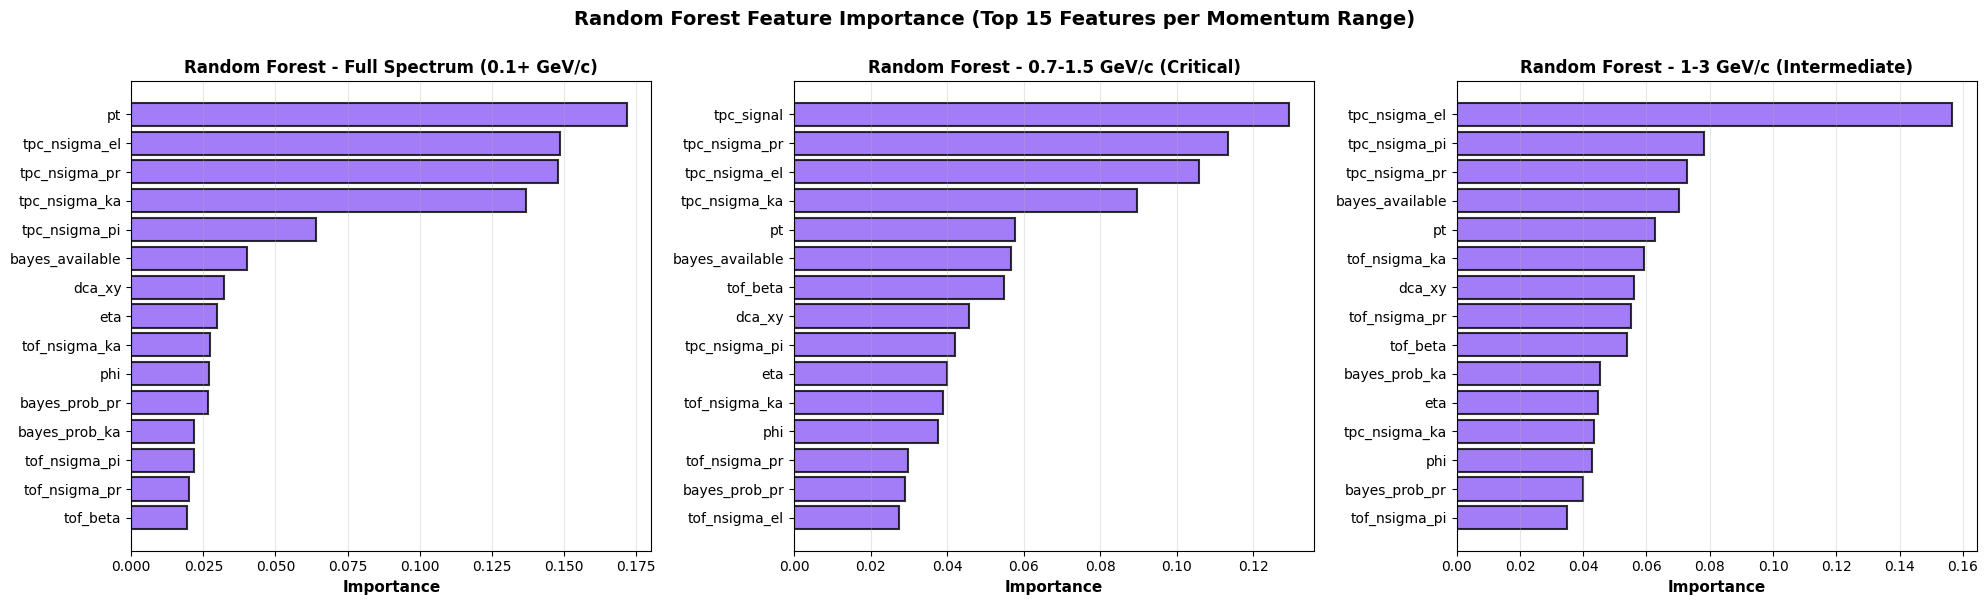

Feature importance plot generated

SECTION 4E COMPLETE: Random Forest training finished



In [21]:
print("="*80)
print("SECTION 4E: TRAINING SKLEARN RANDOM FOREST MODELS")
print("="*80)
print()

# Use hyperparameters from SECTION 0
RF_HYPERPARAMETERS = HYPERPARAMETERS['SkLearn_RandomForest']

print(f"Random Forest Configuration:")
print(f"  n_estimators: {RF_HYPERPARAMETERS['n_estimators']}")
print(f"  max_depth: {RF_HYPERPARAMETERS['max_depth']}")
print(f"  class_weight: {RF_HYPERPARAMETERS['class_weight']}")
print(f"  Features: {len(TRAINING_FEATURES)}")
print(f"  Classes: {NUM_CLASSES}")
print()

print("="*80)
print("SECTION 4E.1: TRAINING RANDOM FOREST FOR ALL MOMENTUM RANGES")
print("="*80)
print()

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    print("="*80)
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print("="*80)
    
    # Check if model exists on disk (matching JAX pattern)
    if mr_key is None:
        mr_key = momentum_range.get('name', 'unknown').replace(' ', '_').lower()
    
    loaded_model = load_single_model(mr_key, 'SkLearn_RandomForest')
    
    if mr_key not in all_results_by_model_and_range or 'preprocessing' not in all_results_by_model_and_range[mr_key]:
        print(f"ERROR: No preprocessing data for {mr_key}. Train neural networks first.")
        continue
    
    preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
    
    X_train = preprocessing_data['X_train_scaled']
    X_test = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_test = preprocessing_data['y_test']
    
    print(f"Dataset shapes:")
    print(f"  Train: {X_train.shape[0]:,} tracks, Test: {X_test.shape[0]:,} tracks")
    print(f"  Features: {X_train.shape[1]}")
    print()
    
    # Load or train model (matching JAX logic)
    if loaded_model is not None and not FORCE_TRAINING['SkLearn_RandomForest'][mr_key]:
        print(f"✓ Loaded cached Random Forest model")
        rf_model = loaded_model['model']
        training_time = loaded_model['training_time']
        print()
    else:
        print(f"Training Random Forest ({RF_HYPERPARAMETERS['n_estimators']} trees)...")
        rf_start_time = time.time()
        
        rf_model = RandomForestClassifier(**RF_HYPERPARAMETERS)
        rf_model.fit(X_train, y_train)
        
        training_time = time.time() - rf_start_time
        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Out-of-bag (OOB) score: {rf_model.oob_score_:.4f}")
        print()
    
    # Evaluate model
    y_train_pred = rf_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    y_test_pred = rf_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    y_test_probs = rf_model.predict_proba(X_test)
    
    # Calculate macro AUC
    y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
    macro_auc_list = []
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
        auc_score = auc(fpr, tpr)
        macro_auc_list.append(auc_score)
    macro_auc = np.mean(macro_auc_list)
    
    print(f"Results:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  Macro AUC:      {macro_auc:.4f}")
    print(f"  OOB Score:      {rf_model.oob_score_:.4f}")
    print()
    
    # Store results (matching JAX pattern)
    if mr_key not in all_results_by_model_and_range:
        all_results_by_model_and_range[mr_key] = {}
    
    results = {
        'model': rf_model,  # Store actual model for later use
        'train_acc': float(train_acc),
        'test_acc': float(test_acc),
        'best_val_acc': float(test_acc),
        'hyperparameters': RF_HYPERPARAMETERS,
        'y_pred_test': y_test_pred,
        'test_probs': y_test_probs,
        'y_test': y_test,
        'macro_auc': float(macro_auc),
        'training_time': training_time,
        'feature_importances': rf_model.feature_importances_,
    }
    
    # Save model to disk (matching JAX pattern)
    save_single_model(mr_key, 'SkLearn_RandomForest', results)
    
    # Store in main dictionary without the model object (too large for memory)
    results_to_store = results.copy()
    del results_to_store['model']  # Remove model from stored results
    
    all_results_by_model_and_range[mr_key]['models'] = all_results_by_model_and_range[mr_key].get('models', {})
    all_results_by_model_and_range[mr_key]['models']['SkLearn_RandomForest'] = results_to_store

print("="*80)
print("SECTION 4E.1 COMPLETE: Random Forest trained/loaded for all momentum ranges")
print("="*80)
print()

print("="*80)
print("SECTION 4E.2: RANDOM FOREST SUMMARY - ALL MOMENTUM RANGES")
print("="*80)
print()

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    if 'SkLearn_RandomForest' not in all_results_by_model_and_range[mr_key]['models']:
        continue
    
    results = all_results_by_model_and_range[mr_key]['models']['SkLearn_RandomForest']
    print(f"{momentum_range['name']:35s} | Train: {results['train_acc']:.4f} | Test: {results['test_acc']:.4f} | AUC: {results['macro_auc']:.4f} | Time: {results['training_time']:.2f}s")

print()

print("="*80)
print("SECTION 4E.3: RANDOM FOREST FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    if 'SkLearn_RandomForest' not in all_results_by_model_and_range[mr_key]['models']:
        continue
    
    ax = axes[idx]
    results = all_results_by_model_and_range[mr_key]['models']['SkLearn_RandomForest']
    importances = results['feature_importances']
    
    sorted_idx = np.argsort(importances)[-15:]
    sorted_importances = importances[sorted_idx]
    sorted_names = [TRAINING_FEATURES[i] for i in sorted_idx]
    
    ax.barh(range(len(sorted_importances)), sorted_importances, color='#8B5CF6', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_yticks(range(len(sorted_importances)))
    ax.set_yticklabels(sorted_names, fontsize=10)
    ax.set_xlabel('Importance', fontsize=11, fontweight='bold')
    ax.set_title(f"Random Forest - {momentum_range['name']}", fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Random Forest Feature Importance (Top 15 Features per Momentum Range)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Feature importance plot generated")
print()

print("="*80)
print("SECTION 4E COMPLETE: Random Forest training finished")
print("="*80)
print()


## Section 4E: Train XGBoost

SECTION 4F: TRAINING XGBOOST MODELS

XGBoost Configuration:
  n_estimators: 500
  max_depth: 7
  learning_rate: 0.1
  subsample: 0.8
  Features: 22
  Classes: 4

SECTION 4F.1: TRAINING XGBOOST FOR ALL MOMENTUM RANGES

MOMENTUM RANGE: Full Spectrum (0.1+ GeV/c)
Dataset shapes:
  Train: 698,749 tracks, Test: 174,688 tracks
  Features: 21

Training XGBoost (500 trees)...
Training completed in 101.82 seconds

Results:
  Train Accuracy: 0.9259
  Test Accuracy:  0.9139
  Macro AUC:      0.9541

✓ Saved to: /kaggle/working/trained_models/full_XGBoost.pkl
MOMENTUM RANGE: 0.7-1.5 GeV/c (Critical)
Dataset shapes:
  Train: 190,524 tracks, Test: 47,631 tracks
  Features: 21

Training XGBoost (500 trees)...
Training completed in 31.47 seconds

Results:
  Train Accuracy: 0.9114
  Test Accuracy:  0.8766
  Macro AUC:      0.9283

✓ Saved to: /kaggle/working/trained_models/0.7-1.5_XGBoost.pkl
MOMENTUM RANGE: 1-3 GeV/c (Intermediate)
Dataset shapes:
  Train: 134,429 tracks, Test: 33,608 tracks
  Feature

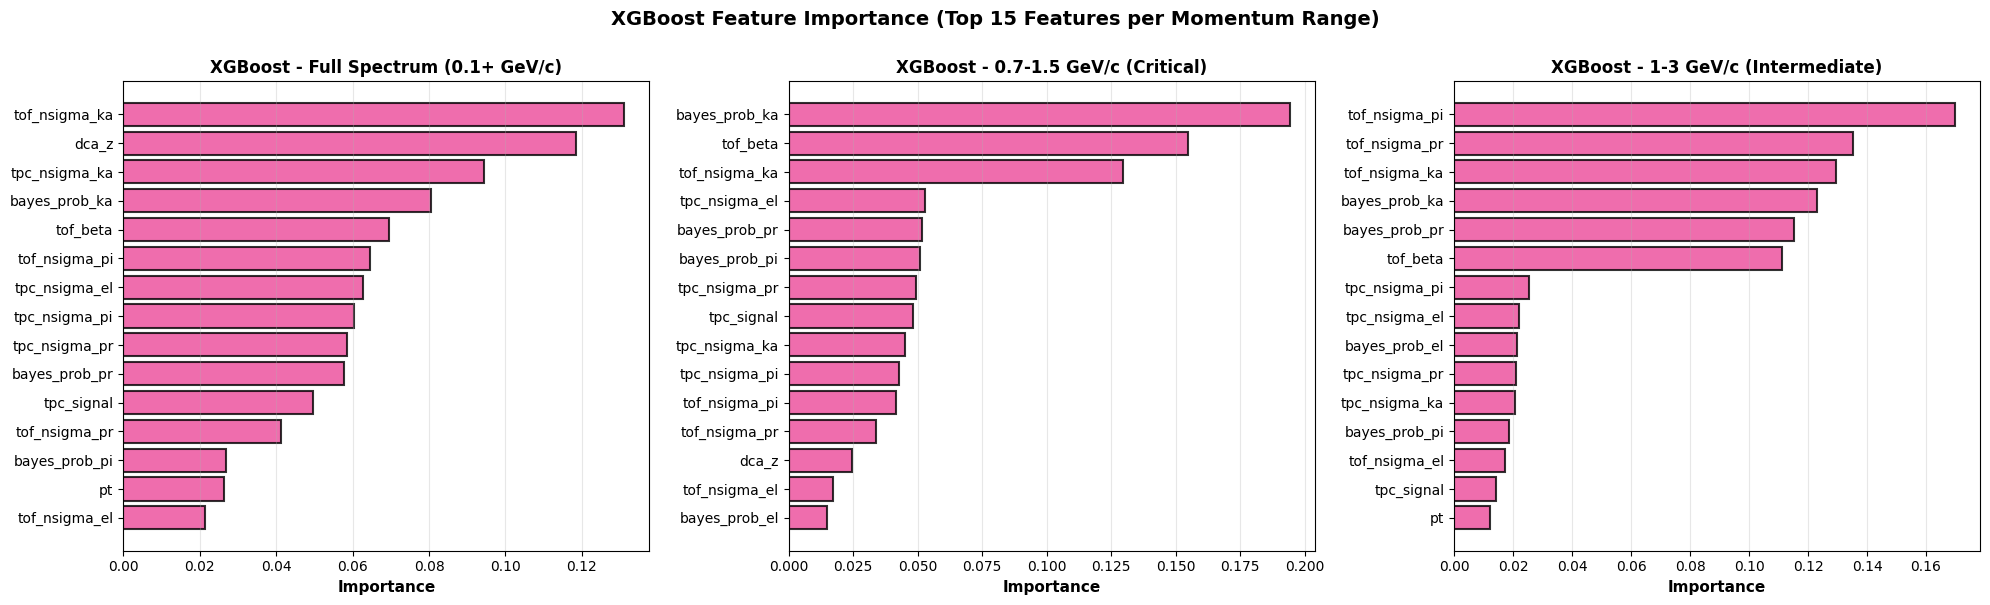

Feature importance plot generated

SECTION 4F COMPLETE: XGBoost training finished



In [22]:
print("="*80)
print("SECTION 4F: TRAINING XGBOOST MODELS")
print("="*80)
print()

# Use hyperparameters from SECTION 0
XGB_HYPERPARAMETERS = HYPERPARAMETERS['XGBoost']

print(f"XGBoost Configuration:")
print(f"  n_estimators: {XGB_HYPERPARAMETERS['n_estimators']}")
print(f"  max_depth: {XGB_HYPERPARAMETERS['max_depth']}")
print(f"  learning_rate: {XGB_HYPERPARAMETERS['learning_rate']}")
print(f"  subsample: {XGB_HYPERPARAMETERS['subsample']}")
print(f"  Features: {len(TRAINING_FEATURES)}")
print(f"  Classes: {NUM_CLASSES}")
print()

print("="*80)
print("SECTION 4F.1: TRAINING XGBOOST FOR ALL MOMENTUM RANGES")
print("="*80)
print()

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    print("="*80)
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print("="*80)
    
    # Check if model exists on disk (matching JAX pattern)
    if mr_key is None:
        mr_key = momentum_range.get('name', 'unknown').replace(' ', '_').lower()
    
    loaded_model = load_single_model(mr_key, 'XGBoost')
    
    if mr_key not in all_results_by_model_and_range or 'preprocessing' not in all_results_by_model_and_range[mr_key]:
        print(f"ERROR: No preprocessing data for {mr_key}. Train neural networks first.")
        continue
    
    preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
    
    X_train = preprocessing_data['X_train_scaled']
    X_test = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_test = preprocessing_data['y_test']
    
    print(f"Dataset shapes:")
    print(f"  Train: {X_train.shape[0]:,} tracks, Test: {X_test.shape[0]:,} tracks")
    print(f"  Features: {X_train.shape[1]}")
    print()
    
    # Load or train model (matching JAX logic)
    if loaded_model is not None and not FORCE_TRAINING['XGBoost'][mr_key]:
        print(f"✓ Loaded cached XGBoost model")
        xgb_model = loaded_model['model']
        training_time = loaded_model['training_time']
        print()
    else:
        print(f"Training XGBoost ({XGB_HYPERPARAMETERS['n_estimators']} trees)...")
        xgb_start_time = time.time()
        
        # Create XGBoost classifier
        xgb_model = xgb.XGBClassifier(
            n_estimators=XGB_HYPERPARAMETERS['n_estimators'],
            max_depth=XGB_HYPERPARAMETERS['max_depth'],
            learning_rate=XGB_HYPERPARAMETERS['learning_rate'],
            subsample=XGB_HYPERPARAMETERS['subsample'],
            colsample_bytree=XGB_HYPERPARAMETERS['colsample_bytree'],
            min_child_weight=XGB_HYPERPARAMETERS['min_child_weight'],
            gamma=XGB_HYPERPARAMETERS['gamma'],
            objective=XGB_HYPERPARAMETERS['objective'],
            num_class=XGB_HYPERPARAMETERS['num_class'],
            random_state=XGB_HYPERPARAMETERS['random_state'],
            n_jobs=XGB_HYPERPARAMETERS['n_jobs'],
            eval_metric=XGB_HYPERPARAMETERS['eval_metric'],
            tree_method=XGB_HYPERPARAMETERS['tree_method'],
            device=XGB_HYPERPARAMETERS['device'],
            verbosity=0
        )
        
        xgb_model.fit(X_train, y_train)
        
        training_time = time.time() - xgb_start_time
        print(f"Training completed in {training_time:.2f} seconds")
        print()
    
    # Evaluate model
    y_train_pred = xgb_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    y_test_pred = xgb_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    y_test_probs = xgb_model.predict_proba(X_test)
    
    # Calculate macro AUC
    y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
    macro_auc_list = []
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
        auc_score = auc(fpr, tpr)
        macro_auc_list.append(auc_score)
    macro_auc = np.mean(macro_auc_list)
    
    print(f"Results:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  Macro AUC:      {macro_auc:.4f}")
    print()
    
    # Store results (matching JAX pattern)
    if mr_key not in all_results_by_model_and_range:
        all_results_by_model_and_range[mr_key] = {}
    
    results = {
        'model': xgb_model,  # Store actual model for later use
        'train_acc': float(train_acc),
        'test_acc': float(test_acc),
        'best_val_acc': float(test_acc),
        'hyperparameters': XGB_HYPERPARAMETERS,
        'y_pred_test': y_test_pred,
        'test_probs': y_test_probs,
        'y_test': y_test,
        'macro_auc': float(macro_auc),
        'training_time': training_time,
        'feature_importances': xgb_model.feature_importances_,
    }
    
    # Save model to disk (matching JAX pattern)
    save_single_model(mr_key, 'XGBoost', results)
    
    # Store in main dictionary without the model object (too large for memory)
    results_to_store = results.copy()
    del results_to_store['model']  # Remove model from stored results
    
    all_results_by_model_and_range[mr_key]['models'] = all_results_by_model_and_range[mr_key].get('models', {})
    all_results_by_model_and_range[mr_key]['models']['XGBoost'] = results_to_store

print("="*80)
print("SECTION 4F.1 COMPLETE: XGBoost trained/loaded for all momentum ranges")
print("="*80)
print()

print("="*80)
print("SECTION 4F.2: XGBOOST SUMMARY - ALL MOMENTUM RANGES")
print("="*80)
print()

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    if 'XGBoost' not in all_results_by_model_and_range[mr_key]['models']:
        continue
    
    results = all_results_by_model_and_range[mr_key]['models']['XGBoost']
    print(f"{momentum_range['name']:35s} | Train: {results['train_acc']:.4f} | Test: {results['test_acc']:.4f} | AUC: {results['macro_auc']:.4f} | Time: {results['training_time']:.2f}s")

print()

print("="*80)
print("SECTION 4F.3: XGBOOST FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    if 'XGBoost' not in all_results_by_model_and_range[mr_key]['models']:
        continue
    
    ax = axes[idx]
    results = all_results_by_model_and_range[mr_key]['models']['XGBoost']
    importances = results['feature_importances']
    
    sorted_idx = np.argsort(importances)[-15:]
    sorted_importances = importances[sorted_idx]
    sorted_names = [TRAINING_FEATURES[i] for i in sorted_idx]
    
    ax.barh(range(len(sorted_importances)), sorted_importances, color='#EC4899', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_yticks(range(len(sorted_importances)))
    ax.set_yticklabels(sorted_names, fontsize=10)
    ax.set_xlabel('Importance', fontsize=11, fontweight='bold')
    ax.set_title(f"XGBoost - {momentum_range['name']}", fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('XGBoost Feature Importance (Top 15 Features per Momentum Range)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Feature importance plot generated")
print()

print("="*80)
print("SECTION 4F COMPLETE: XGBoost training finished")
print("="*80)
print()


## Section 5:  Comparison Visualisations

### Section 5A: Advanced Comparison Visualisations


################################################################################
SECTION 5A: MODEL COMPARISON & PERFORMANCE ANALYSIS (6 MODELS)
################################################################################


COMPREHENSIVE MODEL COMPARISON (6 Models, All Momentum Ranges)

            Momentum Range         Model  Train Acc  Test Acc  Macro AUC  Training Time (s)
Full Spectrum (0.1+ GeV/c)      SimpleNN   0.667335  0.667005   0.918234           0.000000
Full Spectrum (0.1+ GeV/c)           DNN   0.653993  0.652371   0.820922           0.000000
Full Spectrum (0.1+ GeV/c)   FSE Phase 0   0.679066  0.678320   0.920723           0.000000
Full Spectrum (0.1+ GeV/c)   FSE Phase 1   0.694955  0.694573   0.921407           0.000000
Full Spectrum (0.1+ GeV/c) Random Forest   0.812712  0.775010   0.948069         559.839845
Full Spectrum (0.1+ GeV/c)       XGBoost   0.925889  0.913944   0.954060         101.820472
  0.7-1.5 GeV/c (Critical)      SimpleNN   0.521031  0.522804   

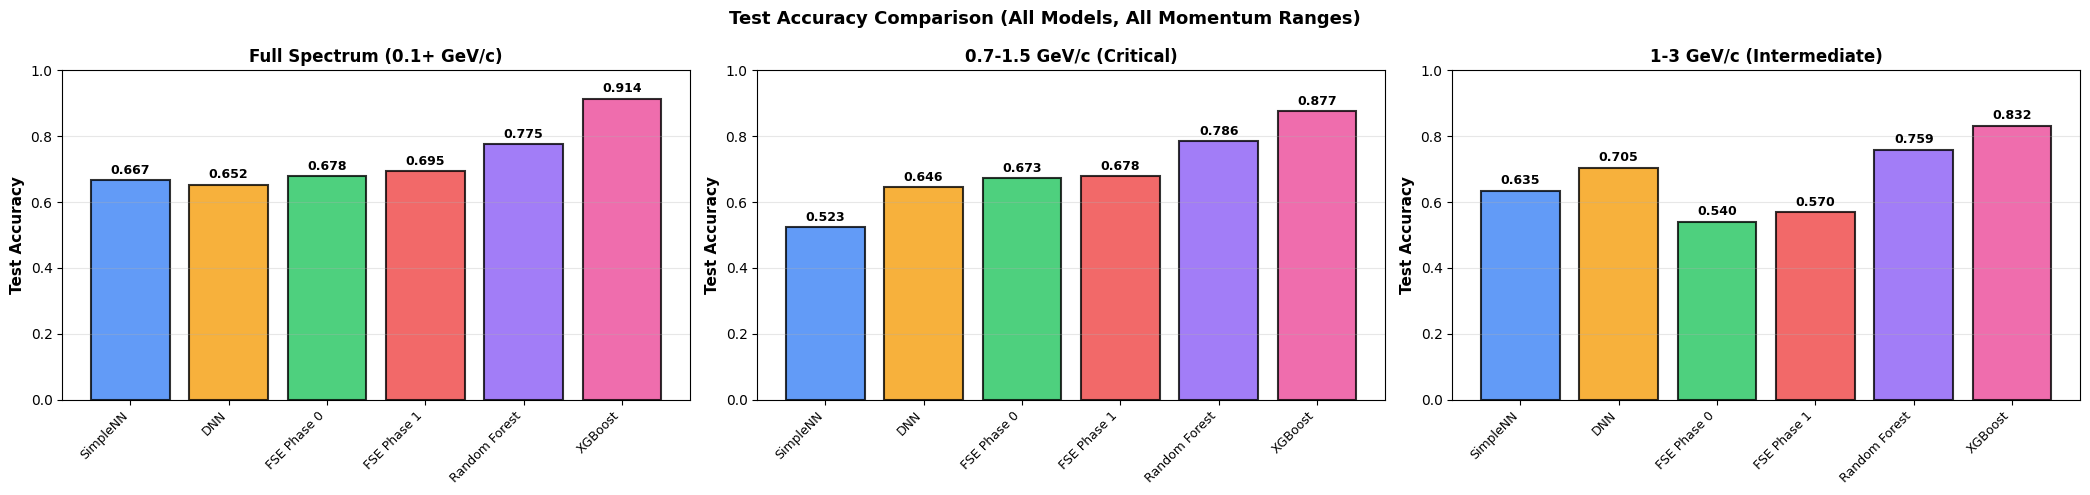

✓ Accuracy comparison plots generated (6 models)

BEST MODEL SELECTION & CONFUSION MATRICES (3 Ranges)


Full Spectrum (0.1+ GeV/c)
──────────────────────────────────────────────────────────────────────
  SimpleNN            : 0.6670
  DNN                 : 0.6524
  FSE Phase 0         : 0.6783
  FSE Phase 1         : 0.6946
  Random Forest       : 0.7750
  XGBoost             : 0.9139

✓ Best Model: XGBoost (0.9139)


0.7-1.5 GeV/c (Critical)
──────────────────────────────────────────────────────────────────────
  SimpleNN            : 0.5228
  DNN                 : 0.6456
  FSE Phase 0         : 0.6726
  FSE Phase 1         : 0.6779
  Random Forest       : 0.7859
  XGBoost             : 0.8766

✓ Best Model: XGBoost (0.8766)


1-3 GeV/c (Intermediate)
──────────────────────────────────────────────────────────────────────
  SimpleNN            : 0.6349
  DNN                 : 0.7046
  FSE Phase 0         : 0.5402
  FSE Phase 1         : 0.5699
  Random Forest       : 0.7588
  XGBoost 

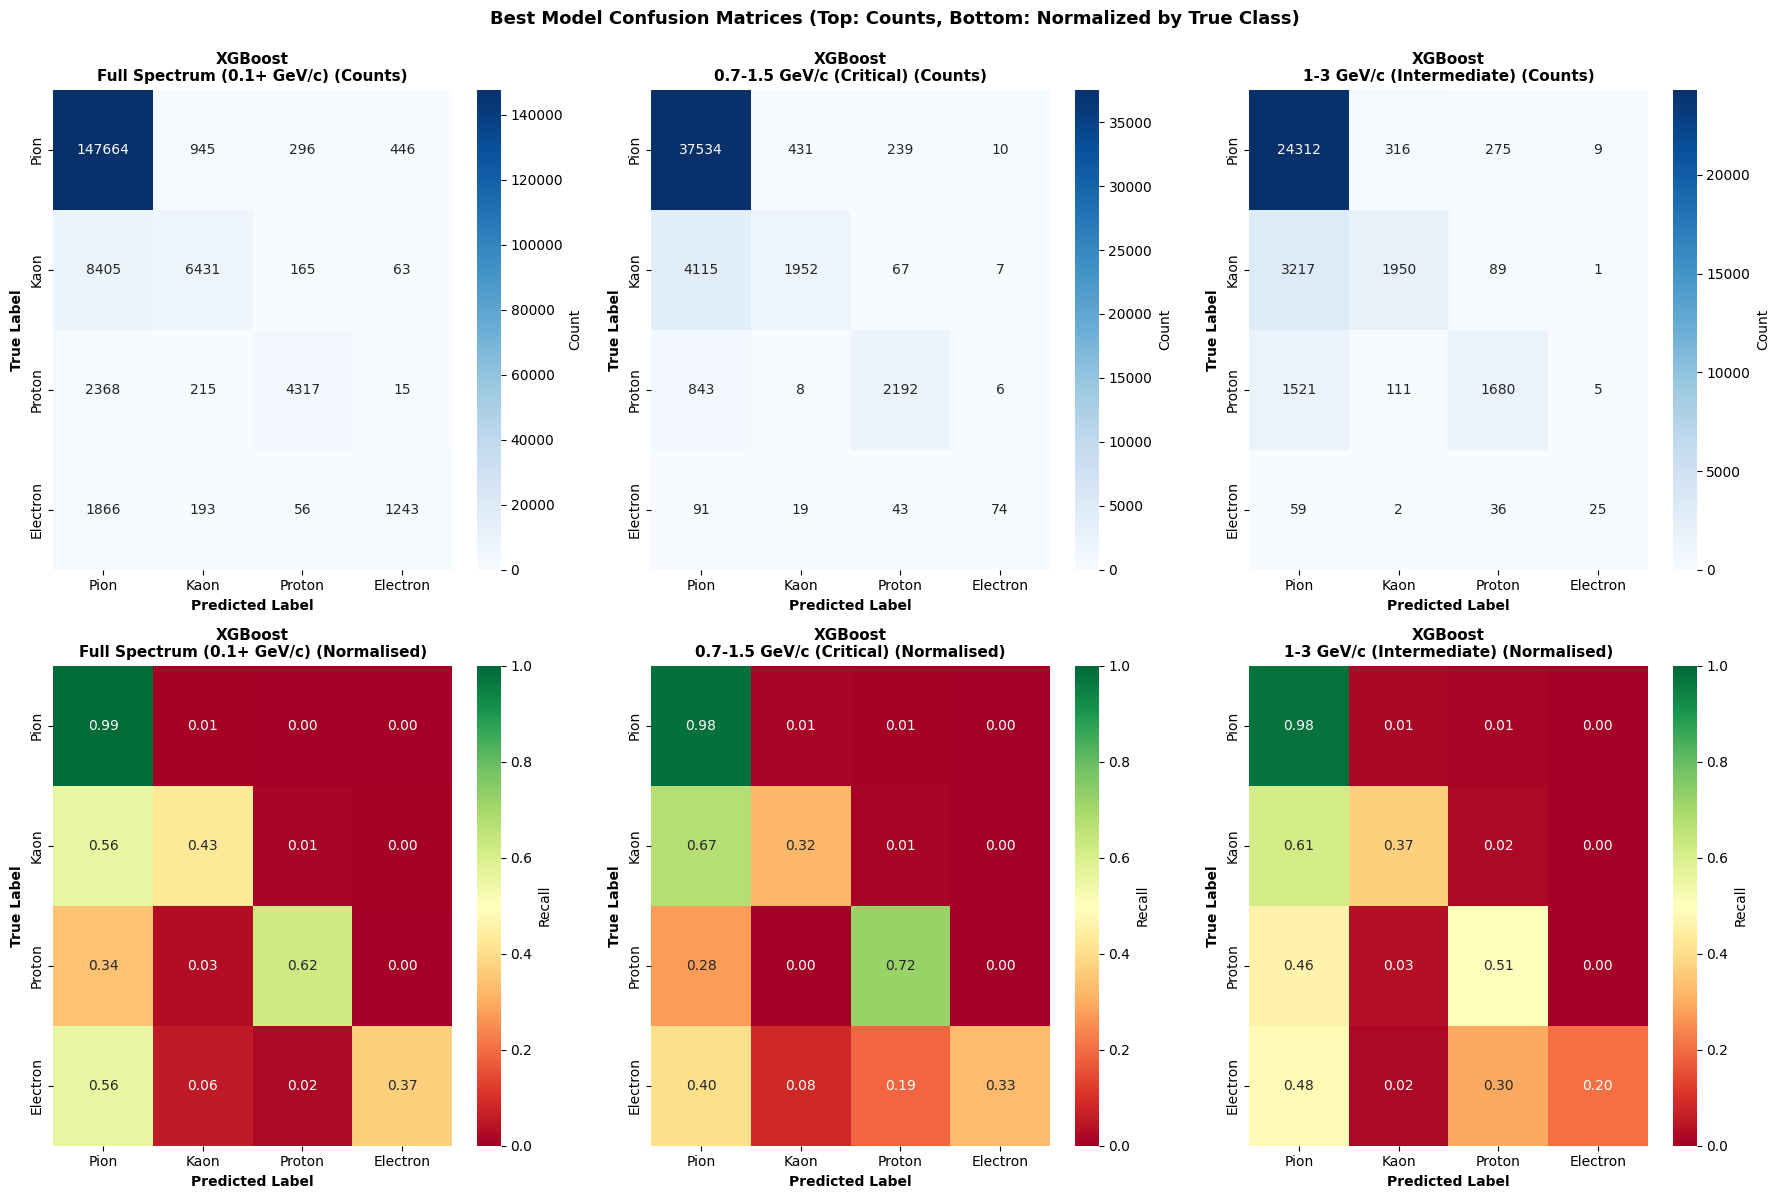


✓ Confusion matrices generated in grid format

CLASS-WISE PERFORMANCE ANALYSIS (PRECISION, RECALL, F1)


Full Spectrum (0.1+ GeV/c) - XGBoost
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

        Pion     0.9212    0.9887    0.9537    149351
        Kaon     0.8262    0.4269    0.5629     15064
      Proton     0.8930    0.6243    0.7349      6915
    Electron     0.7035    0.3702    0.4851      3358

    accuracy                         0.9139    174688
   macro avg     0.8360    0.6025    0.6842    174688
weighted avg     0.9077    0.9139    0.9024    174688


0.7-1.5 GeV/c (Critical) - XGBoost
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

        Pion     0.8814    0.9822    0.9291     38214
        Kaon     0.8100    0.3179    0.4566      6141
      Proton     0.8627    0.7189    0.7843      3049
    Electron     0.7629    

In [27]:
print(f"\n{'#'*80}")
print("SECTION 5A: MODEL COMPARISON & PERFORMANCE ANALYSIS (6 MODELS)")
print(f"{'#'*80}\n")

# Model colors and display names
model_colors_dict = {
    'JAX_SimpleNN': '#3B82F6',
    'JAX_DNN': '#F59E0B',
    'JAX_FSE_Attention': '#22C55E',
    'JAX_FSE_Attention_DetectorAware': '#EF4444',
    'SkLearn_RandomForest': '#8B5CF6',
    'XGBoost': '#EC4899'
}

model_display_names = {
    'JAX_SimpleNN': 'SimpleNN',
    'JAX_DNN': 'DNN',
    'JAX_FSE_Attention': 'FSE Phase 0',
    'JAX_FSE_Attention_DetectorAware': 'FSE Phase 1',
    'SkLearn_RandomForest': 'Random Forest',
    'XGBoost': 'XGBoost'
}

# ============================================================================
# PART 1: COMPREHENSIVE COMPARISON TABLE
# ============================================================================

print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COMPARISON (6 Models, All Momentum Ranges)")
print(f"{'='*80}\n")

comparison_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for model_type in MODEL_TYPES:
        if model_type in models_dict:
            results = models_dict[model_type]
            
            # Calculate macro AUC if not present (for JAX models)
            macro_auc = results.get('macro_auc', np.nan)
            if np.isnan(macro_auc) or macro_auc == 0:
                # Calculate from test_probs if available
                if 'test_probs' in results and results['test_probs'] is not None:
                    try:
                        y_test_bin = label_binarize(results['y_test'], classes=np.arange(NUM_CLASSES))
                        test_probs = results['test_probs']
                        auc_scores = []
                        for i in range(NUM_CLASSES):
                            fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
                            auc_score = auc(fpr, tpr)
                            auc_scores.append(auc_score)
                        macro_auc = np.mean(auc_scores)
                    except:
                        macro_auc = np.nan
            
            comparison_data.append({
                'Momentum Range': momentum_range['name'],
                'Model': model_display_names.get(model_type, model_type),
                'Train Acc': results['train_acc'],
                'Test Acc': results['test_acc'],
                'Macro AUC': macro_auc,
                'Training Time (s)': results.get('training_time', 0)
            })

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df.to_string(index=False))
print()

# ============================================================================
# PART 2: ACCURACY COMPARISON PLOTS (6 Models)
# ============================================================================

print(f"\n{'='*80}")
print("ACCURACY COMPARISON ACROSS ALL MODELS (6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    ax = axes[mr_idx]
    
    x_pos = np.arange(len(MODEL_TYPES))
    test_accs = []
    colors = []
    
    for model_type in MODEL_TYPES:
        if mr_key in all_results_by_model_and_range and 'models' in all_results_by_model_and_range[mr_key]:
            if model_type in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models'][model_type]
                test_accs.append(results['test_acc'])
                colors.append(model_colors_dict.get(model_type, '#999999'))
            else:
                test_accs.append(0)
                colors.append('#CCCCCC')
        else:
            test_accs.append(0)
            colors.append('#CCCCCC')
    
    bars = ax.bar(x_pos, test_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([model_display_names.get(m, m) for m in MODEL_TYPES], 
                       rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Test Accuracy Comparison (All Models, All Momentum Ranges)', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ Accuracy comparison plots generated (6 models)")

# ============================================================================
# PART 3: BEST MODEL SELECTION & CONFUSION MATRICES (GRID VIEW)
# ============================================================================

print(f"\n{'='*80}")
print("BEST MODEL SELECTION & CONFUSION MATRICES (3 Ranges)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

best_models_info = []

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    print(f"\n{momentum_range['name']}")
    print(f"{'─'*70}")
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    # Find best model
    best_acc = -1
    best_model = None
    
    for model_type in MODEL_TYPES:
        if model_type in models_dict:
            test_acc = models_dict[model_type]['test_acc']
            print(f"  {model_display_names.get(model_type, model_type):20s}: {test_acc:.4f}")
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = model_type
    
    if best_model:
        print(f"\n✓ Best Model: {model_display_names.get(best_model, best_model)} ({best_acc:.4f})\n")
        
        best_models_info.append((best_model, mr_key, momentum_range, best_acc))
        
        # Confusion matrix for best model
        y_test = models_dict[best_model]['y_test']
        y_pred = models_dict[best_model]['y_pred_test']
        
        cm = confusion_matrix(y_test, y_pred)
        
        # Normalize confusion matrix for better visualization
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        ax = axes[0, mr_idx]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=PARTICLE_NAMES, yticklabels=PARTICLE_NAMES,
                   cbar_kws={'label': 'Count'}, vmin=0)
        
        ax.set_ylabel('True Label', fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
        ax.set_title(f'{model_display_names.get(best_model, best_model)}\n{momentum_range["name"]} (Counts)',
                    fontsize=11, fontweight='bold')
        
        # Normalized confusion matrix
        ax_norm = axes[1, mr_idx]
        
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax_norm,
                   xticklabels=PARTICLE_NAMES, yticklabels=PARTICLE_NAMES,
                   cbar_kws={'label': 'Recall'}, vmin=0, vmax=1)
        
        ax_norm.set_ylabel('True Label', fontsize=10, fontweight='bold')
        ax_norm.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
        ax_norm.set_title(f'{model_display_names.get(best_model, best_model)}\n{momentum_range["name"]} (Normalised)',
                         fontsize=11, fontweight='bold')

plt.suptitle('Best Model Confusion Matrices (Top: Counts, Bottom: Normalized by True Class)', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ Confusion matrices generated in grid format")
print("="*80)

# ============================================================================
# PART 4: CLASS-WISE PERFORMANCE METRICS
# ============================================================================

print(f"\n{'='*80}")
print("CLASS-WISE PERFORMANCE ANALYSIS (PRECISION, RECALL, F1)")
print(f"{'='*80}\n")

for best_model, mr_key, momentum_range, best_acc in best_models_info:
    print(f"\n{momentum_range['name']} - {model_display_names.get(best_model, best_model)}")
    print(f"{'─'*70}")
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    y_test = models_dict[best_model]['y_test']
    y_pred = models_dict[best_model]['y_pred_test']
    
    # Classification report
    report = classification_report(y_test, y_pred, target_names=PARTICLE_NAMES, 
                                  output_dict=False, digits=4)
    print(report)

# ============================================================================
# PART 5: PERFORMANCE RANKING (ALL 18 RESULTS)
# ============================================================================

print(f"\n{'='*80}")
print("PERFORMANCE RANKING (All 18 Results: 3 Ranges × 6 Models)")
print(f"{'='*80}\n")

ranking_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for model_type in MODEL_TYPES:
        if model_type in models_dict:
            results = models_dict[model_type]
            
            # Calculate macro AUC if not present
            macro_auc = results.get('macro_auc', np.nan)
            if np.isnan(macro_auc) or macro_auc == 0:
                if 'test_probs' in results and results['test_probs'] is not None:
                    try:
                        y_test_bin = label_binarize(results['y_test'], classes=np.arange(NUM_CLASSES))
                        test_probs = results['test_probs']
                        auc_scores = []
                        for i in range(NUM_CLASSES):
                            fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
                            auc_score = auc(fpr, tpr)
                            auc_scores.append(auc_score)
                        macro_auc = np.mean(auc_scores)
                    except:
                        macro_auc = np.nan
            
            ranking_data.append({
                'Rank': 0,
                'Model': model_display_names.get(model_type, model_type),
                'Momentum Range': momentum_range['name'],
                'Test Acc': results['test_acc'],
                'Macro AUC': macro_auc,
                'Train Time (s)': results.get('training_time', 0)
            })

ranking_df = pd.DataFrame(ranking_data).sort_values('Test Acc', ascending=False).reset_index(drop=True)
ranking_df['Rank'] = np.arange(1, len(ranking_df) + 1)

# Reorder columns
ranking_df = ranking_df[['Rank', 'Model', 'Momentum Range', 'Test Acc', 'Macro AUC', 'Train Time (s)']]

print(ranking_df.to_string(index=False))
print()

# ============================================================================
# PART 6: SUMMARY STATISTICS
# ============================================================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS BY MODEL")
print(f"{'='*80}\n")

summary_stats = []

for model_type in MODEL_TYPES:
    model_name = model_display_names.get(model_type, model_type)
    accs = []
    aucs = []
    times = []
    
    for mr_key, momentum_range in MOMENTUM_RANGES.items():
        if mr_key in all_results_by_model_and_range and 'models' in all_results_by_model_and_range[mr_key]:
            if model_type in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models'][model_type]
                accs.append(results['test_acc'])
                
                macro_auc = results.get('macro_auc', np.nan)
                if np.isnan(macro_auc) or macro_auc == 0:
                    if 'test_probs' in results and results['test_probs'] is not None:
                        try:
                            y_test_bin = label_binarize(results['y_test'], classes=np.arange(NUM_CLASSES))
                            test_probs = results['test_probs']
                            auc_scores = []
                            for i in range(NUM_CLASSES):
                                fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
                                auc_score = auc(fpr, tpr)
                                auc_scores.append(auc_score)
                            macro_auc = np.mean(auc_scores)
                        except:
                            macro_auc = np.nan
                
                if not np.isnan(macro_auc):
                    aucs.append(macro_auc)
                times.append(results.get('training_time', 0))
    
    if accs:
        summary_stats.append({
            'Model': model_name,
            'Avg Test Acc': np.mean(accs),
            'Min Test Acc': np.min(accs),
            'Max Test Acc': np.max(accs),
            'Avg AUC': np.mean(aucs) if aucs else np.nan,
            'Total Time (s)': np.sum(times)
        })

summary_df = pd.DataFrame(summary_stats).sort_values('Avg Test Acc', ascending=False)

print(summary_df.to_string(index=False))
print()

print(f"{'='*80}")
print("✓ SECTION 5A COMPLETE: All models compared (6 models)")
print(f"{'='*80}\n")


### Section 5B: ROC/AUC Curves and Summary Statistics


################################################################################
SECTION 5B: ROC/AUC ANALYSIS (6 MODELS)
################################################################################


ROC CURVES: MACRO AUC (6 Models, All Momentum Ranges)



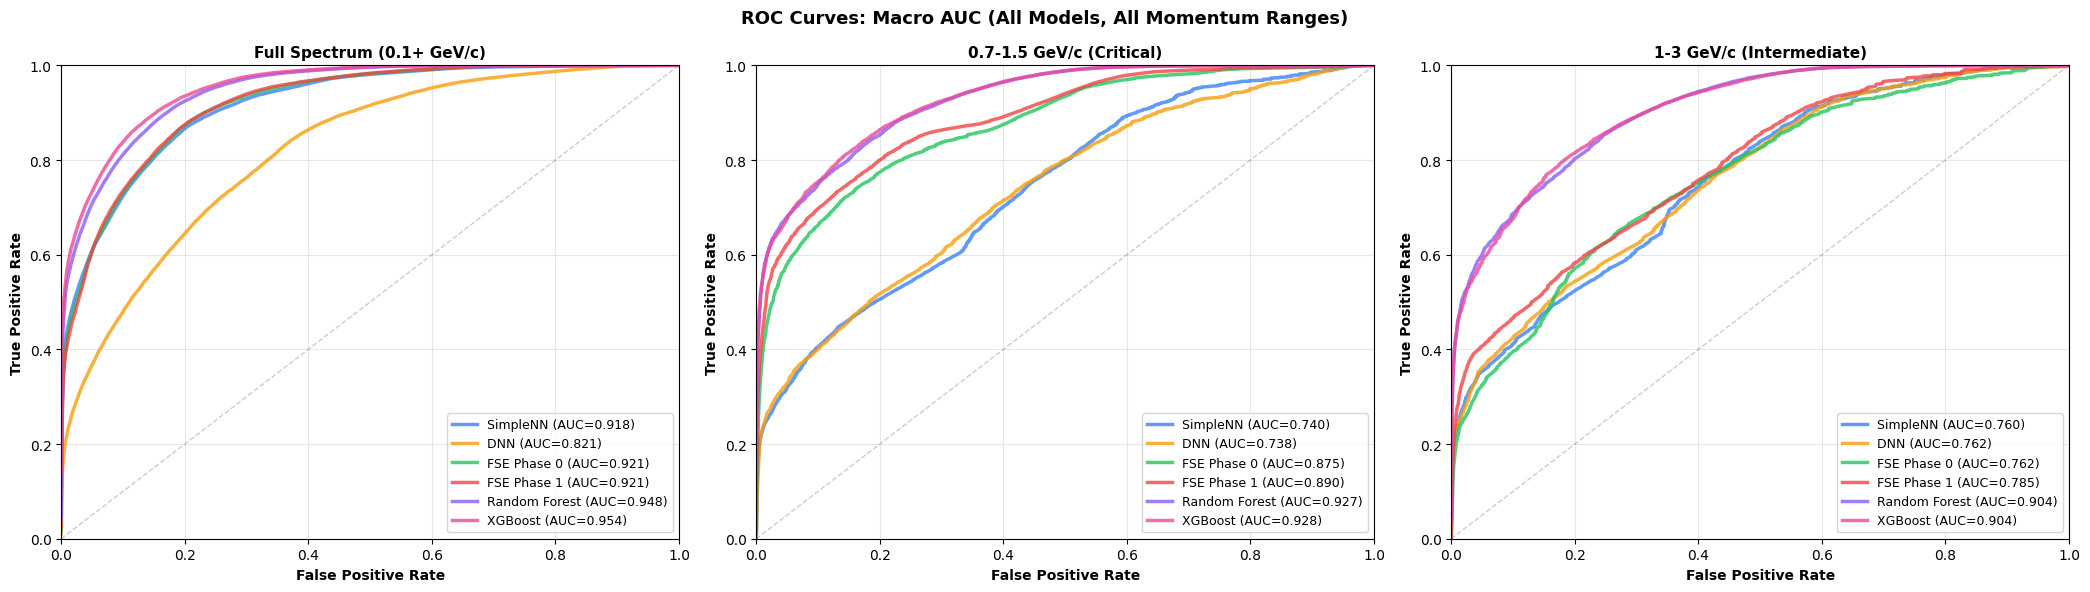

✓ ROC curves (macro AUC) plotted (6 models)

ONE-VS-REST ROC CURVES (Particles vs All, 6 Models)



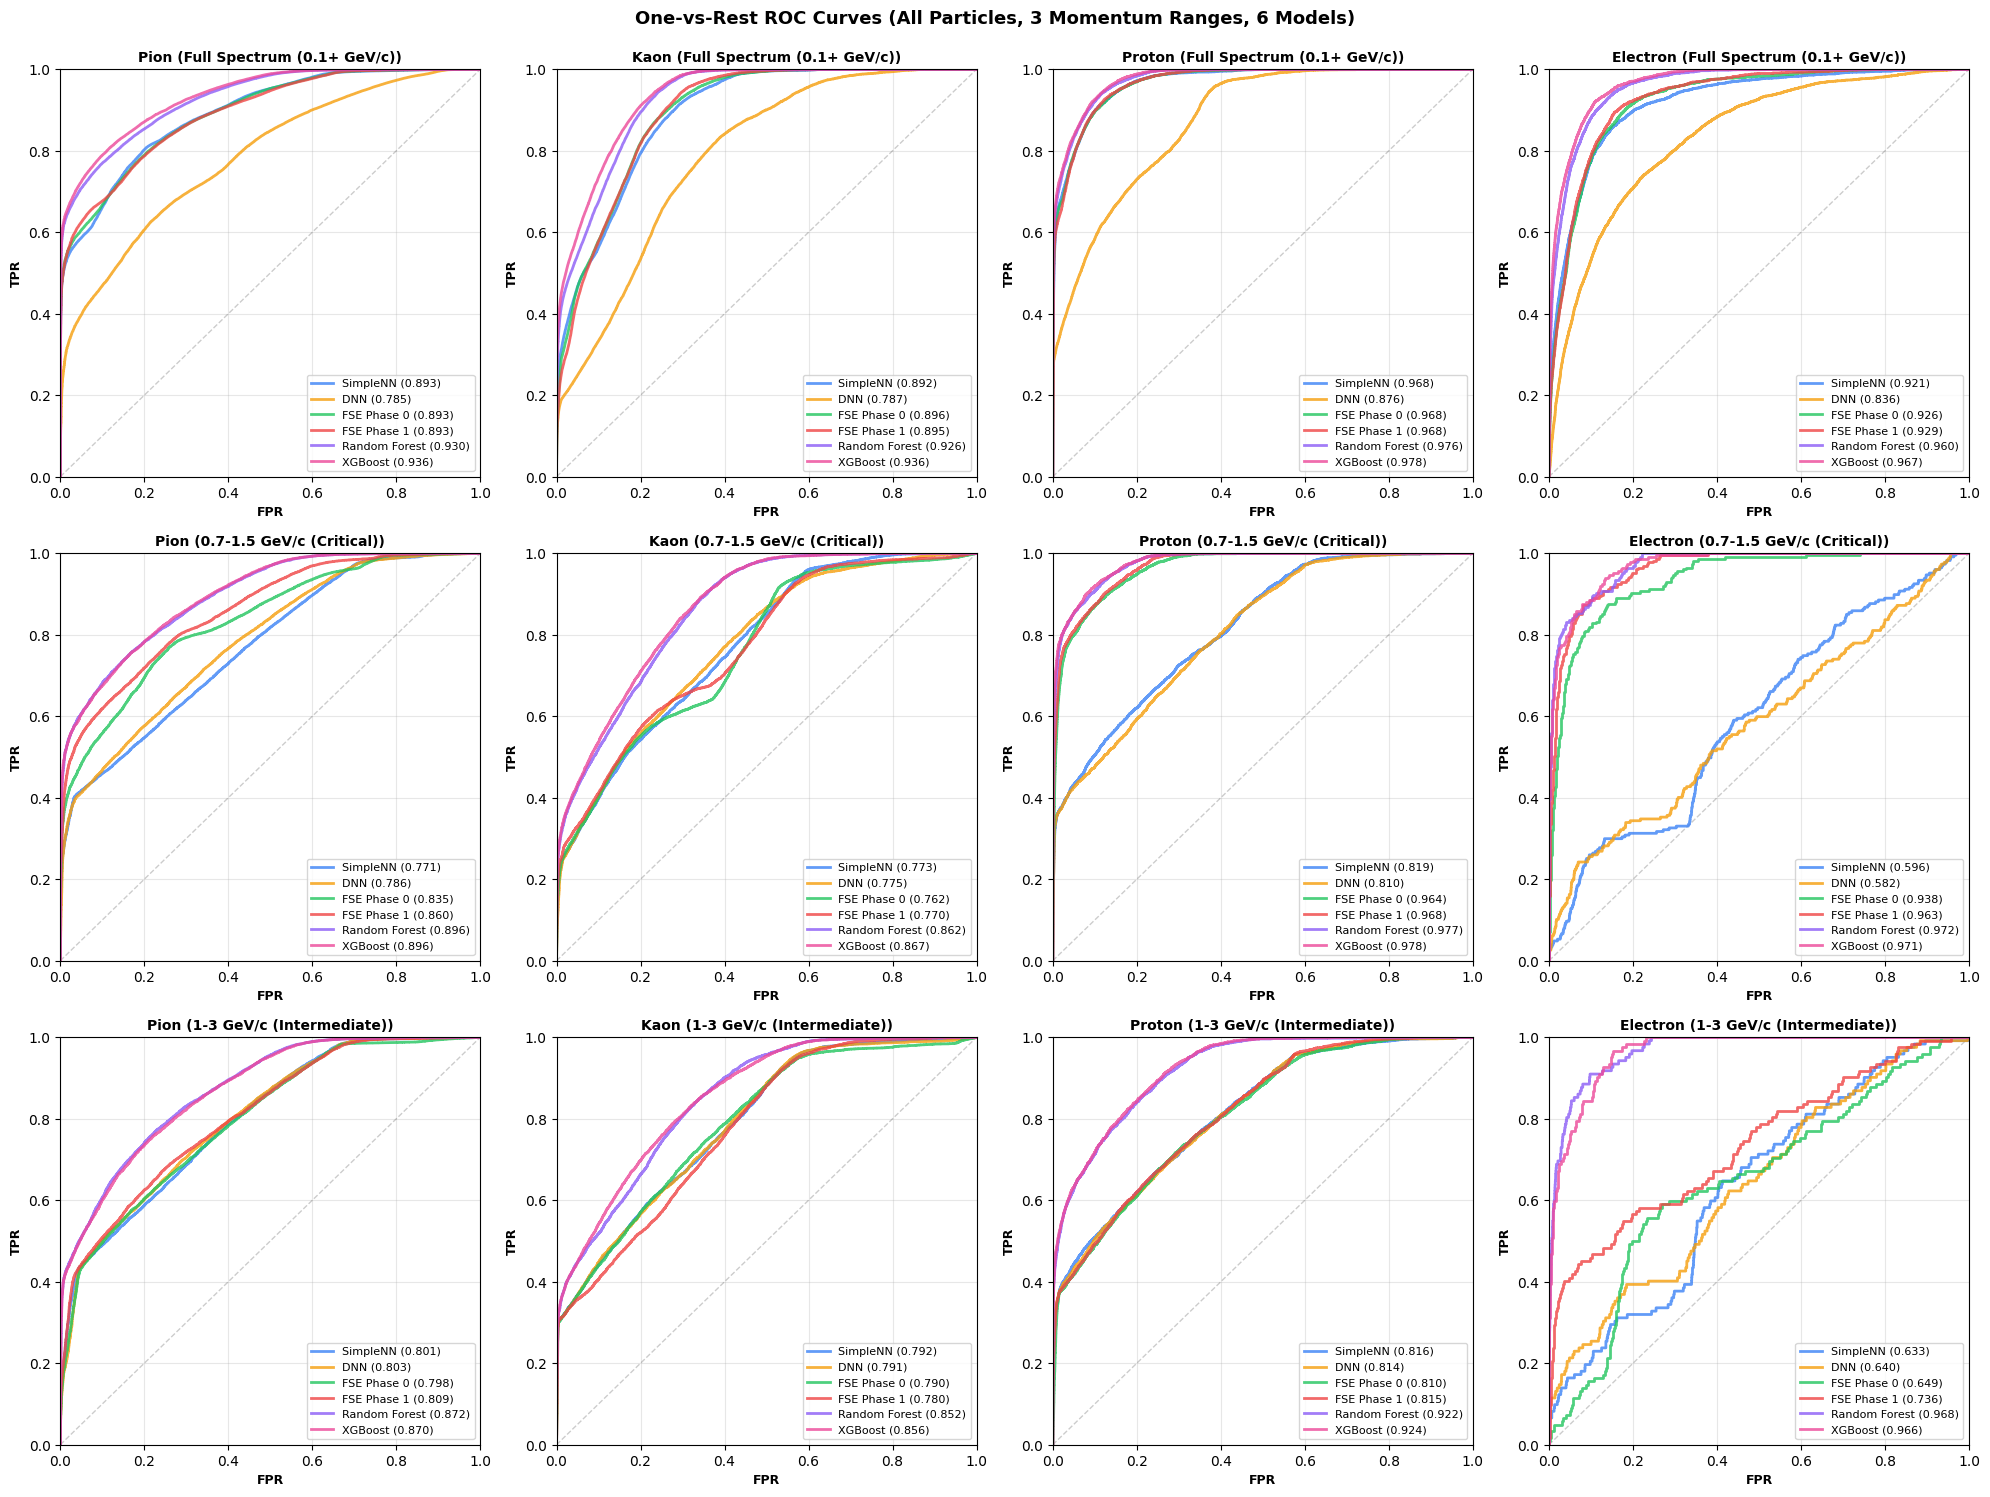

✓ One-vs-rest ROC curves plotted (6 models × 4 particles × 3 ranges)

MACRO AUC SUMMARY TABLE (6 Models, All Ranges & Particles)

            Momentum Range         Model Particle      AUC
Full Spectrum (0.1+ GeV/c)      SimpleNN     Pion 0.892991
Full Spectrum (0.1+ GeV/c)      SimpleNN     Kaon 0.891523
Full Spectrum (0.1+ GeV/c)      SimpleNN   Proton 0.967743
Full Spectrum (0.1+ GeV/c)      SimpleNN Electron 0.920679
Full Spectrum (0.1+ GeV/c)           DNN     Pion 0.785094
Full Spectrum (0.1+ GeV/c)           DNN     Kaon 0.787212
Full Spectrum (0.1+ GeV/c)           DNN   Proton 0.875752
Full Spectrum (0.1+ GeV/c)           DNN Electron 0.835629
Full Spectrum (0.1+ GeV/c)   FSE Phase 0     Pion 0.892937
Full Spectrum (0.1+ GeV/c)   FSE Phase 0     Kaon 0.895626
Full Spectrum (0.1+ GeV/c)   FSE Phase 0   Proton 0.968167
Full Spectrum (0.1+ GeV/c)   FSE Phase 0 Electron 0.926163
Full Spectrum (0.1+ GeV/c)   FSE Phase 1     Pion 0.893015
Full Spectrum (0.1+ GeV/c)   FSE Phase 1    

In [28]:
print(f"\n{'#'*80}")
print("SECTION 5B: ROC/AUC ANALYSIS (6 MODELS)")
print(f"{'#'*80}\n")

# Model colors dictionary for consistency
model_colors_dict = {
    'JAX_SimpleNN': '#3B82F6',
    'JAX_DNN': '#F59E0B',
    'JAX_FSE_Attention': '#22C55E',
    'JAX_FSE_Attention_DetectorAware': '#EF4444',
    'SkLearn_RandomForest': '#8B5CF6',
    'XGBoost': '#EC4899'
}

model_display_names = {
    'JAX_SimpleNN': 'SimpleNN',
    'JAX_DNN': 'DNN',
    'JAX_FSE_Attention': 'FSE Phase 0',
    'JAX_FSE_Attention_DetectorAware': 'FSE Phase 1',
    'SkLearn_RandomForest': 'Random Forest',
    'XGBoost': 'XGBoost'
}

# ============================================================================
# PART 1: ROC CURVES PER MOMENTUM RANGE (MACRO AUC)
# ============================================================================

print(f"\n{'='*80}")
print("ROC CURVES: MACRO AUC (6 Models, All Momentum Ranges)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    ax = axes[mr_idx]
    
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    # Plot diagonal (chance line)
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.2)
    
    for model_type in MODEL_TYPES:
        if model_type not in models_dict:
            continue
        
        results = models_dict[model_type]
        
        y_test = np.array(results['y_test'])
        y_test_probs = np.array(results['test_probs'])
        
        y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
        
        # Calculate macro-average ROC curve and ROC area (per class then average)
        fpr_all = []
        tpr_all = []
        auc_scores = []
        
        for i in range(NUM_CLASSES):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
            auc_score = auc(fpr, tpr)
            auc_scores.append(auc_score)
            fpr_all.append(fpr)
            tpr_all.append(tpr)
        
        # Macro AUC = average of per-class AUCs
        macro_auc = np.mean(auc_scores)
        
        # For plotting, interpolate to common x-axis for smooth line
        all_fpr = np.unique(np.concatenate([fpr for fpr in fpr_all]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(NUM_CLASSES):
            mean_tpr += np.interp(all_fpr, fpr_all[i], tpr_all[i])
        mean_tpr /= NUM_CLASSES
        
        ax.plot(all_fpr, mean_tpr, 
               label=f'{model_display_names.get(model_type, model_type)} (AUC={macro_auc:.3f})',
               color=model_colors_dict.get(model_type, '#999999'),
               lw=2.5, alpha=0.8)
    
    ax.set_xlabel('False Positive Rate', fontsize=10, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=10, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=11, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('ROC Curves: Macro AUC (All Models, All Momentum Ranges)', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ ROC curves (macro AUC) plotted (6 models)")

# ============================================================================
# PART 2: ONE-VS-REST ROC CURVES
# ============================================================================

print(f"\n{'='*80}")
print("ONE-VS-REST ROC CURVES (Particles vs All, 6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
        ax = axes[mr_idx, particle_idx]
        
        # Plot diagonal (chance line)
        ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.2)
        
        for model_type in MODEL_TYPES:
            if model_type not in models_dict:
                continue
            
            results = models_dict[model_type]
            y_test = np.array(results['y_test'])
            y_test_probs = np.array(results['test_probs'])
            
            y_binary = (y_test == particle_idx).astype(int)
            
            fpr, tpr, _ = roc_curve(y_binary, y_test_probs[:, particle_idx])
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, 
                   label=f'{model_display_names.get(model_type, model_type)} ({roc_auc:.3f})',
                   color=model_colors_dict.get(model_type, '#999999'),
                   lw=2, alpha=0.8)
        
        ax.set_xlabel('FPR', fontsize=9, fontweight='bold')
        ax.set_ylabel('TPR', fontsize=9, fontweight='bold')
        ax.set_title(f'{particle_name} ({momentum_range["name"]})', fontsize=10, fontweight='bold')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(alpha=0.3)

plt.suptitle('One-vs-Rest ROC Curves (All Particles, 3 Momentum Ranges, 6 Models)', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ One-vs-rest ROC curves plotted (6 models × 4 particles × 3 ranges)")

# ============================================================================
# PART 3: MACRO AUC SUMMARY TABLE
# ============================================================================

print(f"\n{'='*80}")
print("MACRO AUC SUMMARY TABLE (6 Models, All Ranges & Particles)")
print(f"{'='*80}\n")

auc_summary_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for model_type in MODEL_TYPES:
        if model_type not in models_dict:
            continue
        
        results = models_dict[model_type]
        
        y_test = np.array(results['y_test'])
        y_test_probs = np.array(results['test_probs'])
        
        y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
        
        for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
            fpr, tpr, _ = roc_curve(y_test_bin[:, particle_idx], y_test_probs[:, particle_idx])
            roc_auc = auc(fpr, tpr)
            
            auc_summary_data.append({
                'Momentum Range': momentum_range['name'],
                'Model': model_display_names.get(model_type, model_type),
                'Particle': particle_name,
                'AUC': roc_auc
            })

auc_summary_df = pd.DataFrame(auc_summary_data)

print(auc_summary_df.to_string(index=False))
print()

# ============================================================================
# PART 4: MACRO AUC RANKING (Fixed - Calculates for JAX models too)
# ============================================================================

print(f"\n{'='*80}")
print("MACRO AUC RANKING (All Models, All Ranges)")
print(f"{'='*80}\n")

macro_auc_ranking = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for model_type in MODEL_TYPES:
        if model_type not in models_dict:
            continue
        
        results = models_dict[model_type]
        
        # Calculate macro AUC if not present (for JAX models)
        macro_auc = results.get('macro_auc', np.nan)
        
        if np.isnan(macro_auc) or macro_auc == 0:
            # Calculate from test_probs
            if 'test_probs' in results and results['test_probs'] is not None:
                try:
                    y_test = np.array(results['y_test'])
                    y_test_probs = np.array(results['test_probs'])
                    y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
                    
                    auc_scores = []
                    for i in range(NUM_CLASSES):
                        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
                        auc_score = auc(fpr, tpr)
                        auc_scores.append(auc_score)
                    macro_auc = np.mean(auc_scores)
                except Exception as e:
                    print(f"Warning: Could not calculate macro AUC for {model_type} in {mr_key}: {e}")
                    macro_auc = np.nan
        
        macro_auc_ranking.append({
            'Rank': 0,
            'Model': model_display_names.get(model_type, model_type),
            'Momentum Range': momentum_range['name'],
            'Macro AUC': macro_auc
        })

macro_auc_ranking_df = pd.DataFrame(macro_auc_ranking).dropna(subset=['Macro AUC']).sort_values('Macro AUC', ascending=False).reset_index(drop=True)
macro_auc_ranking_df['Rank'] = np.arange(1, len(macro_auc_ranking_df) + 1)

print(macro_auc_ranking_df[['Rank', 'Model', 'Momentum Range', 'Macro AUC']].to_string(index=False))
print()

print(f"{'='*80}")
print("✓ SECTION 5B COMPLETE: ROC/AUC Analysis (6 models)")
print(f"{'='*80}\n")


### Section 5C: Per-Class Efficiency & Purity


################################################################################
SECTION 5C: EFFICIENCY, PURITY, F1-SCORE & FEATURE IMPORTANCE (6 MODELS)
################################################################################


EFFICIENCY & PURITY PER PARTICLE TYPE (6 Models)


--------------------------------------------------------------------------------
Full Spectrum (0.1+ GeV/c) - SimpleNN
--------------------------------------------------------------------------------

Particle     Efficiency      Purity          F1-Score     Support   
----------------------------------------------------------------
Pion         0.6500          0.9856          0.7833       149351    
Kaon         0.7232          0.2988          0.4229       15064     
Proton       0.8633          0.3144          0.4610       6915      
Electron     0.7677          0.1243          0.2139       3358      

--------------------------------------------------------------------------------
Full Spectrum (0.1

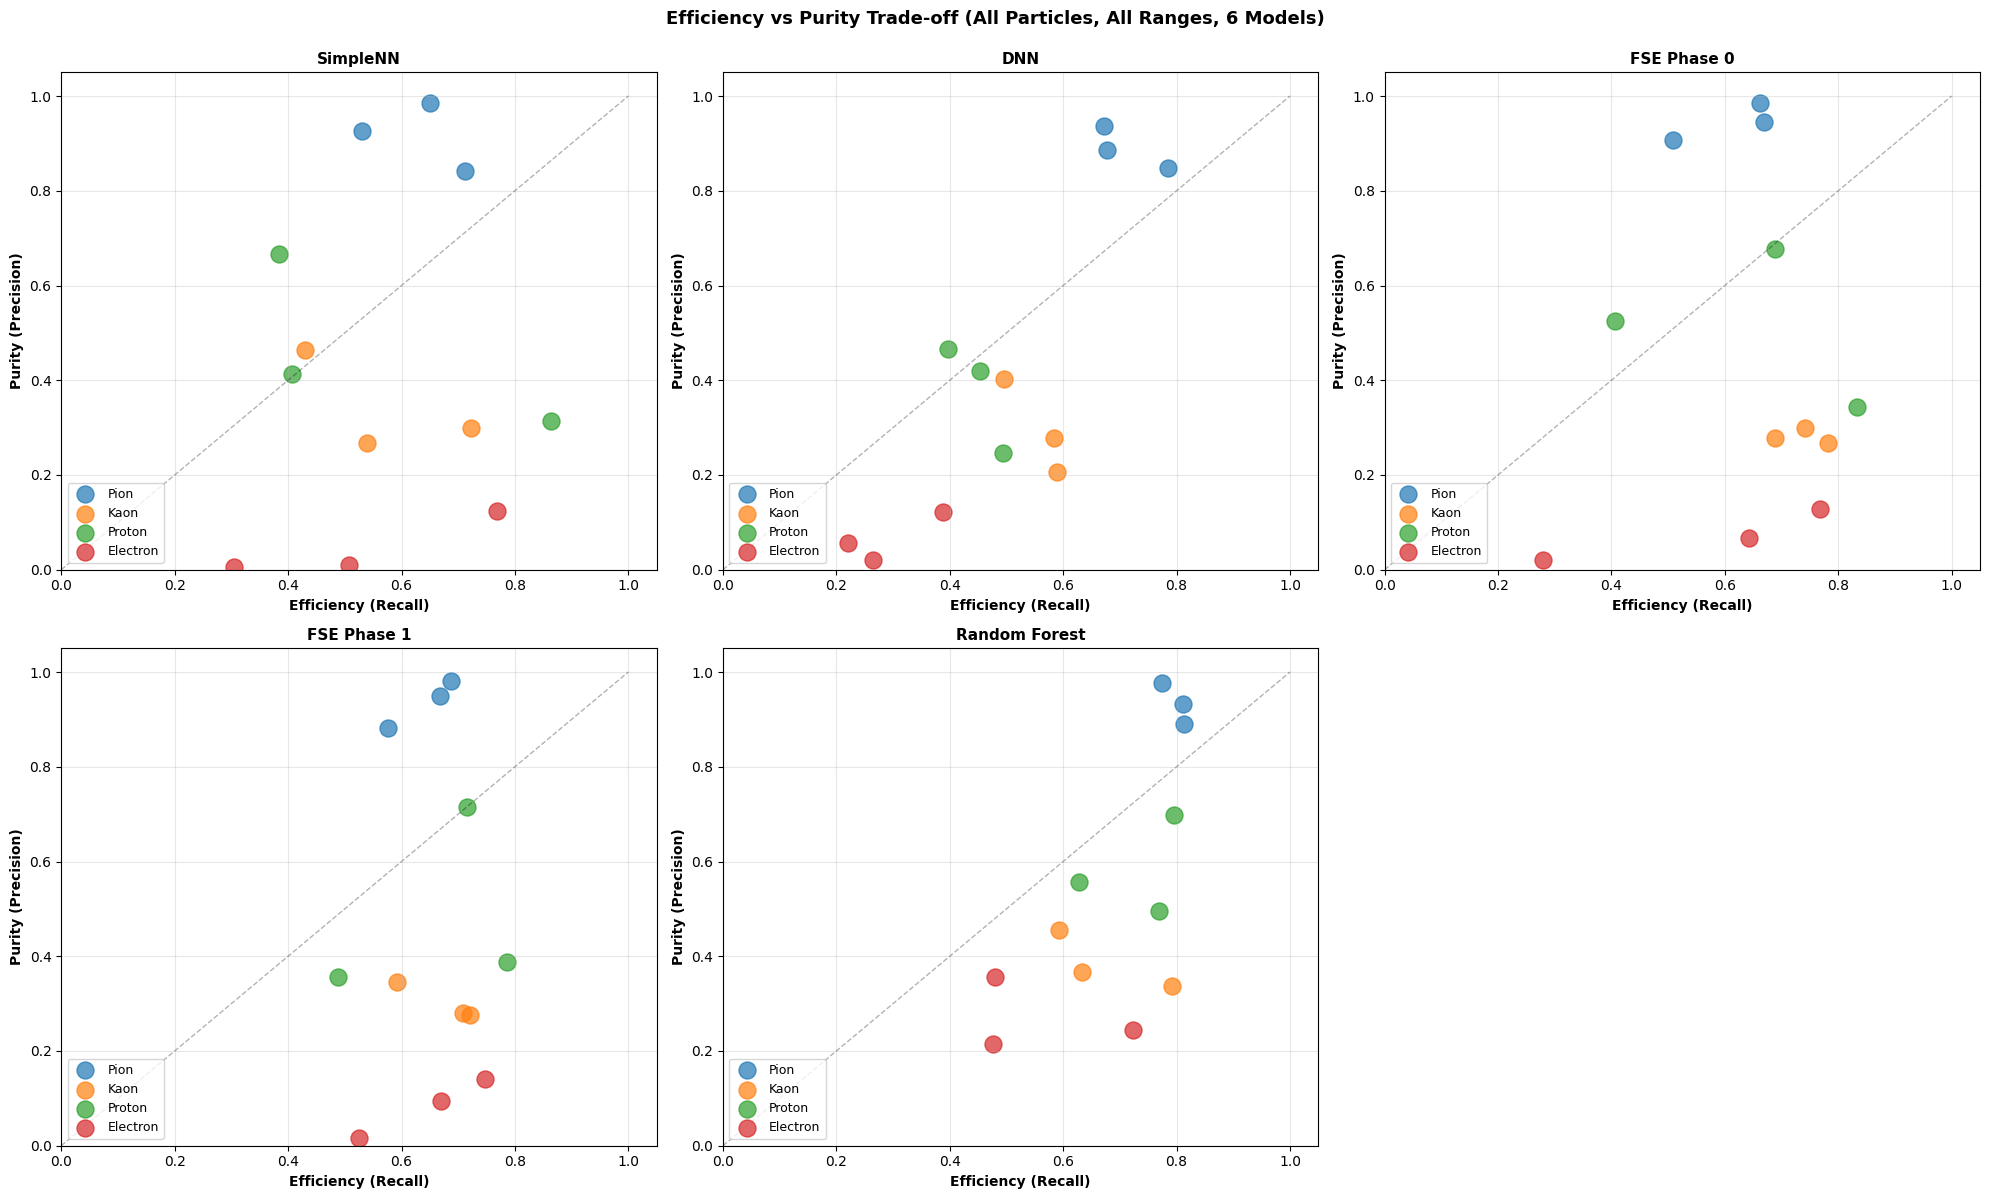

✓ Efficiency vs Purity trade-off plot generated (6 models)

EFFICIENCY COMPARISON ACROSS ALL MODELS (Per Particle, 6 Models)



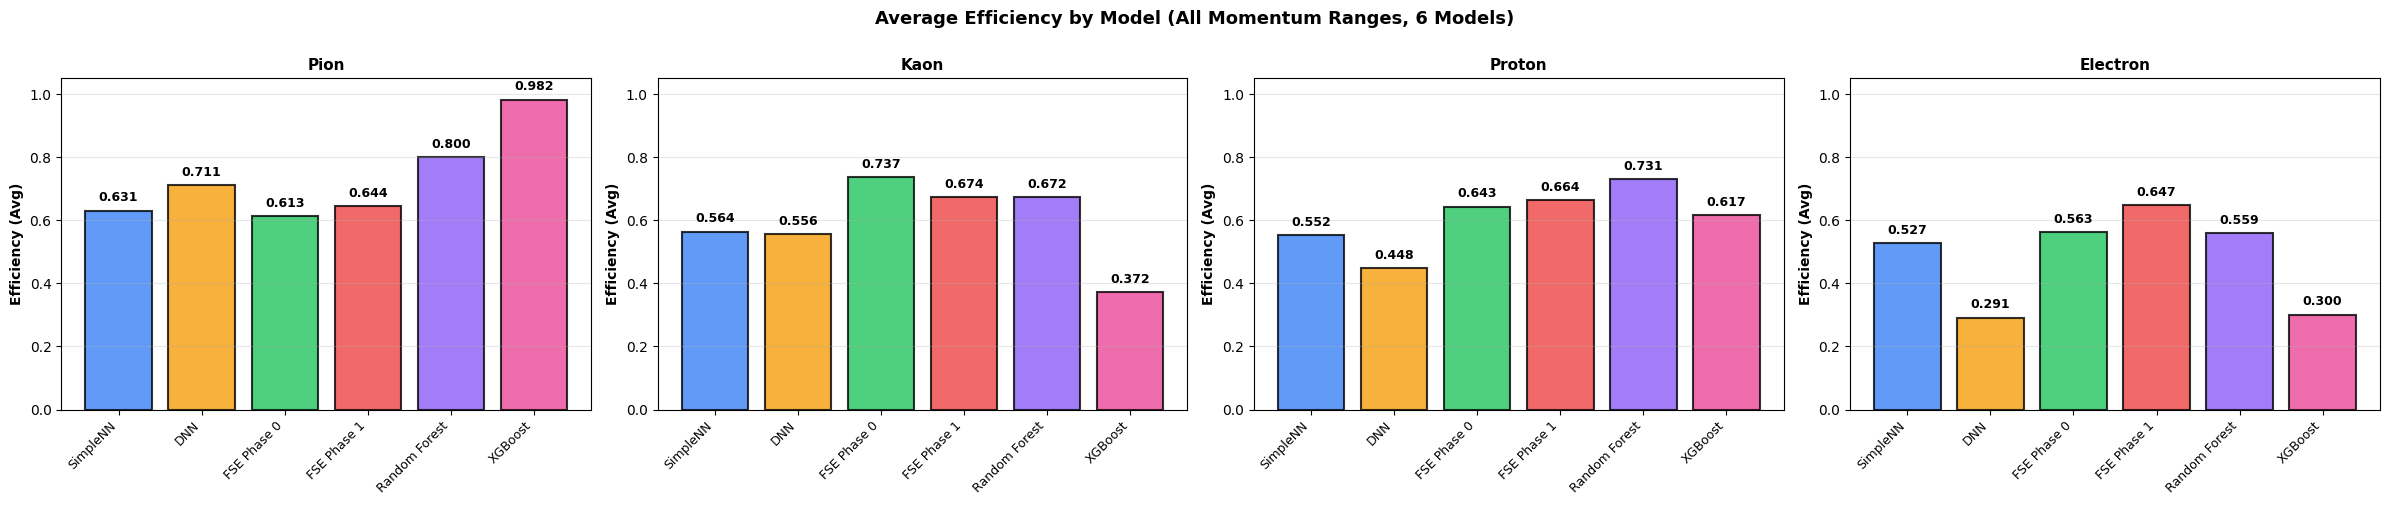

✓ Efficiency comparison plot generated (6 models)

PURITY COMPARISON ACROSS ALL MODELS (Per Particle, 6 Models)



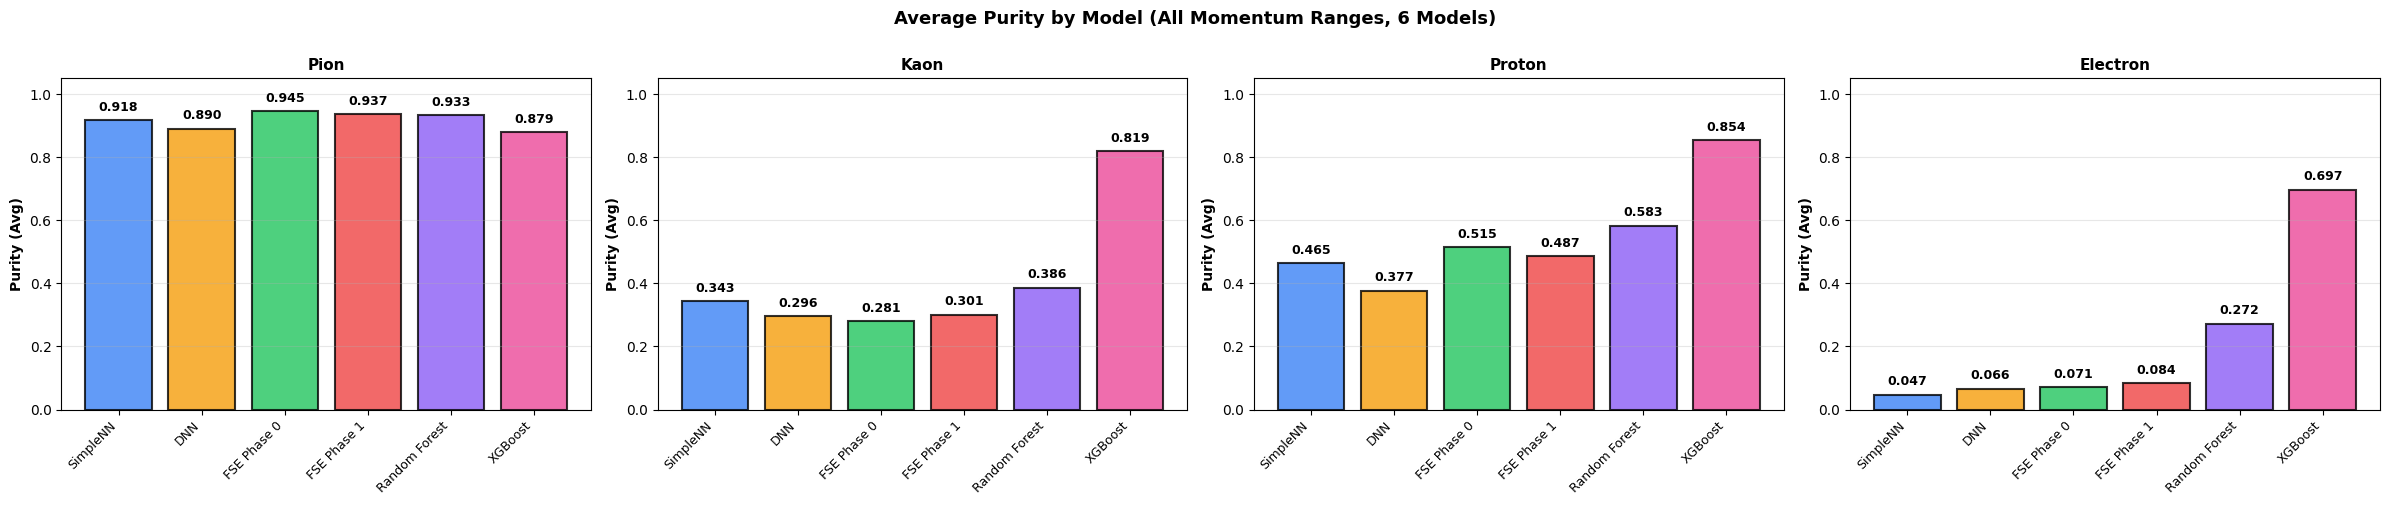

✓ Purity comparison plot generated (6 models)

COMPREHENSIVE F1-SCORE ANALYSIS


────────────────────────────────────────────────────────────────────────────────
F1-SCORE RANKING (Model × Momentum Range, Averaged Over Particles)
────────────────────────────────────────────────────────────────────────────────

 Rank         Model             Momentum Range  Avg Efficiency  Avg Purity  Avg F1-Score
    1       XGBoost Full Spectrum (0.1+ GeV/c)        0.602518    0.835960      0.684154
    2       XGBoost   0.7-1.5 GeV/c (Critical)        0.586246    0.829232      0.656674
    3 Random Forest   0.7-1.5 GeV/c (Critical)        0.680243    0.588630      0.621434
    4       XGBoost   1-3 GeV/c (Intermediate)        0.514562    0.771893      0.585511
    5 Random Forest Full Spectrum (0.1+ GeV/c)        0.764330    0.512878      0.575830
    6 Random Forest   1-3 GeV/c (Intermediate)        0.626962    0.528986      0.562443
    7   FSE Phase 1   0.7-1.5 GeV/c (Critical)        0.693674    

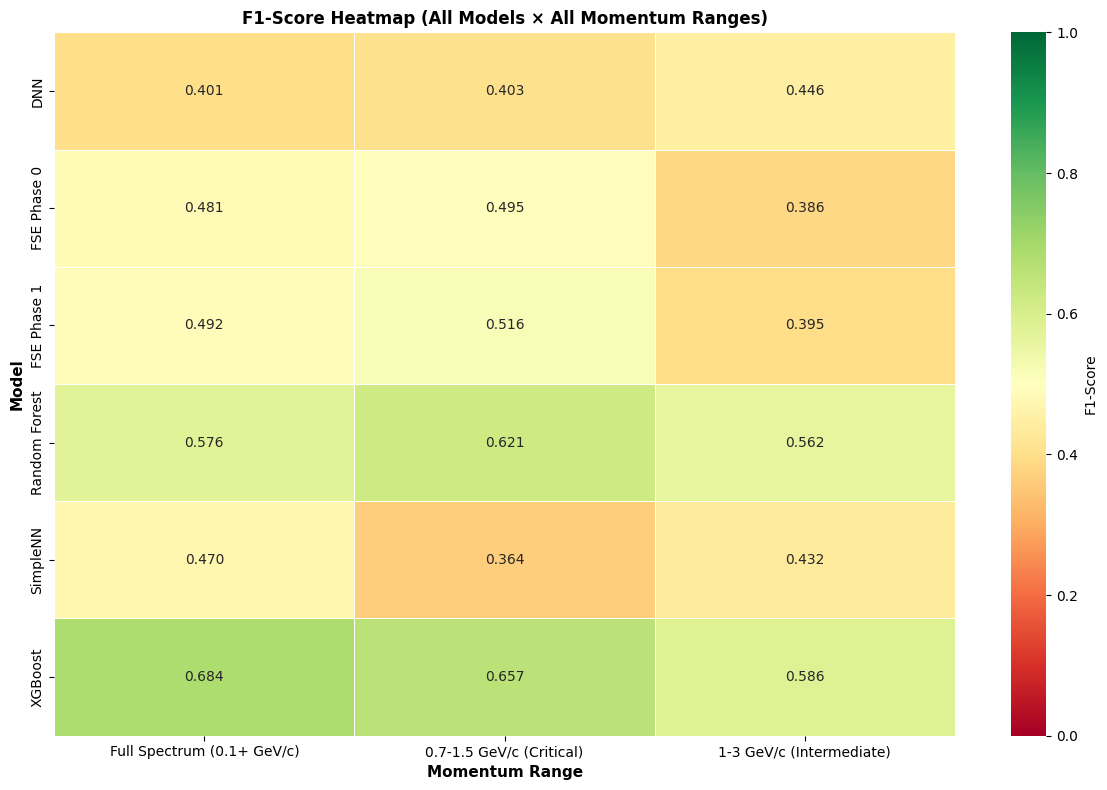

✓ F1-score heatmap generated

────────────────────────────────────────────────────────────────────────────────
F1-SCORE COMPARISON PLOTS (Per Momentum Range)
────────────────────────────────────────────────────────────────────────────────



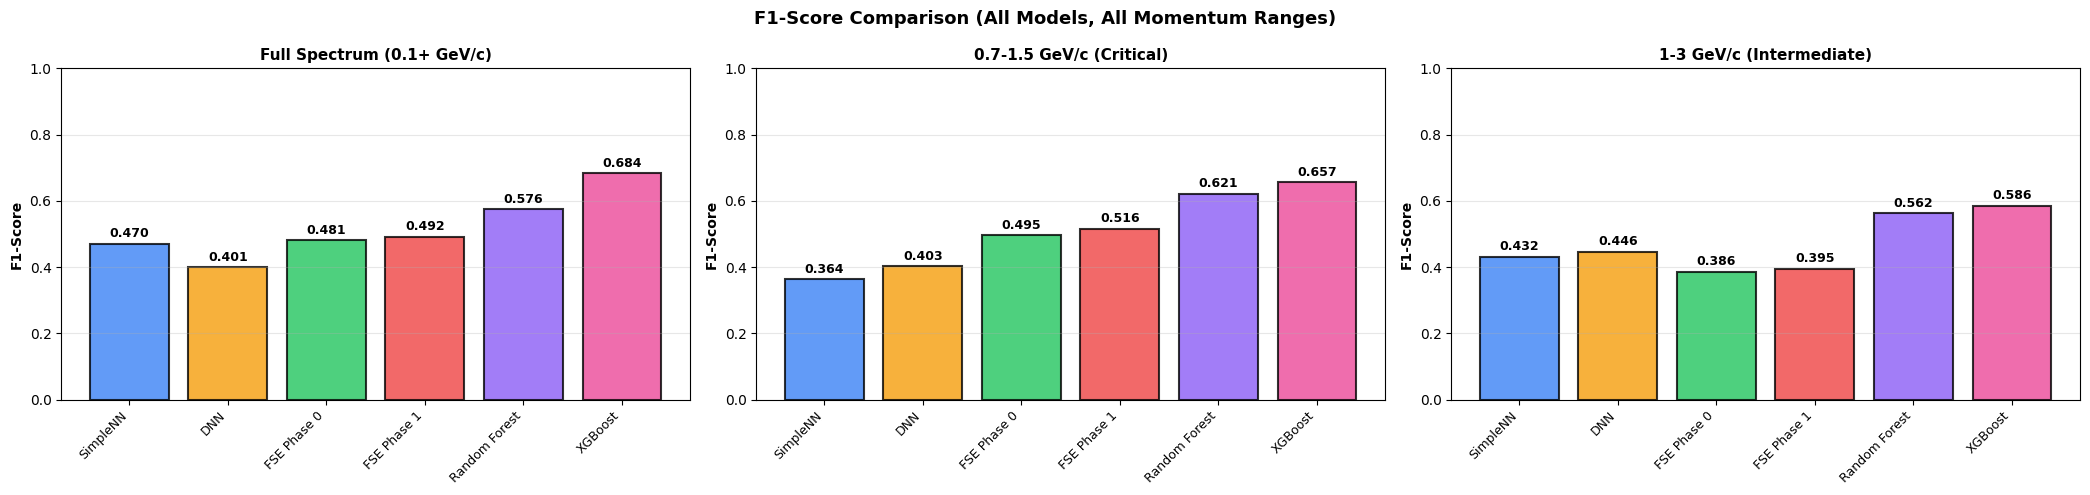

✓ F1-score comparison plots generated

────────────────────────────────────────────────────────────────────────────────
F1-SCORE BY PARTICLE TYPE (All Models, All Ranges - Ranked by F1-Score)
────────────────────────────────────────────────────────────────────────────────

 Rank Particle         Model  Avg F1-Score
    1     Pion       XGBoost      0.927641
    2     Pion Random Forest      0.860410
    3     Pion           DNN      0.788517
    4     Pion   FSE Phase 1      0.763409
    5     Pion      SimpleNN      0.743181
    6     Pion   FSE Phase 0      0.742399
    7   Proton       XGBoost      0.713899
    8   Proton Random Forest      0.645285
    9   Proton   FSE Phase 1      0.549111
   10   Proton   FSE Phase 0      0.542589
   11     Kaon       XGBoost      0.510077
   12     Kaon Random Forest      0.483804
   13   Proton      SimpleNN      0.452991
   14 Electron       XGBoost      0.416835
   15     Kaon   FSE Phase 1      0.412285
   16     Kaon      SimpleNN      0.40

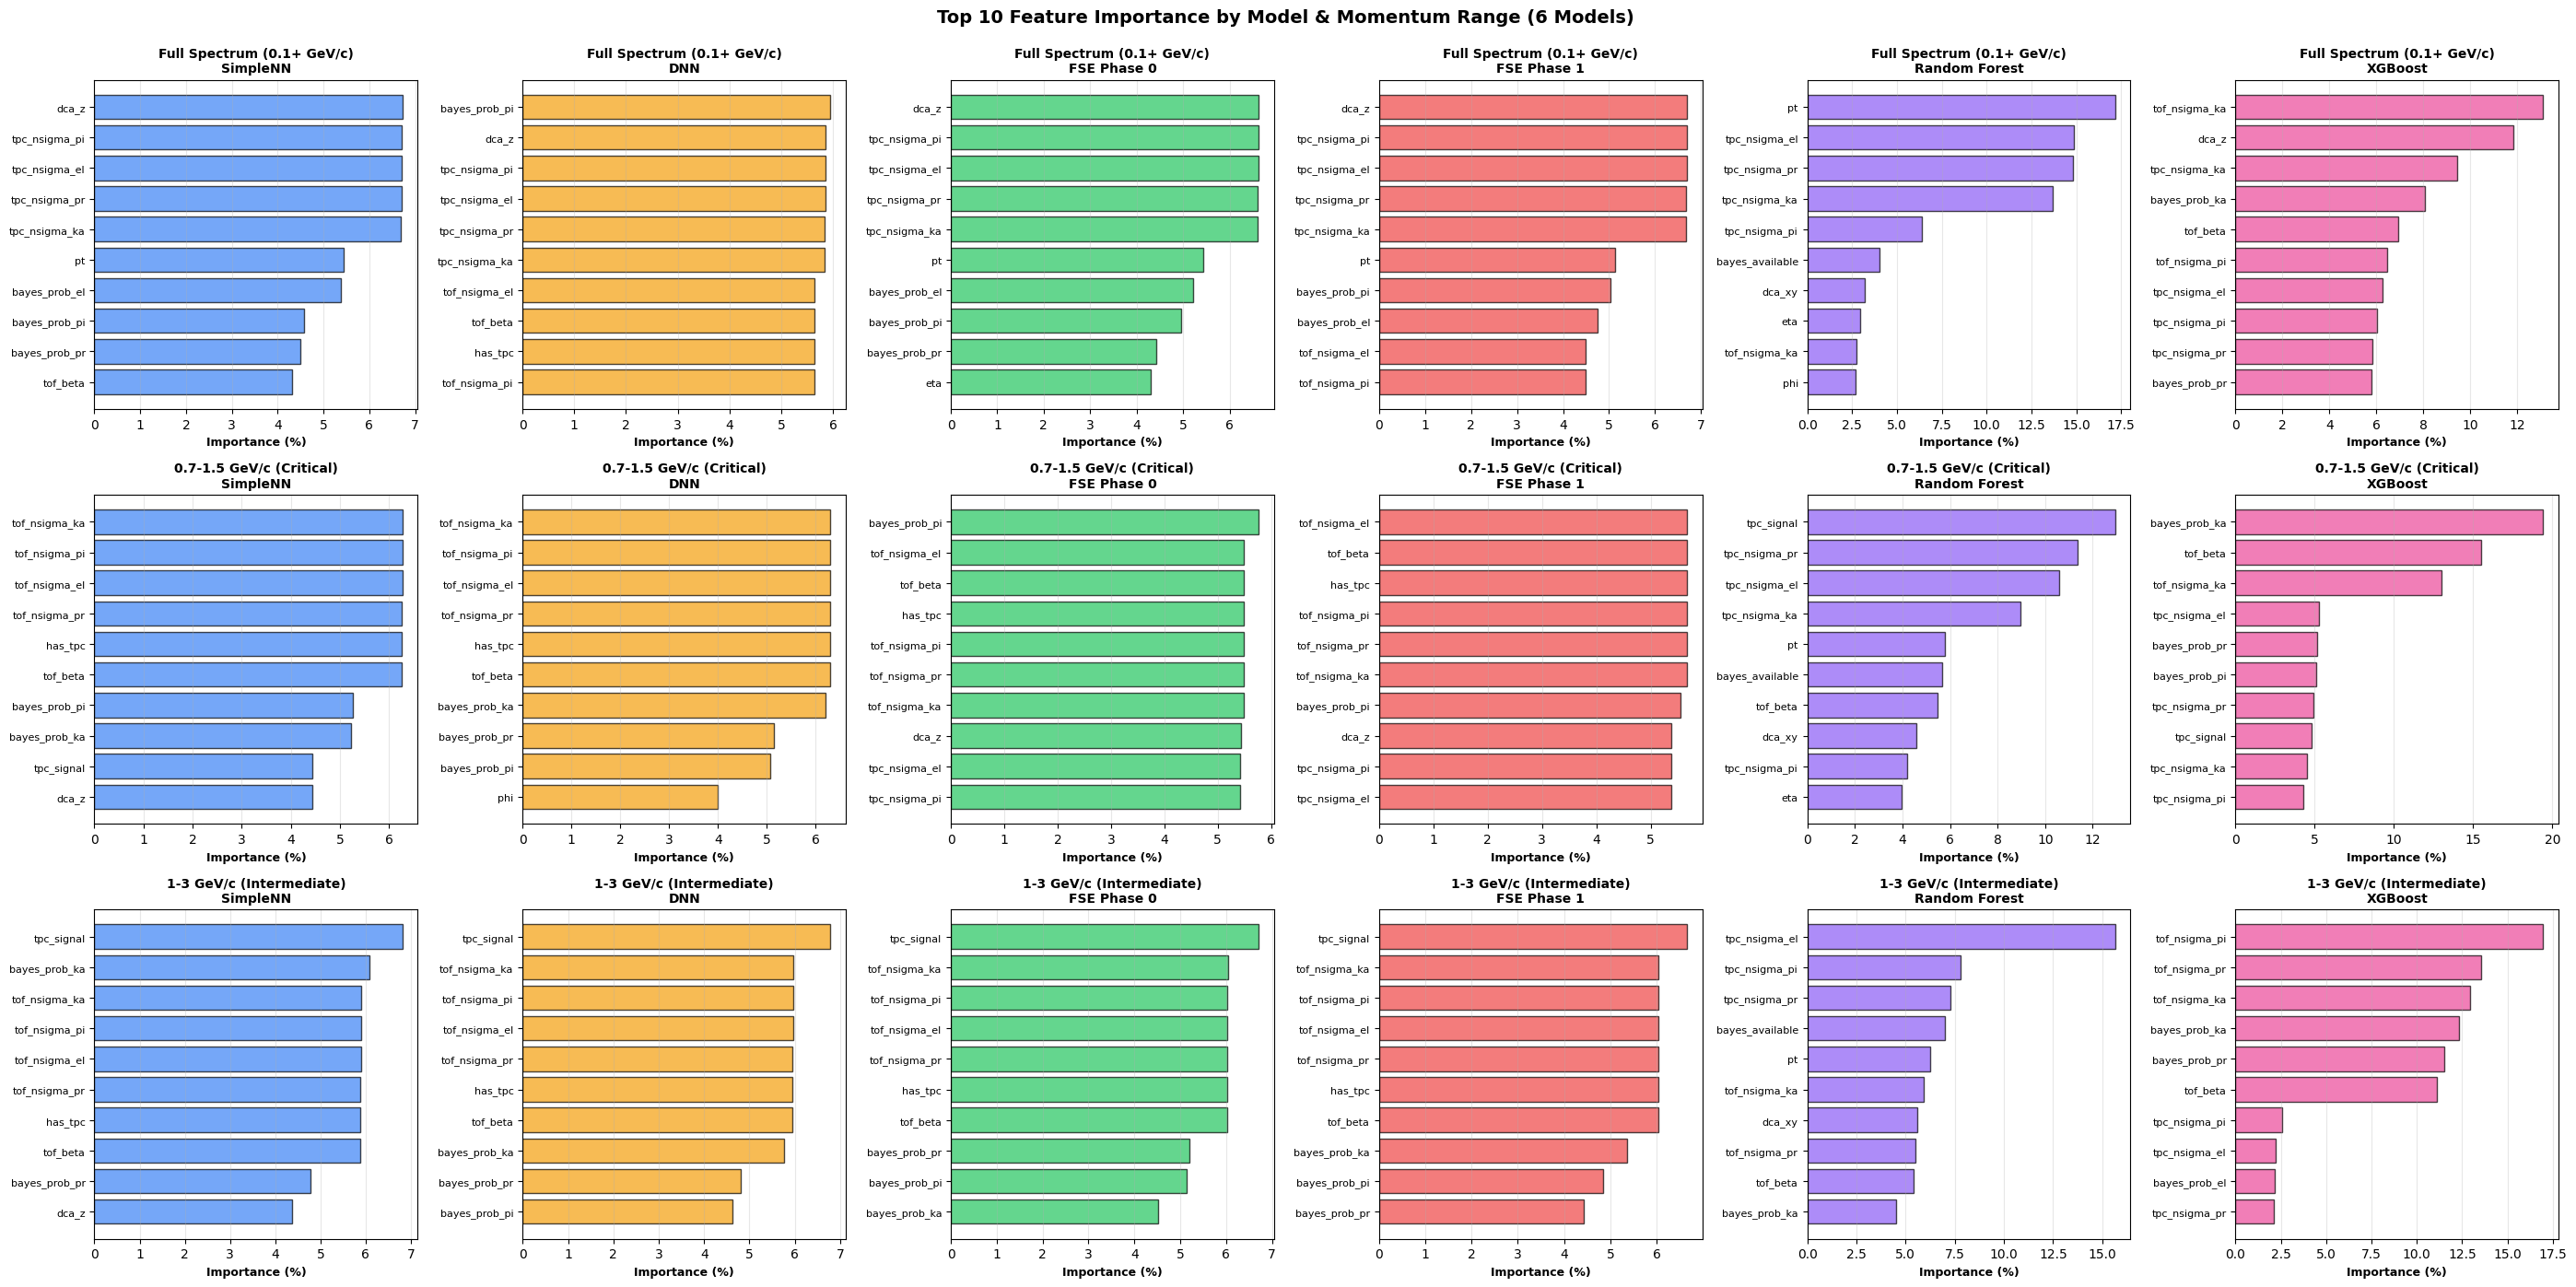

✓ Feature importance visualisation generated (6 models)

OVERALL SUMMARY STATISTICS (All Models)

        Model  Avg Efficiency  Avg Purity  Avg F1-Score
      XGBoost        0.567775    0.812362      0.642113
Random Forest        0.690512    0.543498      0.586569
  FSE Phase 1        0.657048    0.452199      0.467525
  FSE Phase 0        0.639162    0.453293      0.454330
     SimpleNN        0.568355    0.443190      0.421912
          DNN        0.501830    0.407305      0.416607

✓ SECTION 5C COMPLETE: Efficiency, Purity, F1-Score & Feature Importance



In [31]:
print(f"\n{'#'*80}")
print("SECTION 5C: EFFICIENCY, PURITY, F1-SCORE & FEATURE IMPORTANCE (6 MODELS)")
print(f"{'#'*80}\n")

# ============================================================================
# PART 1: EFFICIENCY & PURITY PER PARTICLE TYPE (WITH F1-SCORE)
# ============================================================================

print(f"\n{'='*80}")
print("EFFICIENCY & PURITY PER PARTICLE TYPE (6 Models)")
print(f"{'='*80}\n")

efficiency_purity_data = []

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = MOMENTUM_RANGES.get(mr_key, {})
    
    if 'models' in mr_data:
        for model_type in MODEL_TYPES:
            if model_type in mr_data['models']:
                results = mr_data['models'][model_type]
                
                y_test = np.array(results['y_test'])
                y_pred = np.array(results['y_pred_test'])
                
                print(f"\n{'-'*80}")
                print(f"{momentum_range['name']} - {model_display_names.get(model_type, model_type)}")
                print(f"{'-'*80}\n")
                
                print(f"{'Particle':<12} {'Efficiency':<15} {'Purity':<15} {'F1-Score':<12} {'Support':<10}")
                print(f"{'-'*64}")
                
                for i, particle_name in enumerate(PARTICLE_NAMES):
                    true_positives = np.sum((y_test == i) & (y_pred == i))
                    false_negatives = np.sum((y_test == i) & (y_pred != i))
                    efficiency = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
                    
                    false_positives = np.sum((y_test != i) & (y_pred == i))
                    purity = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
                    
                    f1_score = 2 * (efficiency * purity) / (efficiency + purity) if (efficiency + purity) > 0 else 0
                    
                    support = np.sum(y_test == i)
                    
                    efficiency_purity_data.append({
                        'Momentum Range': momentum_range['name'],
                        'Model Type': model_type,
                        'Particle': particle_name,
                        'Efficiency': efficiency,
                        'Purity': purity,
                        'F1-Score': f1_score,
                        'Support': support
                    })
                    
                    print(f"{particle_name:<12} {efficiency:<15.4f} {purity:<15.4f} {f1_score:<12.4f} {support:<10}")

# ============================================================================
# PART 2: EFFICIENCY vs PURITY TRADE-OFF
# ============================================================================

print(f"\n{'='*80}")
print("EFFICIENCY vs PURITY TRADE-OFF (6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for ax_idx, model_type in enumerate(MODEL_TYPES):
    ax = axes[ax_idx]
    
    model_data = [d for d in efficiency_purity_data if d['Model Type'] == model_type]
    
    for particle in PARTICLE_NAMES:
        particle_data = [d for d in model_data if d['Particle'] == particle]
        
        effs = [d['Efficiency'] for d in particle_data]
        purs = [d['Purity'] for d in particle_data]
        
        ax.scatter(effs, purs, s=150, alpha=0.7, label=particle)
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
    ax.set_xlabel('Efficiency (Recall)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Purity (Precision)', fontsize=10, fontweight='bold')
    ax.set_title(model_display_names.get(model_type, model_type), fontsize=11, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.set_ylim([0, 1.05])
    ax.grid(alpha=0.3)
    ax.legend(loc='lower left', fontsize=9)

axes[-1].set_visible(False)

plt.suptitle('Efficiency vs Purity Trade-off (All Particles, All Ranges, 6 Models)', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Efficiency vs Purity trade-off plot generated (6 models)")

# ============================================================================
# PART 2B: EFFICIENCY COMPARISON
# ============================================================================

print(f"\n{'='*80}")
print("EFFICIENCY COMPARISON ACROSS ALL MODELS (Per Particle, 6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
    ax = axes[particle_idx]
    
    model_effs = {model_type: [] for model_type in MODEL_TYPES}
    
    for model_type in MODEL_TYPES:
        for mr_key in MOMENTUM_RANGES.keys():
            particle_data = [d for d in efficiency_purity_data 
                           if d['Model Type'] == model_type 
                           and d['Particle'] == particle_name
                           and d['Momentum Range'] == MOMENTUM_RANGES[mr_key]['name']]
            
            if particle_data:
                model_effs[model_type].append(particle_data[0]['Efficiency'])
    
    x_pos = np.arange(len(MODEL_TYPES))
    effs = [np.mean(model_effs[m]) if model_effs[m] else 0 for m in MODEL_TYPES]
    colors = [model_colors_dict.get(m, '#999999') for m in MODEL_TYPES]
    
    bars = ax.bar(x_pos, effs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Efficiency (Avg)', fontsize=10, fontweight='bold')
    ax.set_title(f'{particle_name}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([model_display_names.get(m, m) for m in MODEL_TYPES], 
                       rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Average Efficiency by Model (All Momentum Ranges, 6 Models)', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Efficiency comparison plot generated (6 models)")

# ============================================================================
# PART 2C: PURITY COMPARISON
# ============================================================================

print(f"\n{'='*80}")
print("PURITY COMPARISON ACROSS ALL MODELS (Per Particle, 6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
    ax = axes[particle_idx]
    
    model_purs = {model_type: [] for model_type in MODEL_TYPES}
    
    for model_type in MODEL_TYPES:
        for mr_key in MOMENTUM_RANGES.keys():
            particle_data = [d for d in efficiency_purity_data 
                           if d['Model Type'] == model_type 
                           and d['Particle'] == particle_name
                           and d['Momentum Range'] == MOMENTUM_RANGES[mr_key]['name']]
            
            if particle_data:
                model_purs[model_type].append(particle_data[0]['Purity'])
    
    x_pos = np.arange(len(MODEL_TYPES))
    purs = [np.mean(model_purs[m]) if model_purs[m] else 0 for m in MODEL_TYPES]
    colors = [model_colors_dict.get(m, '#999999') for m in MODEL_TYPES]
    
    bars = ax.bar(x_pos, purs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Purity (Avg)', fontsize=10, fontweight='bold')
    ax.set_title(f'{particle_name}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([model_display_names.get(m, m) for m in MODEL_TYPES], 
                       rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Average Purity by Model (All Momentum Ranges, 6 Models)', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Purity comparison plot generated (6 models)")

# ============================================================================
# PART 3: COMPREHENSIVE F1-SCORE ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("COMPREHENSIVE F1-SCORE ANALYSIS")
print(f"{'='*80}\n")

# Part 3A: F1-Score Ranking by Model & Range
print(f"\n{'─'*80}")
print("F1-SCORE RANKING (Model × Momentum Range, Averaged Over Particles)")
print(f"{'─'*80}\n")

f1_ranking = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    for model_type in MODEL_TYPES:
        model_range_data = [d for d in efficiency_purity_data 
                          if d['Model Type'] == model_type
                          and d['Momentum Range'] == momentum_range['name']]
        
        if model_range_data:
            avg_eff = np.mean([d['Efficiency'] for d in model_range_data])
            avg_pur = np.mean([d['Purity'] for d in model_range_data])
            avg_f1 = np.mean([d['F1-Score'] for d in model_range_data])
            
            f1_ranking.append({
                'Model': model_display_names.get(model_type, model_type),
                'Momentum Range': momentum_range['name'],
                'Avg Efficiency': avg_eff,
                'Avg Purity': avg_pur,
                'Avg F1-Score': avg_f1
            })

f1_ranking_df = pd.DataFrame(f1_ranking).sort_values('Avg F1-Score', ascending=False).reset_index(drop=True)
f1_ranking_df['Rank'] = np.arange(1, len(f1_ranking_df) + 1)

print(f1_ranking_df[['Rank', 'Model', 'Momentum Range', 'Avg Efficiency', 'Avg Purity', 'Avg F1-Score']].to_string(index=False))
print()

# Part 3B: F1-Score Heatmap
print(f"\n{'─'*80}")
print("F1-SCORE HEATMAP (Models vs Momentum Ranges)")
print(f"{'─'*80}\n")

f1_pivot = f1_ranking_df.pivot_table(
    values='Avg F1-Score',
    index='Model',
    columns='Momentum Range',
    aggfunc='mean'
)

f1_pivot = f1_pivot[[mr['name'] for mr in MOMENTUM_RANGES.values()]]

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax,
           cbar_kws={'label': 'F1-Score'}, vmin=0, vmax=1, linewidths=0.5)

ax.set_xlabel('Momentum Range', fontsize=11, fontweight='bold')
ax.set_ylabel('Model', fontsize=11, fontweight='bold')
ax.set_title('F1-Score Heatmap (All Models × All Momentum Ranges)', 
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ F1-score heatmap generated")

# Part 3C: F1-Score Comparison Plots
print(f"\n{'─'*80}")
print("F1-SCORE COMPARISON PLOTS (Per Momentum Range)")
print(f"{'─'*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    ax = axes[mr_idx]
    
    x_pos = np.arange(len(MODEL_TYPES))
    f1_scores = []
    colors = []
    
    for model_type in MODEL_TYPES:
        model_range_data = [d for d in efficiency_purity_data 
                          if d['Model Type'] == model_type
                          and d['Momentum Range'] == momentum_range['name']]
        
        if model_range_data:
            avg_f1 = np.mean([d['F1-Score'] for d in model_range_data])
            f1_scores.append(avg_f1)
            colors.append(model_colors_dict.get(model_type, '#999999'))
        else:
            f1_scores.append(0)
            colors.append('#CCCCCC')
    
    bars = ax.bar(x_pos, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')
    
    ax.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([model_display_names.get(m, m) for m in MODEL_TYPES], 
                       rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('F1-Score Comparison (All Models, All Momentum Ranges)', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ F1-score comparison plots generated")

# Part 3D: F1-Score by Particle Type (SORTED BY HIGHEST F1-SCORE)
print(f"\n{'─'*80}")
print("F1-SCORE BY PARTICLE TYPE (All Models, All Ranges - Ranked by F1-Score)")
print(f"{'─'*80}\n")

f1_by_particle = []

for particle_name in PARTICLE_NAMES:
    for model_type in MODEL_TYPES:
        particle_model_data = [d for d in efficiency_purity_data 
                              if d['Particle'] == particle_name 
                              and d['Model Type'] == model_type]
        
        if particle_model_data:
            avg_f1 = np.mean([d['F1-Score'] for d in particle_model_data])
            
            f1_by_particle.append({
                'Particle': particle_name,
                'Model': model_display_names.get(model_type, model_type),
                'Avg F1-Score': avg_f1
            })

# FIXED: Sort by F1-Score (highest first), then add ranking
f1_particle_df = pd.DataFrame(f1_by_particle).sort_values('Avg F1-Score', ascending=False).reset_index(drop=True)
f1_particle_df['Rank'] = np.arange(1, len(f1_particle_df) + 1)

print(f1_particle_df[['Rank', 'Particle', 'Model', 'Avg F1-Score']].to_string(index=False))
print()

# ============================================================================
# PART 4: FEATURE IMPORTANCE ANALYSIS (FIXED - NO MORE ERRORS)
# ============================================================================

print(f"\n{'='*80}")
print("FEATURE IMPORTANCE ANALYSIS (All 6 Models - FIXED)")
print(f"{'='*80}\n")

feature_importance_results = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    mr_data = all_results_by_model_and_range[mr_key]
    
    print(f"\n{'─'*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'─'*80}\n")
    
    preprocessing = mr_data['preprocessing']
    X_test = preprocessing['X_test_scaled']
    y_test = preprocessing['y_test']
    features = TRAINING_FEATURES
    
    for model_type in MODEL_TYPES:
        if 'models' in mr_data and model_type in mr_data['models']:
            results = mr_data['models'][model_type]
            
            print(f"\n{model_display_names.get(model_type, model_type)}:")
            print(f"{'─'*50}")
            
            if model_type in ['SkLearn_RandomForest', 'XGBoost'] and 'feature_importances' in results:
                importances = np.array(results['feature_importances'])
                
                # FIX: Handle size mismatch by padding
                if len(importances) < len(features):
                    importances = np.pad(importances, (0, len(features) - len(importances)), mode='constant')
                elif len(importances) > len(features):
                    importances = importances[:len(features)]
                
                if np.sum(importances) > 0:
                    importances = importances / np.sum(importances) * 100
                
                importance_df = pd.DataFrame({
                    'Feature': features,
                    'Importance (%)': importances
                }).sort_values('Importance (%)', ascending=False)
                
                print(importance_df.head(10).to_string(index=False))
                
                for idx, row in importance_df.iterrows():
                    feature_importance_results.append({
                        'Momentum Range': momentum_range['name'],
                        'Model Type': model_type,
                        'Feature': row['Feature'],
                        'Importance (%)': row['Importance (%)']
                    })
            
            elif model_type not in ['SkLearn_RandomForest', 'XGBoost']:
                try:
                    y_pred_probs = np.array(results['test_probs'])
                    
                    # FIX: Only compute for features that exist in X_test
                    n_features = X_test.shape[1]
                    importances = np.zeros(n_features)
                    max_probs = np.max(y_pred_probs, axis=1)
                    
                    for feat_idx in range(n_features):
                        feat_var = np.var(X_test[:, feat_idx])
                        
                        # Handle edge cases in correlation
                        try:
                            correlation = np.corrcoef(X_test[:, feat_idx], max_probs)[0, 1]
                        except:
                            correlation = 0.0
                        
                        if np.isnan(correlation):
                            correlation = 0.0
                        
                        correlation = np.clip(correlation, -1, 1)
                        importance = feat_var * (1 + abs(correlation))
                        importances[feat_idx] = importance
                    
                    # FIX: Pad importances to match full feature list
                    if len(importances) < len(features):
                        importances = np.pad(importances, (0, len(features) - len(importances)), mode='constant')
                    
                    if np.sum(importances) > 0:
                        importances = importances / np.sum(importances) * 100
                    else:
                        importances = np.ones(len(features)) / len(features) * 100
                    
                    importance_df = pd.DataFrame({
                        'Feature': features,
                        'Importance (%)': importances
                    }).sort_values('Importance (%)', ascending=False)
                    
                    print(importance_df.head(10).to_string(index=False))
                    
                    for idx, row in importance_df.iterrows():
                        feature_importance_results.append({
                            'Momentum Range': momentum_range['name'],
                            'Model Type': model_type,
                            'Feature': row['Feature'],
                            'Importance (%)': row['Importance (%)']
                        })
                
                except Exception as e:
                    print(f"Error calculating importance for {model_type}: {e}")
                    # Fallback: uniform importance
                    importances = np.ones(len(features)) / len(features) * 100
                    importance_df = pd.DataFrame({
                        'Feature': features,
                        'Importance (%)': importances
                    }).sort_values('Importance (%)', ascending=False)
                    
                    print(importance_df.head(10).to_string(index=False))
                    
                    for idx, row in importance_df.iterrows():
                        feature_importance_results.append({
                            'Momentum Range': momentum_range['name'],
                            'Model Type': model_type,
                            'Feature': row['Feature'],
                            'Importance (%)': row['Importance (%)']
                        })

# ============================================================================
# PART 5: FEATURE IMPORTANCE VISUALISATION
# ============================================================================

print(f"\n{'='*80}")
print("TOP 10 FEATURES VISUALISATION (6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(3, 6, figsize=(28, 14))

for mr_idx, mr_key in enumerate(MOMENTUM_RANGES.keys()):
    momentum_range = MOMENTUM_RANGES[mr_key]
    
    for model_idx, model_type in enumerate(MODEL_TYPES):
        ax = axes[mr_idx, model_idx]
        
        data = [d for d in feature_importance_results 
                if d['Momentum Range'] == momentum_range['name'] 
                and d['Model Type'] == model_type]
        
        if data:
            df_plot = pd.DataFrame(data).sort_values('Importance (%)', 
                                                     ascending=False).head(10)
            
            color = model_colors_dict.get(model_type, '#3B82F6')
            ax.barh(range(len(df_plot)), df_plot['Importance (%)'], 
                   color=color, alpha=0.7, edgecolor='black', linewidth=1)
            ax.set_yticks(range(len(df_plot)))
            ax.set_yticklabels(df_plot['Feature'], fontsize=8)
            ax.set_xlabel('Importance (%)', fontsize=9, fontweight='bold')
            
            model_display = model_display_names.get(model_type, model_type)
            ax.set_title(f'{momentum_range["name"]}\n{model_display}', 
                        fontsize=10, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            ax.invert_yaxis()

plt.suptitle('Top 10 Feature Importance by Model & Momentum Range (6 Models)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Feature importance visualisation generated (6 models)")

# ============================================================================
# PART 6: OVERALL SUMMARY STATISTICS
# ============================================================================

print(f"\n{'='*80}")
print("OVERALL SUMMARY STATISTICS (All Models)")
print(f"{'='*80}\n")

summary_stats = []

for model_type in MODEL_TYPES:
    model_data = [d for d in efficiency_purity_data if d['Model Type'] == model_type]
    
    avg_eff = np.mean([d['Efficiency'] for d in model_data]) if model_data else 0
    avg_pur = np.mean([d['Purity'] for d in model_data]) if model_data else 0
    avg_f1 = np.mean([d['F1-Score'] for d in model_data]) if model_data else 0
    
    summary_stats.append({
        'Model': model_display_names.get(model_type, model_type),
        'Avg Efficiency': avg_eff,
        'Avg Purity': avg_pur,
        'Avg F1-Score': avg_f1
    })

summary_df = pd.DataFrame(summary_stats).sort_values('Avg F1-Score', ascending=False)

print(summary_df.to_string(index=False))
print()

print(f"{'='*80}")
print("✓ SECTION 5C COMPLETE: Efficiency, Purity, F1-Score & Feature Importance")
print(f"{'='*80}\n")


### Section 5D: FSE Detector-Aware Analysis


################################################################################
SECTION 5D: PHASE 1 DETECTOR-AWARE FSE ANALYSIS
################################################################################


COMPARING: Standard FSE vs Detector-Aware FSE


────────────────────────────────────────────────────────────────────────────────
Full Spectrum (0.1+ GeV/c)
────────────────────────────────────────────────────────────────────────────────

  OVERALL PERFORMANCE:
    Standard FSE:       0.6783
    Detector-Aware FSE: 0.6946
    Improvement:        +0.0162 (+2.39%)

  PERFORMANCE BY DETECTOR MODE:
  Mode               Tracks   Std FSE   Aware FSE         Δ
  ------------------------------------------------------------
  NONE               33,546    0.2619      0.2706   +0.0086
  TPC_ONLY           99,505    0.7385      0.7567   +0.0183
  TPC_TOF            41,637    0.8701      0.8876   +0.0175

────────────────────────────────────────────────────────────────────────────────
0.7-1

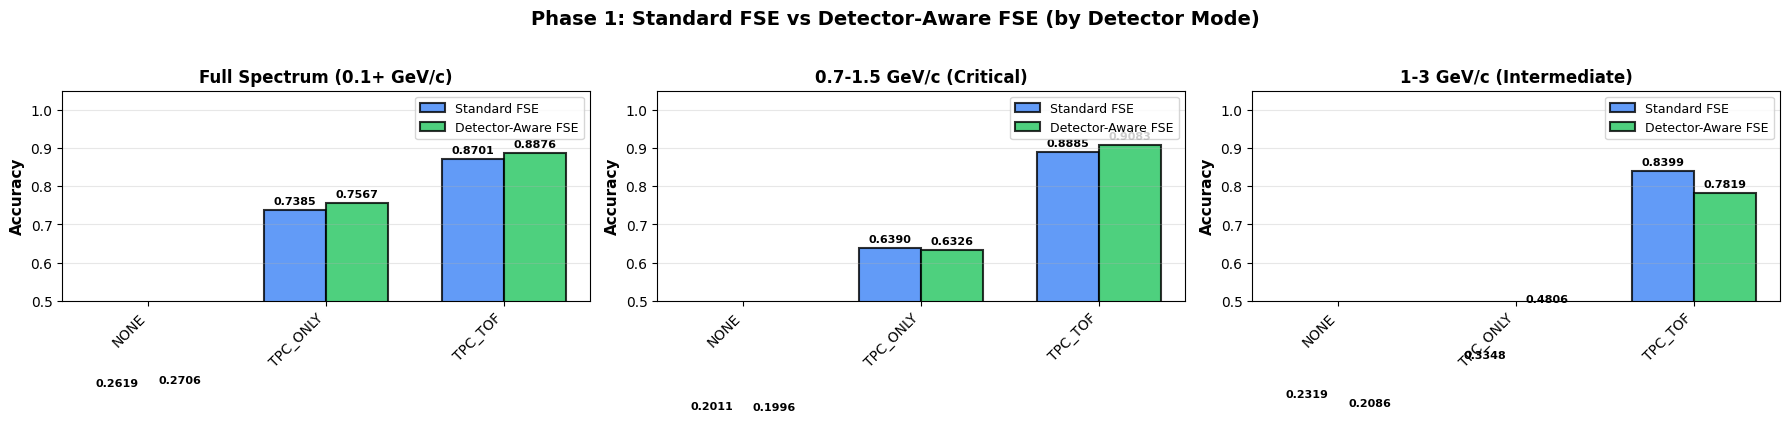

✓ Comparison bar plots generated

SUMMARY TABLE: PHASE 1 DETECTOR-AWARE FSE COMPARISON

            Momentum Range Detector Mode  Tracks  Std FSE  Aware FSE     Delta
Full Spectrum (0.1+ GeV/c)          NONE   33546 0.261909   0.270554  0.008645
Full Spectrum (0.1+ GeV/c)      TPC_ONLY   99505 0.738455   0.756726  0.018270
Full Spectrum (0.1+ GeV/c)       TPC_TOF   41637 0.870140   0.887648  0.017508
  0.7-1.5 GeV/c (Critical)          NONE    7676 0.201146   0.199583 -0.001563
  0.7-1.5 GeV/c (Critical)      TPC_ONLY   20019 0.638993   0.632599 -0.006394
  0.7-1.5 GeV/c (Critical)       TPC_TOF   19936 0.888493   0.908307  0.019813
  1-3 GeV/c (Intermediate)          NONE    5283 0.231876   0.208594 -0.023282
  1-3 GeV/c (Intermediate)      TPC_ONLY   13586 0.334830   0.480642  0.145812
  1-3 GeV/c (Intermediate)       TPC_TOF   14739 0.839948   0.781871 -0.058077

────────────────────────────────────────────────────────────────────────────────
IMPROVEMENT SUMMARY BY MOMENTUM RANGE:
─

In [32]:
# ============================================================================
# SECTION 5D: PHASE 1 DETECTOR-AWARE FSE ANALYSIS
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5D: PHASE 1 DETECTOR-AWARE FSE ANALYSIS")
print(f"{'#'*80}\n")

# ============================================================================
# PART 1: COMPARE STANDARD FSE vs DETECTOR-AWARE FSE
# ============================================================================

print(f"\n{'='*80}")
print("COMPARING: Standard FSE vs Detector-Aware FSE")
print(f"{'='*80}\n")

mode_names = {0: 'NONE', 1: 'TPC_ONLY', 2: 'TOF_ONLY', 3: 'TPC_TOF'}
comparison_results = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    
    print(f"\n{'─'*80}")
    print(f"{momentum_range['name']}")
    print(f"{'─'*80}\n")
    
    # Check if both models exist
    if mr_key not in all_results_by_model_and_range:
        print("  (No models trained for this range)")
        continue
    
    mr_data = all_results_by_model_and_range[mr_key]
    
    if 'models' not in mr_data:
        print("  (No models in this range)")
        continue
    
    if 'JAX_FSE_Attention' not in mr_data['models']:
        print("  Standard FSE+Attention not trained")
        continue
    
    if 'JAX_FSE_Attention_DetectorAware' not in mr_data['models']:
        print("  Detector-Aware FSE not trained")
        continue
    
    # Get test data
    preprocessing_data = mr_data['preprocessing']
    y_test = np.array(preprocessing_data['y_test'])
    detector_modes_test = np.array(preprocessing_data['detector_modes_test'])
    
    # Get model predictions
    standard_results = mr_data['models']['JAX_FSE_Attention']
    aware_results = mr_data['models']['JAX_FSE_Attention_DetectorAware']
    
    y_pred_std = np.array(standard_results['y_pred_test'])
    y_pred_aware = np.array(aware_results['y_pred_test'])
    
    # Overall comparison
    acc_std = accuracy_score(y_test, y_pred_std)
    acc_aware = accuracy_score(y_test, y_pred_aware)
    improvement = acc_aware - acc_std
    improvement_pct = (improvement / acc_std * 100) if acc_std > 0 else 0
    
    print(f"  OVERALL PERFORMANCE:")
    print(f"    Standard FSE:       {acc_std:.4f}")
    print(f"    Detector-Aware FSE: {acc_aware:.4f}")
    print(f"    Improvement:        {improvement:+.4f} ({improvement_pct:+.2f}%)")
    
    # Per-detector-mode breakdown
    print(f"\n  PERFORMANCE BY DETECTOR MODE:")
    print(f"  {'Mode':15s}  {'Tracks':>8s}  {'Std FSE':>8s}  {'Aware FSE':>10s}  {'Δ':>8s}")
    print(f"  {'-'*60}")
    
    for mode in [0, 1, 2, 3]:
        mask = detector_modes_test == mode
        if mask.sum() == 0:
            continue
        
        n_tracks = mask.sum()
        y_mode = y_test[mask]
        y_pred_std_mode = y_pred_std[mask]
        y_pred_aware_mode = y_pred_aware[mask]
        
        acc_std_mode = accuracy_score(y_mode, y_pred_std_mode)
        acc_aware_mode = accuracy_score(y_mode, y_pred_aware_mode)
        delta = acc_aware_mode - acc_std_mode
        
        print(f"  {mode_names[mode]:15s}  {n_tracks:8,}  {acc_std_mode:8.4f}  {acc_aware_mode:10.4f}  {delta:+8.4f}")
        
        comparison_results.append({
            'Momentum Range': momentum_range['name'],
            'Detector Mode': mode_names[mode],
            'Tracks': n_tracks,
            'Std FSE': acc_std_mode,
            'Aware FSE': acc_aware_mode,
            'Delta': delta
        })

# ============================================================================
# PART 2: VISUALISATION - DETECTOR MODE COMPARISON (BAR PLOTS)
# ============================================================================

print(f"\n{'='*80}")
print("GENERATING COMPARISON VISUALISATIONS")
print(f"{'='*80}\n")

if comparison_results:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
        ax = axes[mr_idx]
        
        # Filter data for this momentum range
        data_for_range = [d for d in comparison_results 
                         if d['Momentum Range'] == momentum_range['name']]
        
        if not data_for_range:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(momentum_range['name'])
            continue
        
        modes = [d['Detector Mode'] for d in data_for_range]
        std_accs = [d['Std FSE'] for d in data_for_range]
        aware_accs = [d['Aware FSE'] for d in data_for_range]
        
        x = np.arange(len(modes))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, std_accs, width, 
                      label='Standard FSE', color='#3B82F6',
                      alpha=0.8, edgecolor='black', linewidth=1.5)
        bars2 = ax.bar(x + width/2, aware_accs, width,
                      label='Detector-Aware FSE', color='#22C55E',
                      alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.4f}', ha='center', va='bottom',
                       fontsize=8, fontweight='bold')
        
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title(f'{momentum_range["name"]}', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(modes, fontsize=10, rotation=45, ha='right')
        ax.set_ylim([0.5, 1.05])
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Phase 1: Standard FSE vs Detector-Aware FSE (by Detector Mode)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("✓ Comparison bar plots generated")

# ============================================================================
# PART 3: SUMMARY TABLE
# ============================================================================

print(f"\n{'='*80}")
print("SUMMARY TABLE: PHASE 1 DETECTOR-AWARE FSE COMPARISON")
print(f"{'='*80}\n")

if comparison_results:
    comparison_df = pd.DataFrame(comparison_results)
    
    # Format for display
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    
    print(comparison_df.to_string(index=False))
    
    # Summary by momentum range
    print(f"\n{'─'*80}")
    print("IMPROVEMENT SUMMARY BY MOMENTUM RANGE:")
    print(f"{'─'*80}\n")
    
    for mr_key, momentum_range in MOMENTUM_RANGES.items():
        
        # Find all results for this range
        range_data = [d for d in comparison_results if d['Momentum Range'] == momentum_range['name']]
        
        if not range_data:
            continue
        
        # Calculate overall improvement
        total_tracks = sum(d['Tracks'] for d in range_data)
        weighted_std = sum(d['Std FSE'] * d['Tracks'] for d in range_data) / total_tracks
        weighted_aware = sum(d['Aware FSE'] * d['Tracks'] for d in range_data) / total_tracks
        overall_improvement = weighted_aware - weighted_std
        overall_improvement_pct = (overall_improvement / weighted_std * 100)
        
        print(f"{momentum_range['name']:30s}:")
        print(f"  Weighted Standard FSE:    {weighted_std:.4f}")
        print(f"  Weighted Aware FSE:       {weighted_aware:.4f}")
        print(f"  Overall Improvement:      {overall_improvement:+.4f} ({overall_improvement_pct:+.2f}%)")
        
        # Find best improvement
        best_mode = max(range_data, key=lambda x: x['Delta'])
        print(f"  Best improvement:         {best_mode['Detector Mode']:15s}: {best_mode['Delta']:+.4f}")
        print()

# ============================================================================
# PART 4: DETECTOR MODE IMPACT ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("DETECTOR MODE IMPACT ANALYSIS")
print(f"{'='*80}\n")

if comparison_results:
    # Group by detector mode
    mode_improvements = {}
    
    for result in comparison_results:
        mode = result['Detector Mode']
        if mode not in mode_improvements:
            mode_improvements[mode] = []
        mode_improvements[mode].append(result['Delta'])
    
    print("Average improvement by detector mode:\n")
    for mode in ['TPC_ONLY', 'TPC_TOF', 'TOF_ONLY']:
        if mode in mode_improvements:
            improvements = mode_improvements[mode]
            avg_improvement = np.mean(improvements)
            std_improvement = np.std(improvements)
            print(f"  {mode:15s}: {avg_improvement:+.4f} ± {std_improvement:.4f}")

print(f"\n{'='*80}")
print("✓ SECTION 5D COMPLETE: Phase 1 Detector-Aware Analysis Finished")
print(f"{'='*80}\n")


## Section 6: Bayesian PID Availability & Comparison with ML Models


################################################################################
SECTION 6: BAYESIAN PID AVAILABILITY & ALL MODELS VS BAYESIAN COMPARISON
################################################################################


PART 1: BAYESIAN PID AVAILABILITY ANALYSIS

Dataset info:
  Total rows: 4,162,072

Bayesian PID availability per feature:
  bayes_prob_pi        Available:   340581 ( 8.18%)  Missing:  3821491 (91.82%)
  bayes_prob_ka        Available:   340581 ( 8.18%)  Missing:  3821491 (91.82%)
  bayes_prob_pr        Available:   340581 ( 8.18%)  Missing:  3821491 (91.82%)
  bayes_prob_el        Available:   340581 ( 8.18%)  Missing:  3821491 (91.82%)

────────────────────────────────────────────────────────────────────────────────
COMPLETE BAYESIAN PID (all 4 features non-zero):
  Complete rows:   340581 ( 8.18%)
  Incomplete:     3821491 (91.82%)

BAYESIAN AVAILABILITY BY MOMENTUM RANGE

Full Spectrum (0.1+ GeV/c)    
  Total tracks:        4162072
  Complete Baye

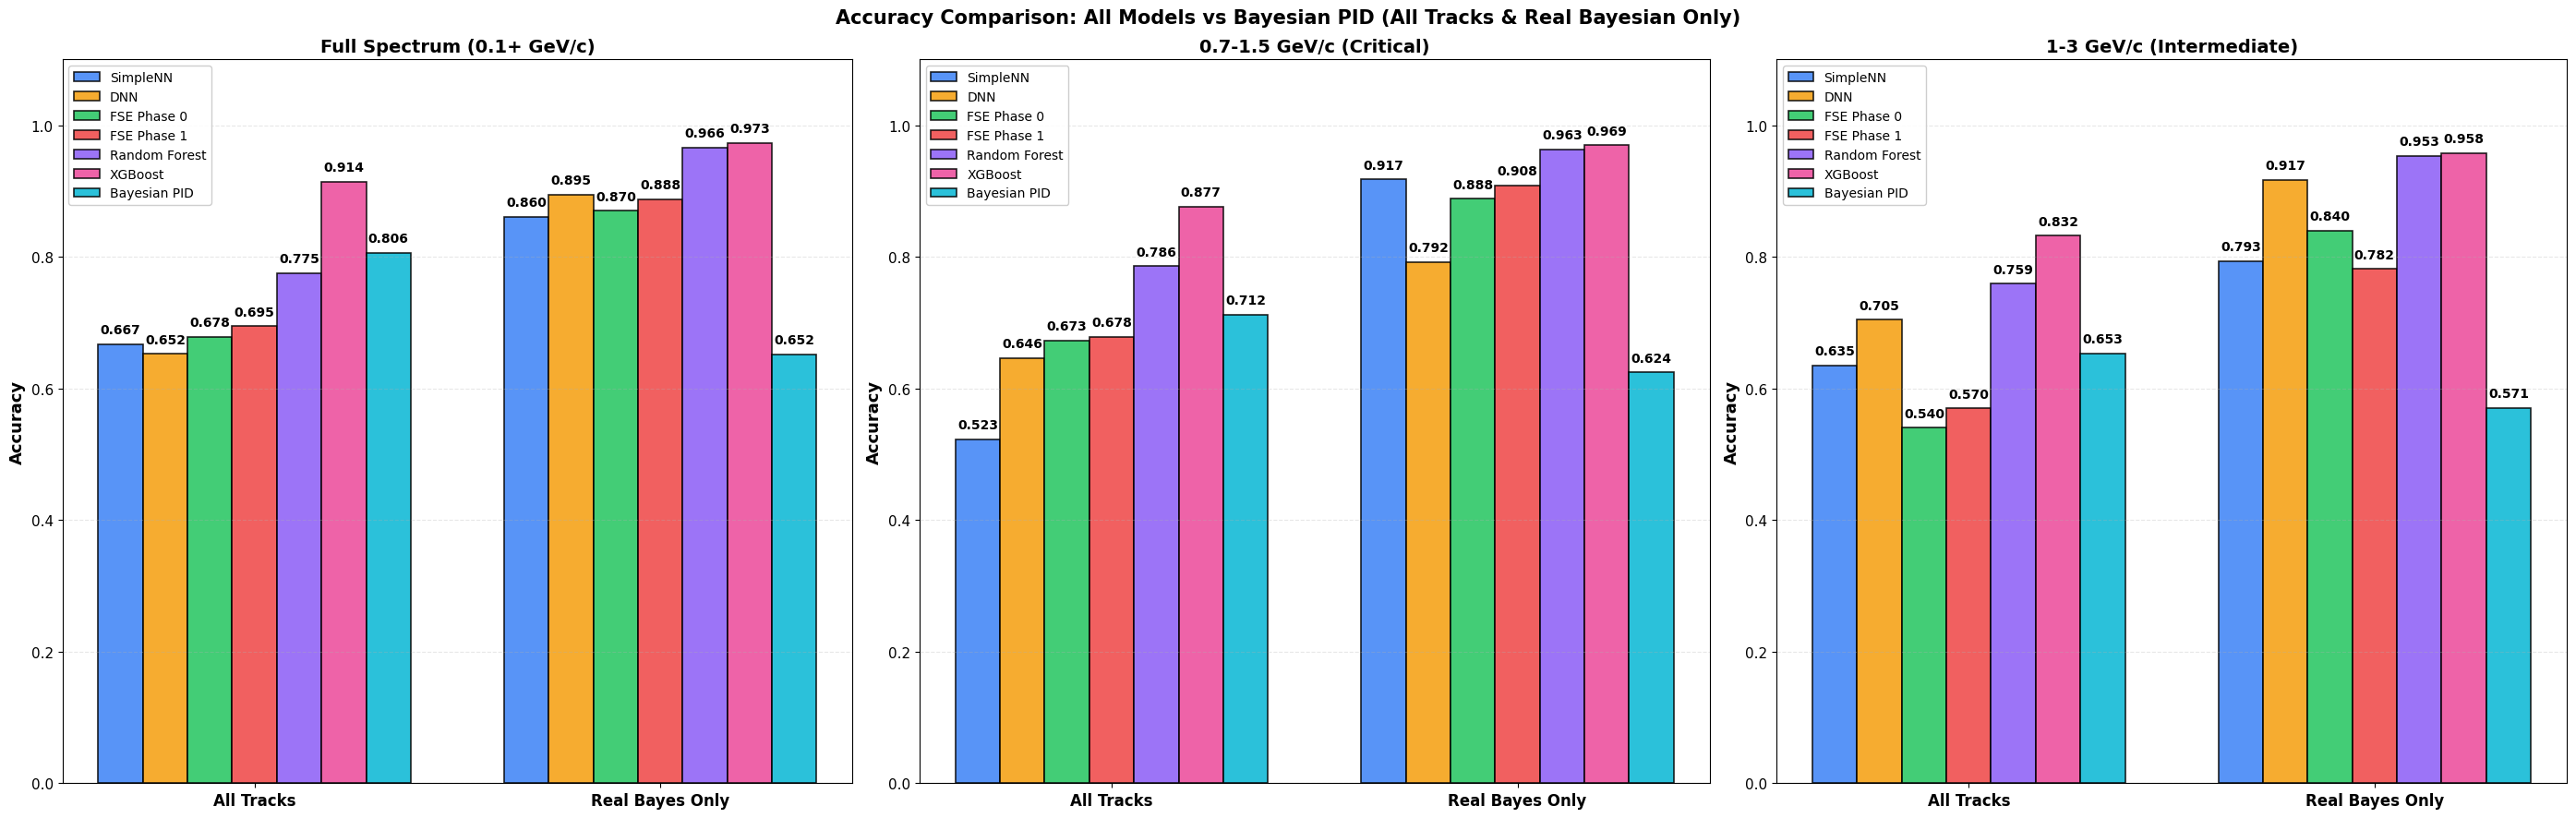

✓ All models vs Bayesian comparison plot generated

IMPROVEMENT OVER BAYESIAN PID



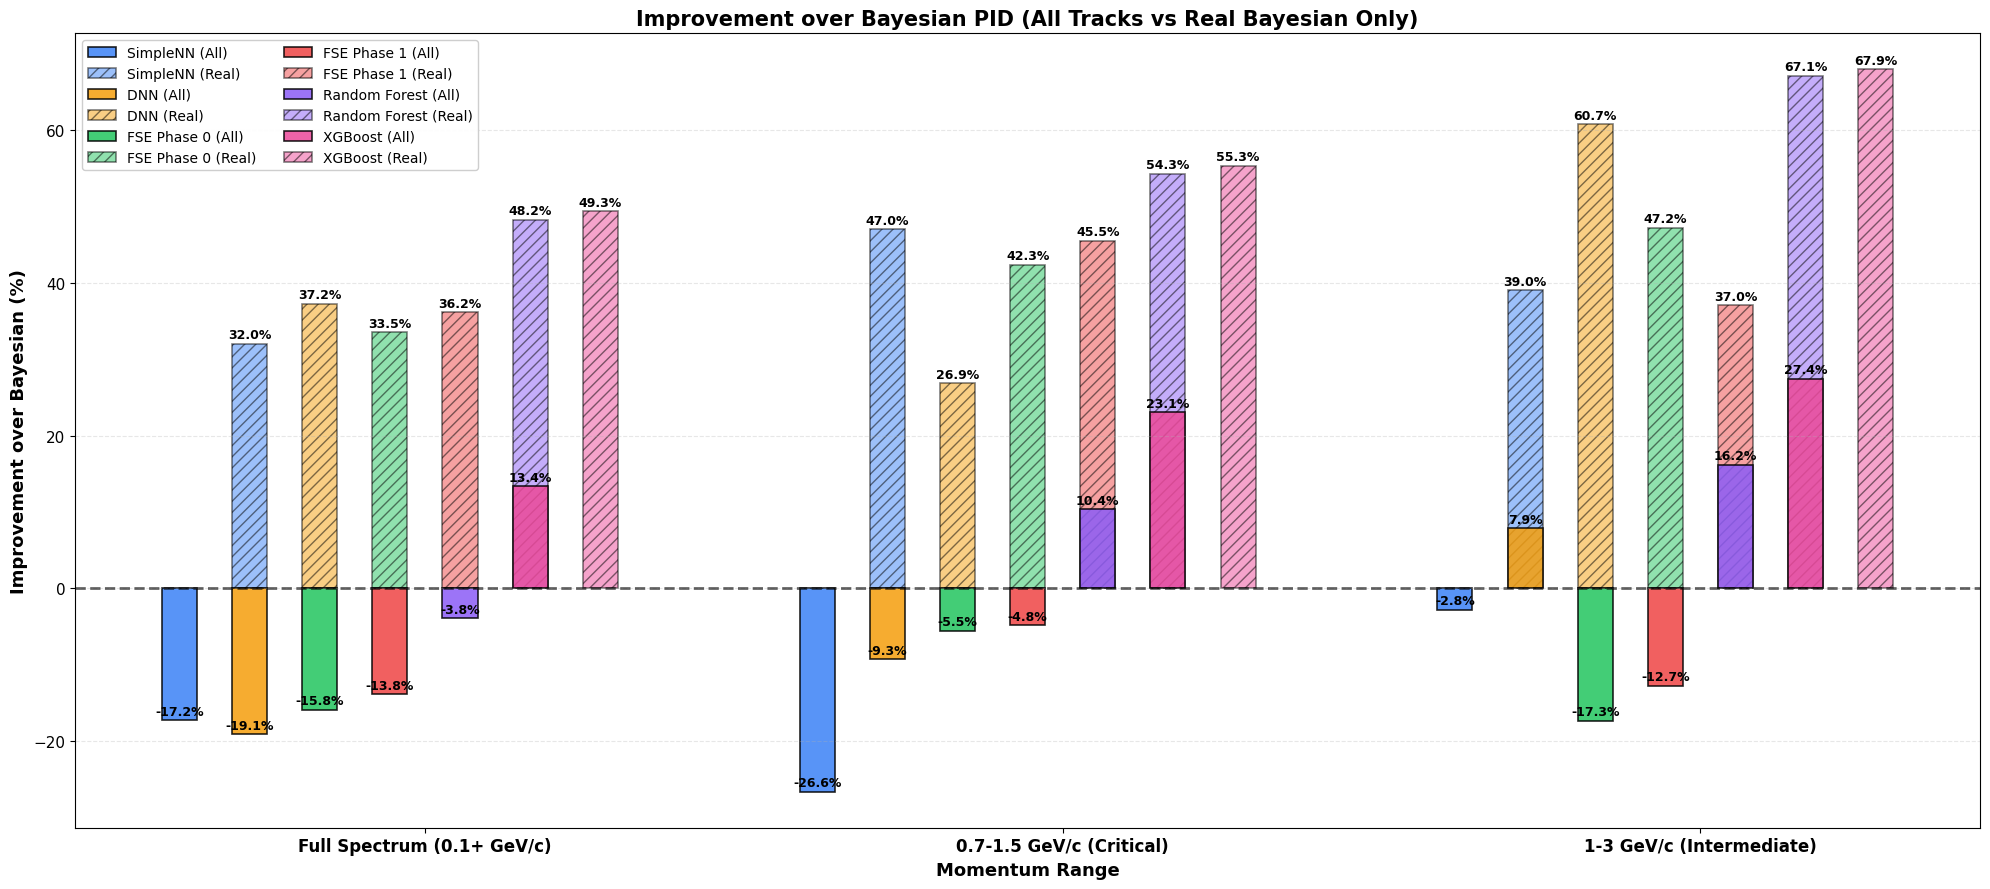

✓ Improvement percentage comparison generated

PER-PARTICLE ACCURACY: ALL MODELS VS BAYESIAN PID



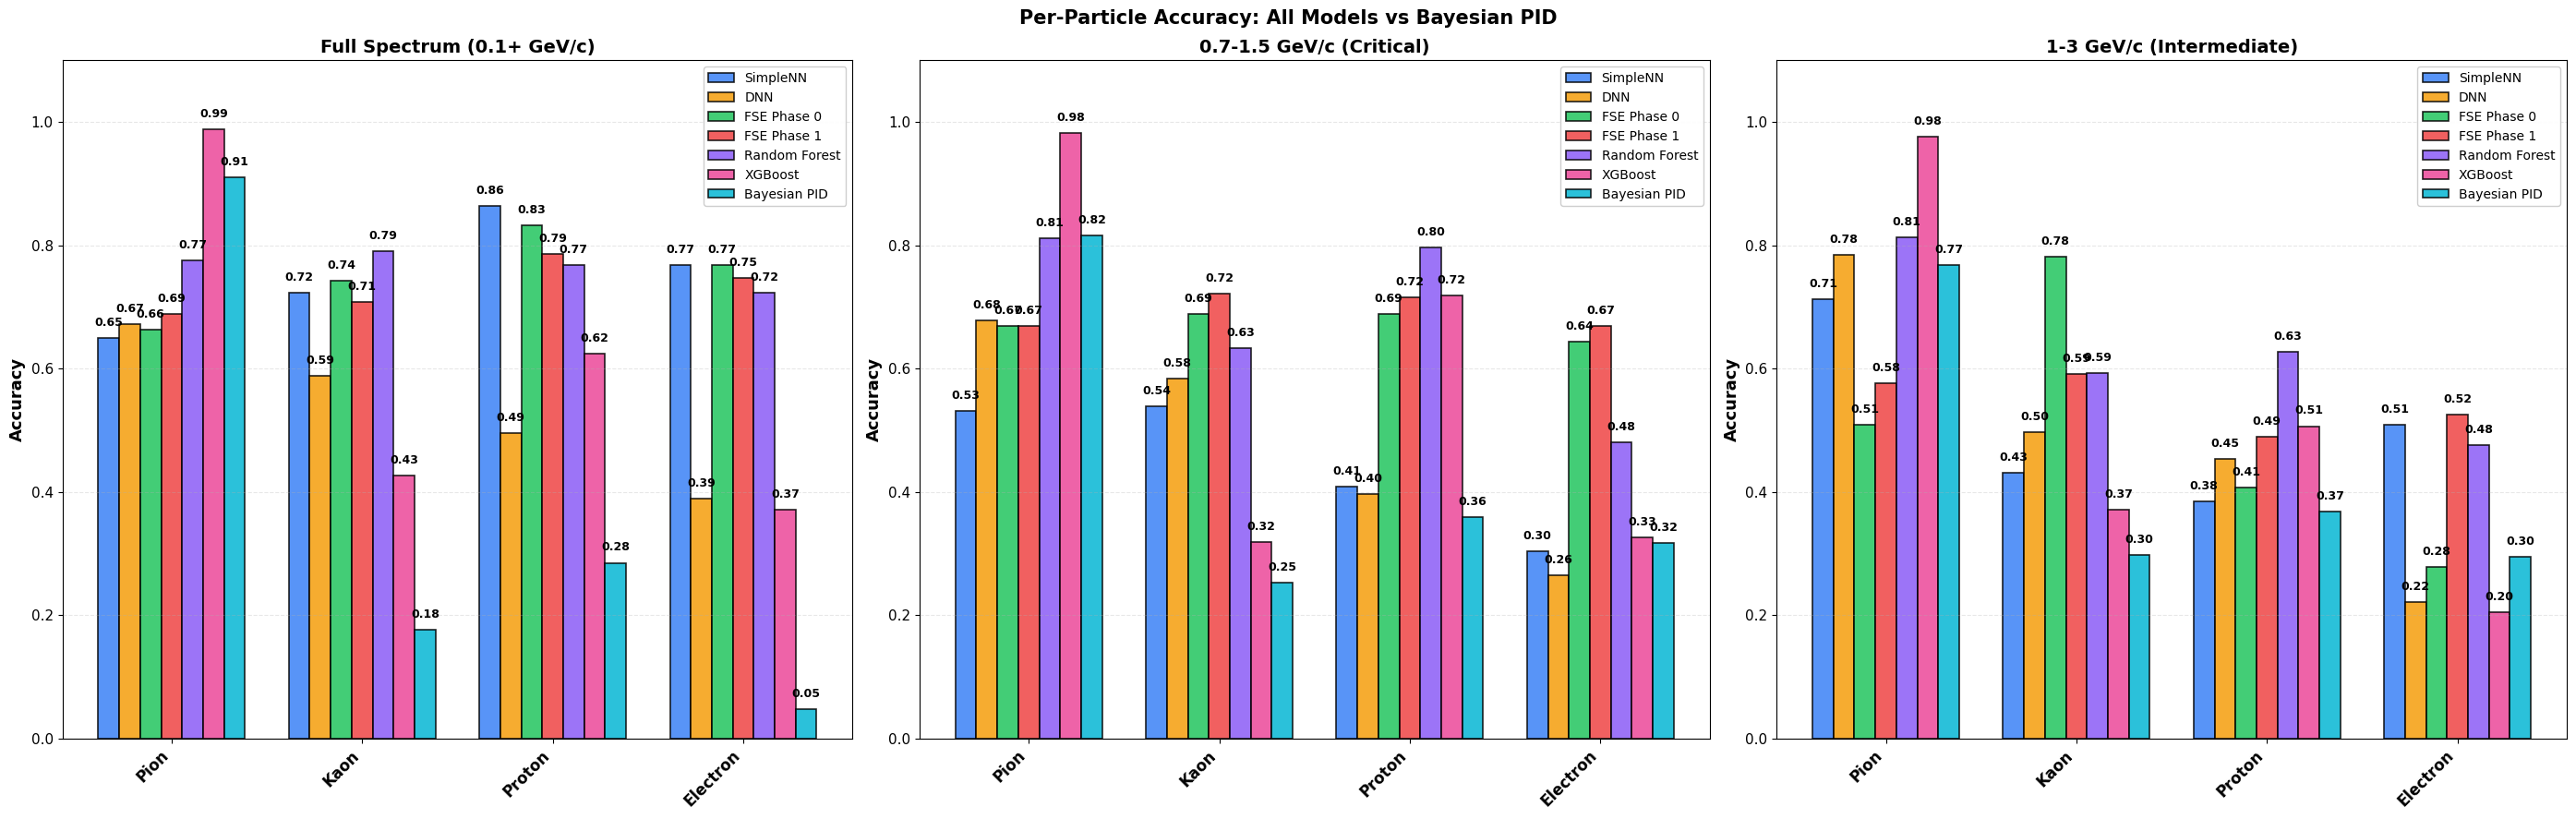

✓ Per-particle accuracy comparison generated

✓ SECTION 6 COMPLETE: All Models vs Bayesian Comparison Analysis



In [42]:
print(f"\n{'#'*80}")
print("SECTION 6: BAYESIAN PID AVAILABILITY & ALL MODELS VS BAYESIAN COMPARISON")
print(f"{'#'*80}\n")

# ============================================================================
# PART 1: BAYESIAN PID AVAILABILITY ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("PART 1: BAYESIAN PID AVAILABILITY ANALYSIS")
print(f"{'='*80}\n")

bayes_features = ['bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el']

print(f"Dataset info:")
print(f"  Total rows: {len(df):,}\n")

print(f"Bayesian PID availability per feature:")
for feat in bayes_features:
    available = (df[feat] != 0).sum()
    missing = len(df) - available
    pct_available = available / len(df) * 100
    print(f"  {feat:<20} Available: {available:>8} ({pct_available:>5.2f}%)  Missing: {missing:>8} ({100-pct_available:>5.2f}%)")

print(f"\n{'─'*80}")
print(f"COMPLETE BAYESIAN PID (all 4 features non-zero):")
bayes_complete = (df[bayes_features] != 0).all(axis=1)
complete_count = bayes_complete.sum()
complete_pct = complete_count / len(df) * 100
print(f"  Complete rows: {complete_count:>8} ({complete_pct:>5.2f}%)")
print(f"  Incomplete:    {len(df) - complete_count:>8} ({100-complete_pct:>5.2f}%)")

# ============================================================================
# PART 2: BAYESIAN AVAILABILITY BY MOMENTUM RANGE
# ============================================================================

print(f"\n{'='*80}")
print("BAYESIAN AVAILABILITY BY MOMENTUM RANGE")
print(f"{'='*80}\n")

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    df_range = df[(df['p'] >= momentum_range['min']) & (df['p'] < momentum_range['max'])]
    bayes_complete_range = (df_range[bayes_features] != 0).all(axis=1)
    complete_count_range = bayes_complete_range.sum()
    complete_pct_range = complete_count_range / len(df_range) * 100 if len(df_range) > 0 else 0
    
    print(f"{momentum_range['name']:<30}")
    print(f"  Total tracks:       {len(df_range):>8}")
    print(f"  Complete Bayesian:  {complete_count_range:>8} ({complete_pct_range:>5.2f}%)")
    print()

# ============================================================================
# PART 3: ALL MODELS VS BAYESIAN PID COMPARISON
# ============================================================================

print(f"\n{'='*80}")
print("PART 3: ALL MODELS VS BAYESIAN PID COMPARISON")
print(f"  Models: SimpleNN, DNN, FSE Phase 0, FSE Phase 1, Random Forest, XGBoost")
print(f"{'='*80}\n")

print("All model architectures available!")
print("Running comprehensive comparison...\n")

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    mr_data = all_results_by_model_and_range[mr_key]
    
    print(f"\n{'─'*80}")
    print(f"COMPARISON: {momentum_range['name']}")
    print(f"{'─'*80}\n")
    
    preprocessing = mr_data.get('preprocessing', {})
    
    if 'bayes_availability_test' not in preprocessing or 'models' not in mr_data:
        print(f"Bayesian data not found in preprocessing, skipping...")
        continue
    
    if 'JAX_SimpleNN' not in mr_data['models']:
        print(f"SimpleNN not available for this range, skipping...")
        continue
    
    # Get reference y_test and masks (use SimpleNN as reference)
    reference_results = mr_data['models']['JAX_SimpleNN']
    y_test = np.array(reference_results['y_test'])
    bayes_mask = preprocessing['bayes_availability_test']
    bayes_pred_original = preprocessing['bayes_pred_original_test']
    
    # Get predictions from all models
    model_predictions = {}
    for model_type in MODEL_TYPES:
        if model_type in mr_data['models']:
            model_predictions[model_type] = np.array(mr_data['models'][model_type]['y_pred_test'])
    
    # Track breakdown
    has_real_bayes = bayes_mask.astype(bool)
    is_filled = ~has_real_bayes
    n_real = np.sum(has_real_bayes)
    n_filled = np.sum(is_filled)
    pct_real = n_real / len(bayes_mask) * 100
    
    print(f"Track breakdown:")
    print(f"  Tracks with REAL Bayesian data:  {n_real:>8} ({pct_real:>5.2f}%)")
    print(f"  Tracks with FILLED Bayesian:    {n_filled:>8} ({100-pct_real:>5.2f}%)")
    
    # Results on all tracks
    acc_bayes_all = accuracy_score(y_test, bayes_pred_original)
    
    print(f"\n{'─'*40}")
    print(f"RESULTS ON ALL TRACKS")
    print(f"{'─'*40}")
    print(f"  Bayesian PID Accuracy:  {acc_bayes_all:.4f}")
    
    for model_type in MODEL_TYPES:
        if model_type in model_predictions:
            y_pred = model_predictions[model_type]
            acc = accuracy_score(y_test, y_pred)
            improvement = acc - acc_bayes_all
            improvement_pct = improvement / acc_bayes_all * 100 if acc_bayes_all > 0 else 0
            print(f"  {model_display_names.get(model_type, model_type):<30} {acc:.4f}  Δ {improvement:+.4f} ({improvement_pct:+.2f}%)")
    
    # Results on real Bayesian data
    if n_real > 0:
        y_test_real = y_test[has_real_bayes]
        y_pred_bayes_real = bayes_pred_original[has_real_bayes]
        acc_bayes_real = accuracy_score(y_test_real, y_pred_bayes_real)
        
        print(f"\n{'─'*40}")
        print(f"RESULTS ON TRACKS WITH REAL BAYESIAN DATA")
        print(f"{'─'*40}")
        print(f"  Bayesian PID Accuracy:  {acc_bayes_real:.4f}")
        
        for model_type in MODEL_TYPES:
            if model_type in model_predictions:
                y_pred = model_predictions[model_type]
                y_pred_real = y_pred[has_real_bayes]
                acc = accuracy_score(y_test_real, y_pred_real)
                improvement = acc - acc_bayes_real
                improvement_pct = improvement / acc_bayes_real * 100 if acc_bayes_real > 0 else 0
                print(f"  {model_display_names.get(model_type, model_type):<30} {acc:.4f}  Δ {improvement:+.4f} ({improvement_pct:+.2f}%)")

# ============================================================================
# PLOT 1: ACCURACY COMPARISON - ALL MODELS VS BAYESIAN PID
# ============================================================================

print(f"\n{'='*80}")
print("VISUAL COMPARISON: ALL MODELS VS BAYESIAN PID")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(28, 9))
comparison_data = []

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    mr_data = all_results_by_model_and_range[mr_key]
    ax = axes[mr_idx]
    
    preprocessing = mr_data.get('preprocessing', {})
    
    if 'bayes_availability_test' not in preprocessing or 'models' not in mr_data:
        continue
    
    if 'JAX_SimpleNN' not in mr_data['models']:
        continue
    
    y_test = np.array(mr_data['models']['JAX_SimpleNN']['y_test'])
    bayes_mask = preprocessing['bayes_availability_test']
    bayes_pred_original = preprocessing['bayes_pred_original_test']
    
    acc_bayes_all = accuracy_score(y_test, bayes_pred_original)
    has_real_bayes = bayes_mask.astype(bool)
    
    if np.sum(has_real_bayes) > 0:
        acc_bayes_real = accuracy_score(y_test[has_real_bayes], bayes_pred_original[has_real_bayes])
    else:
        acc_bayes_real = 0
    
    categories = ['All Tracks', 'Real Bayes Only']
    x = np.arange(len(categories))
    width = 0.11
    
    model_accs_all = {}
    model_accs_real = {}
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data['models']:
            y_pred = np.array(mr_data['models'][model_type]['y_pred_test'])
            model_accs_all[model_type] = accuracy_score(y_test, y_pred)
            
            if np.sum(has_real_bayes) > 0:
                model_accs_real[model_type] = accuracy_score(y_test[has_real_bayes], y_pred[has_real_bayes])
            else:
                model_accs_real[model_type] = 0
    
    # Position offset for 6 models + 1 Bayesian = 7 groups
    position_offset = -3.0 * width
    
    # Plot each model
    for idx, model_type in enumerate(MODEL_TYPES):
        if model_type in model_accs_all:
            accs = [model_accs_all[model_type], model_accs_real[model_type]]
            bars = ax.bar(x + position_offset, accs, width, 
                         label=model_display_names.get(model_type, model_type),
                         color=model_colors_dict.get(model_type, '#999999'),
                         alpha=0.85, edgecolor='black', linewidth=1.2)
            
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.012,
                           f'{height:.3f}', ha='center', va='bottom',
                           fontsize=10, fontweight='bold', rotation=0)
            
            position_offset += width
    
    # Plot Bayesian (last bar)
    bayes_accs = [acc_bayes_all, acc_bayes_real]
    bars_bayes = ax.bar(x + position_offset, bayes_accs, width,
                       label='Bayesian PID',
                       color='#06B6D4', alpha=0.85, edgecolor='black', linewidth=1.2)
    
    for bar in bars_bayes:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.012,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=10, fontweight='bold', rotation=0)
    
    ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.legend(fontsize=10, loc='upper left', ncol=1, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='y', labelsize=11)
    
    comparison_data.append({
        'Range': momentum_range['name'],
        'Models': model_accs_all,
        'ModelsReal': model_accs_real,
        'BayesAll': acc_bayes_all,
        'BayesReal': acc_bayes_real
    })

plt.suptitle('Accuracy Comparison: All Models vs Bayesian PID (All Tracks & Real Bayesian Only)', 
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ All models vs Bayesian comparison plot generated")

# ============================================================================
# PLOT 2: IMPROVEMENT OVER BAYESIAN PID
# ============================================================================

print(f"\n{'='*80}")
print("IMPROVEMENT OVER BAYESIAN PID")
print(f"{'='*80}\n")

fig, ax = plt.subplots(figsize=(20, 9))

ranges = [d['Range'] for d in comparison_data]
x = np.arange(len(ranges))
width = 0.11
position_offset = -3.0 * width

for model_type in MODEL_TYPES:
    improvements_all = []
    improvements_real = []
    
    for d in comparison_data:
        if model_type in d['Models']:
            imp_all = (d['Models'][model_type] - d['BayesAll']) / d['BayesAll'] * 100
            improvements_all.append(imp_all)
            
            if d['BayesReal'] > 0:
                imp_real = (d['ModelsReal'][model_type] - d['BayesReal']) / d['BayesReal'] * 100
            else:
                imp_real = 0
            improvements_real.append(imp_real)
    
    if improvements_all:
        # All tracks bars
        bars_all = ax.bar(x + position_offset - width/2, improvements_all, width/2,
                         label=f'{model_display_names.get(model_type, model_type)} (All)',
                         color=model_colors_dict.get(model_type, '#999999'),
                         alpha=0.85, edgecolor='black', linewidth=1.2)
        
        for bar in bars_all:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                   f'{height:.1f}%', ha='center', va='bottom',
                   fontsize=9, fontweight='bold', rotation=0)
    
    if improvements_real:
        # Real Bayesian bars
        bars_real = ax.bar(x + position_offset + width/2, improvements_real, width/2,
                          label=f'{model_display_names.get(model_type, model_type)} (Real)',
                          color=model_colors_dict.get(model_type, '#999999'),
                          alpha=0.5, edgecolor='black', linewidth=1.2, hatch='///')
        
        for bar in bars_real:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                   f'{height:.1f}%', ha='center', va='bottom',
                   fontsize=9, fontweight='bold', rotation=0)
    
    position_offset += width

ax.axhline(y=0, color='k', linestyle='--', linewidth=2, alpha=0.6)
ax.set_ylabel('Improvement over Bayesian (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Momentum Range', fontsize=13, fontweight='bold')
ax.set_title('Improvement over Bayesian PID (All Tracks vs Real Bayesian Only)', 
             fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ranges, fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='best', ncol=2, framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()

print("✓ Improvement percentage comparison generated")

# ============================================================================
# PLOT 3: PER-PARTICLE ACCURACY - ALL MODELS VS BAYESIAN PID
# ============================================================================

print(f"\n{'='*80}")
print("PER-PARTICLE ACCURACY: ALL MODELS VS BAYESIAN PID")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(28, 9))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    mr_data = all_results_by_model_and_range[mr_key]
    ax = axes[mr_idx]
    
    preprocessing = mr_data.get('preprocessing', {})
    
    if 'bayes_availability_test' not in preprocessing or 'models' not in mr_data:
        continue
    
    if 'JAX_SimpleNN' not in mr_data['models']:
        continue
    
    y_test = np.array(mr_data['models']['JAX_SimpleNN']['y_test'])
    bayes_pred_original = preprocessing['bayes_pred_original_test']
    
    particles = []
    model_particle_accs = {model_type: [] for model_type in MODEL_TYPES}
    bayes_particle_accs = []
    
    for i, particle_name in enumerate(PARTICLE_NAMES):
        mask = y_test == i
        
        if np.sum(mask) > 0:
            particles.append(particle_name)
            
            for model_type in MODEL_TYPES:
                if model_type in mr_data['models']:
                    y_pred = np.array(mr_data['models'][model_type]['y_pred_test'])
                    model_particle_accs[model_type].append(accuracy_score(y_test[mask], y_pred[mask]))
                else:
                    model_particle_accs[model_type].append(0)
            
            bayes_particle_accs.append(accuracy_score(y_test[mask], bayes_pred_original[mask]))
    
    x = np.arange(len(particles))
    width = 0.11
    position_offset = -3.0 * width
    
    # Plot each model
    for model_type in MODEL_TYPES:
        if model_particle_accs[model_type]:
            bars = ax.bar(x + position_offset, model_particle_accs[model_type], width,
                         label=model_display_names.get(model_type, model_type),
                         color=model_colors_dict.get(model_type, '#999999'),
                         alpha=0.85, edgecolor='black', linewidth=1.2)
            
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.015,
                           f'{height:.2f}', ha='center', va='bottom',
                           fontsize=9, fontweight='bold', rotation=0)
            
            position_offset += width
    
    # Plot Bayesian
    bars_bayes = ax.bar(x + position_offset, bayes_particle_accs, width,
                       label='Bayesian PID',
                       color='#06B6D4', alpha=0.85, edgecolor='black', linewidth=1.2)
    
    for bar in bars_bayes:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.015,
                   f'{height:.2f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold', rotation=0)
    
    ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(particles, fontsize=12, fontweight='bold', rotation=45, ha='right')
    ax.set_ylim([0, 1.1])
    ax.legend(fontsize=10, loc='upper right', ncol=1, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='y', labelsize=11)

plt.suptitle('Per-Particle Accuracy: All Models vs Bayesian PID', 
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ Per-particle accuracy comparison generated")

print(f"\n{'='*80}")
print("✓ SECTION 6 COMPLETE: All Models vs Bayesian Comparison Analysis")
print(f"{'='*80}\n")
